# Выпускной проект 
## Задача промышленности

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Описание данных

<b>Данные состоят из файлов, полученных из разных источников:</b>

 * data_arc.csv — данные об электродах;
 * data_bulk.csv — данные о подаче сыпучих материалов (объём);
 * data_bulk_time.csv — данные о подаче сыпучих материалов (время);
 * data_gas.csv — данные о продувке сплава газом;
 * data_temp.csv — результаты измерения температуры;
 * data_wire.csv — данные о проволочных материалах (объём);
 * data_wire_time.csv — данные о проволочных материалах (время).  
 
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Целевая информация:
<b>Целевой признак:</b> последняя измеренная температура  

<b>Метрика:</b> MAE  

<b>Максимально допустимое качество метрики:</b>  MAE ≤ 6.8

* Для модели берем только кейсы, которые содержат первичный и финальный замер температуры.
* Замеры финальной температуры, которые были проведены во время нагрева - не являются целевыми.

### Содержание <a name="top"></a>

#### 1. [Исследовательский анализ данных](#EDA)
 <b>[Анализ данных об электродах](#arc)</b>  
  <b>[Анализ данных об объеме сыпучих веществ](#bulk)</b>  
   <b>[Анализ данных о времени подачи сыпучих веществ](#bulk_time)</b>  
    <b>[Анализ данных о продувке сплава газом](#gas)</b>  
     <b>[Анализ данных о результатах измерения температур](#temp)</b>  
      <b>[Анализ данных об объеме проволочных материалов](#wire)</b>  
       <b>[Анализ данных о времени подачи проволочных материалов](#wire_time)</b>   
       <b>[Вывод](#вывод)</b>

#### 2. [Предобработка данных](#Предобработка) 
#### 3. [Обучение моделей](#Обучение) 
#### 4. [Тестирование модели](#Тестирование)
#### 5. [Проверка на адекватность](#адекватность) 

### 1. Исследовательский анализ данных <a name="EDA"></a>

In [103]:
import sys; print(sys.version)
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold

from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool, cv

import warnings
warnings.simplefilter("ignore", category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
%config InlineBackend.figure_format='retina'


import pip
pip.main(['install', 'lazypredict'])
%pip install lazypredict
%pip install pytest
%pip install cython
import lazypredict
from lazypredict.Supervised import LazyRegressor

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Функции-помощники

In [2]:
#определим цвет для текстов
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
#функция ислледовательского анализа
def display_info(name, head, tail, shape, info, nan, describe, duplicate, unique, corr, corr_map):
    #**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

    #* name - название базы данных
    #* head - n: вывод примера базы (вывод n - строк), n = 0: не вывод
    #* tail - n: вывод примера базы (вывод n - строк), n = 0: не вывод
    #* shape - 1: вывод информаии о размерах датасета,  другое: не вывод
    #* info - 1: вывод информации о массиве, другое: не вывод
    #* nan - 1: вывод информации количестве пропусков, другое: не вывод
    #* describe - 1: вывод описания переменных массива, другое: не вывод   
                  #Возвращает транспонированный describe()
                  #Добавляет строку с долей пропусков для каждого столбца
    #* duplicate - 1: вывод количества полных дублей
    #* unique - 1: вывод количества неуникальных значений, другое: не вывод
    #* corr - 1: вывод цоэффициентов корреляции, другое: не вывод
    
    if head >= 1:
        print("\n", color.BOLD + color.RED + 'HEAD' + color.END, "\n")
        display(name.head(head))
    if tail >= 1:
        print("\n", color.BOLD + color.RED + 'TAIL' + color.END, "\n")
        display(name.tail(tail))
    if shape == 1:
        print("\n", color.BOLD + color.RED + 'SHAPE' + color.END, "\n")
        display(name.shape)
    if info == 1:
        print("\n", color.BOLD + color.RED + 'INFO' + color.END, "\n")
        display(name.info())
    if nan == 1:
        print("\n", color.BOLD + color.RED + 'NAN, %' + color.END, "\n")
        display(round(name.isna().sum()/name.shape[0]*100, 2))
    if unique == 1:
        print("\n", color.BOLD + color.RED + 'UNIQUE' + color.END, "\n")
        display(name.nunique())    
        print("\n", color.BOLD + color.RED + 'UNUNIQUE' + color.END, "\n")
        display(name.shape[0] - name.nunique())
    if describe == 1:
        print("\n", color.BOLD + color.RED + 'DESCRIBE' + color.END, "\n")
        display(name.describe().transpose())
    if duplicate == 1:
        print("\n", color.BOLD + color.RED + 'DUPLICATES' + color.END, "\n")
        display(name[name.duplicated() == True][name.columns[0]].count())
    if corr == 1:
        print("\n", color.BOLD + color.RED + 'CORR' + color.END, "\n")
        display(name.corr())
    if corr_map != 'None':
        print("\n", color.BOLD + color.RED + 'CORR_MAP' + color.END, "\n")
        display(sns.heatmap(name.corr(), vmin = corr_map))

In [4]:
#для отображения только гистограм по списку столбоы
def sns_hist(df, columns, x_figsize, y_figsize, n_bins, x_rot, title, xlabel, ylabel, label, legend, yscale):
    col = math.ceil(len(df.columns)/3)
    plt.figure(figsize=(x_figsize, y_figsize))
    for i, context in enumerate(columns):
        sns.set()
        plt.subplot(col, 3, i+1)
        sns.distplot(df[context], bins=n_bins,  kde=False)
        if title == 1:
            plt.title(context, fontsize=15)
        if x_rot > 0:
            plt.xticks(rotation=x_rot)
        if xlabel != 'None':
            plt.xlabel(context)
        if ylabel != 'None':
            plt.ylabel('Плотность распределения')
        if legend == 1:
            plt.legend()
        if yscale != 'None':
            plt.yscale('log')
    plt.show()

In [5]:
#для отображения гистограм и боксплотов
def sns_hist_box(df, columns, x_figsize, y_figsize, n_bins, x_rot, title, ylabel, label, legend):
    col = math.ceil(len(df.columns)/2)
    plt.figure(figsize=(x_figsize, y_figsize))
    

    for context in columns:
        sns.set()
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                            gridspec_kw={"height_ratios": (.15, .85)})
        sns.boxplot(df[context], ax=ax_box)
        sns.distplot(df[context].dropna(), ax=ax_hist, kde=False)
        ax_box.set(xlabel='')
        if title == 1:
            plt.title(context, fontsize=15)
        if x_rot > 0:
            plt.xticks(rotation=x_rot)
        #if ylabel != 'None':
            #plt.ylabel(ylabel)
        if legend == 1:
            plt.legend()
    
    plt.show()


### Загружаем данные

In [6]:
#создадим словарь с путями к датасетам
pathes = {'arc': 'data_arc.csv',
          'bulk': 'data_bulk.csv',
          'bulk_time': 'data_bulk_time.csv',
          'gas':'data_gas.csv',
          'temp': 'data_temp.csv', 
          'wire': 'data_wire.csv', 
          'wire_time': 'data_wire_time.csv'}

In [7]:
#функция для загрузки данных
def open_files(key, path, parse_dates):
    return pd.read_csv('/datasets/final_steel/'+ path[key], sep=',',decimal='.', parse_dates=parse_dates)

In [8]:
#создаем таблицы данных 
#парсинг дат добавили позже
arc = open_files('arc', pathes, False)
bulk = open_files('bulk', pathes, False)
bulk_time = open_files('bulk_time', pathes, list(range(1,16)))
gas = open_files('gas', pathes, False)
temp = open_files('temp', pathes, [1])
wire = open_files('wire', pathes, False)
wire_time = open_files('wire_time', pathes, list(range(1,10)))

In [9]:
#словарь с таблицами данных для удобства работы
data = {'arc': arc, 'bulk': bulk, 'bulk_time': bulk_time,
          'gas': gas, 'temp': temp, 'wire': wire, 'wire_time': wire_time}

#### Анализ данных об электродах <a name="arc"></a>

In [10]:
#посмотрим на данные разными способами
display_info(name=arc,  head=5, tail=11, shape=1, info=1, nan=1, describe=1, duplicate=1, unique=1, corr=1, corr_map='None')


 HEAD 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41



 TAIL 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14865,3239,2019-09-01 02:13:38,2019-09-01 02:15:43,0.49,0.32
14866,3240,2019-09-01 02:35:24,2019-09-01 02:37:25,0.41,0.27
14867,3240,2019-09-01 02:40:55,2019-09-01 02:43:28,0.52,0.38
14868,3240,2019-09-01 03:08:38,2019-09-01 03:11:08,0.52,0.53
14869,3240,2019-09-01 03:12:34,2019-09-01 03:17:08,0.98,0.88
14870,3240,2019-09-01 03:31:47,2019-09-01 03:34:08,0.55,0.42
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.53,0.35
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.68,0.52
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.73,0.48
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.22,0.15



 SHAPE 



(14876, 5)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None


 NAN, % 



key                    0.00
Начало нагрева дугой   0.00
Конец нагрева дугой    0.00
Активная мощность      0.00
Реактивная мощность    0.00
dtype: float64


 UNIQUE 



key                      3214
Начало нагрева дугой    14875
Конец нагрева дугой     14876
Активная мощность       14869
Реактивная мощность     14866
dtype: int64


 UNUNIQUE 



key                     11662
Начало нагрева дугой        1
Конец нагрева дугой         0
Активная мощность           7
Реактивная мощность        10
dtype: int64


 DESCRIBE 



,count,mean,std,min,25%,50%,75%,max
key,14876.00,1615.22,934.57,1.00,806.00,1617.00,2429.00,3241.00
Активная мощность,14876.00,0.67,0.41,0.03,0.40,0.56,0.86,3.73
Реактивная мощность,14876.00,0.45,5.88,-715.50,0.29,0.42,0.64,2.68



 DUPLICATES 



0


 CORR 



,key,Активная мощность,Реактивная мощность
key,1.00,-0.02,-0.00
Активная мощность,-0.02,1.00,0.05
Реактивная мощность,-0.00,0.05,1.00


<b>Что увидели при первом рассмотрении данных по мощностям:</b>  

* Партии нагреваются нескольо раз.
* Всего 14876 строк.
* Пропусков нет.
* Дублирующих строк нет.
* Столбцы со временем нагрева неверного формата - необходимо будет перевести в формат времени.
* Остальные столбцы содержат нужный формат для работы с ними.
* Уникальных ключей (партий) всего 3214.
* Минусовая реактивная мощность - проверим сколько их.
* Максимальное значение активной мощности далеко от медианы и 3-го квартиля - проверим сколько таких.
* Мультиколлинеарности между мощностями нет.

In [11]:
#переведем столбцы со временем в нужный формат 
#вернемся к загрузке данных и в остальных таблицах проведем парсинг времени, чтобы не будлировать код ниже
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null datetime64[ns]
Конец нагрева дугой     14876 non-null datetime64[ns]
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


<Figure size 1440x576 with 0 Axes>

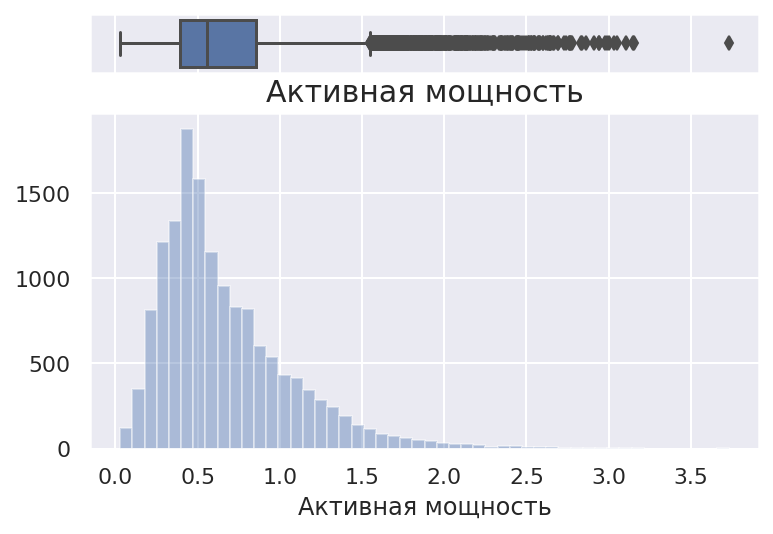

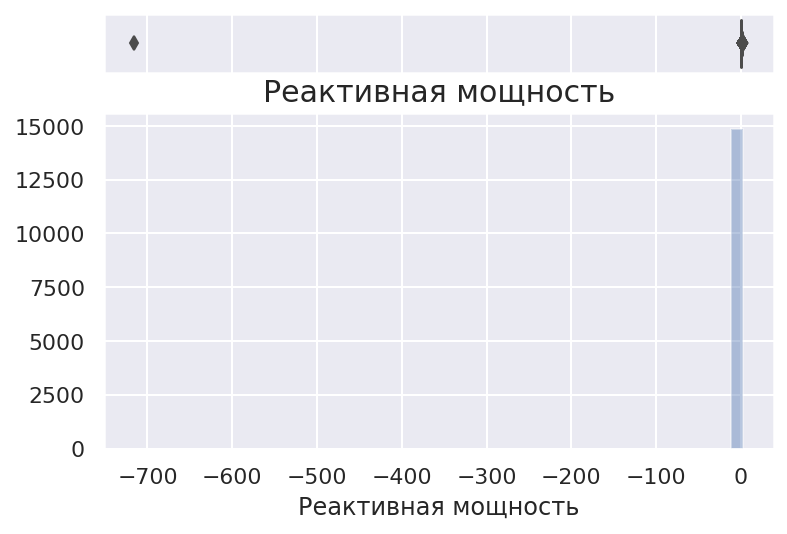

In [12]:
#посмотрим на выбросы/аномальные значения мощностей
sns_hist_box(df = arc,
             columns =['Активная мощность', 'Реактивная мощность'],
             x_figsize=20, y_figsize=8,
             n_bins=50,
             x_rot =0,
             title=1,
             label="None", legend=0,
             ylabel = 1
            )

<b>Посмотрим много ли случаев с аномальными значениями мощностей</b>

In [13]:
display(arc[arc['Активная мощность'] > 3.5])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
7799,1689,2019-07-02 18:49:03,2019-07-02 19:04:10,3.73,2.68


In [14]:
display(arc[arc['Реактивная мощность'] < 0])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.50,-715.50


<b>Выбросы по мощностям единичные, возможно это ошибка измерений - заменим их на медианы по партиям.</b>

In [15]:
arc.loc[7799, 'Активная мощность'] = arc[(arc['Активная мощность'] <= 3.5) & (arc['key'] ==1689)]['Активная мощность'].median()
arc[arc['Активная мощность'] > 3.5] #проверка на наличие аномальных значений, если строк нет - значит замена прошла успешно 

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


In [16]:
arc.loc[9780, 'Реактивная мощность'] = arc[
    (arc['Реактивная мощность'] >= 0) & (arc['key'] ==2116)]['Реактивная мощность'].median()
arc[arc['Реактивная мощность'] < 0] #проверка на наличие аномальных значений, если строк нет - значит замена прошла успешно 

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


<Figure size 1440x576 with 0 Axes>

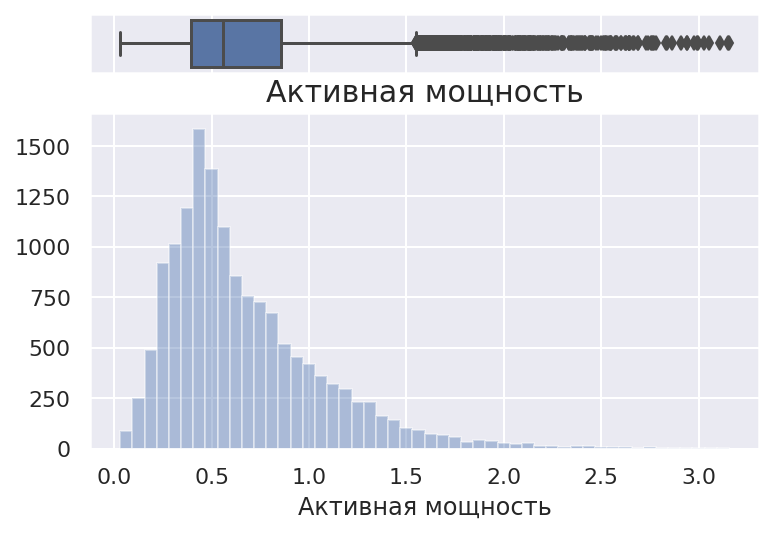

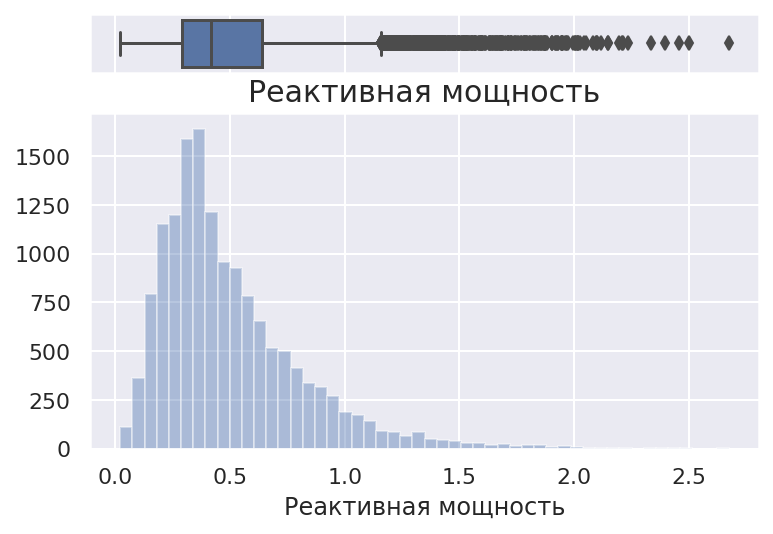

In [17]:
#посмотрим еще раз на распределение
sns_hist_box(df = arc,
             columns =['Активная мощность', 'Реактивная мощность'],
             x_figsize=20, y_figsize=8,
             n_bins=50,
             x_rot =0,
             title=1,
             label="None", legend=0,
             ylabel = 1
            )

<b>Совсем другое дело, распределение мощностей можно отнести к нормальному. Смещено влево</b>

In [18]:
#посмотрим, расположены ли в хронологическом порядке даты
display(arc['Начало нагрева дугой'].is_monotonic)
display(arc['Конец нагрева дугой'].is_monotonic)

False

False

Нет, даты расположены не в хронологическом порядке. Имеются данные с 3 марта 2019 года по 1 сентября 2019 года.

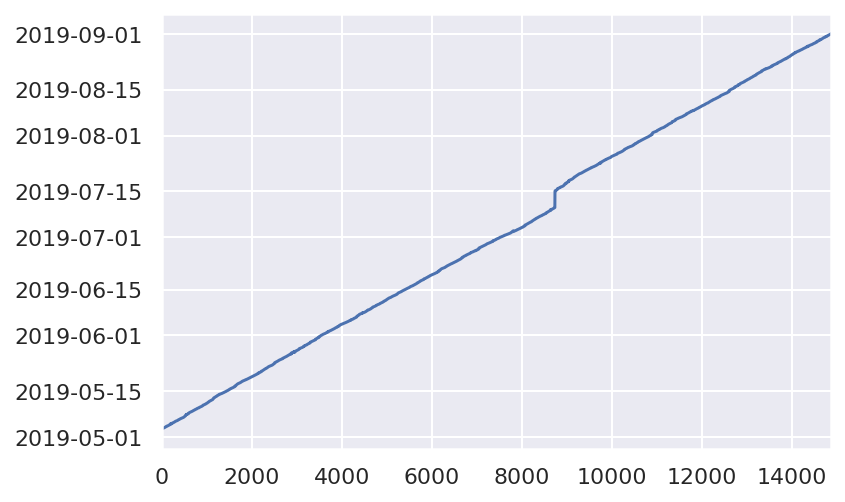

In [19]:
#посмотрим на данные на графике
arc['Начало нагрева дугой'].plot()
plt.show()

Имеется резкий скачок во времени проведения итераций. Посмотрим крупнее на него

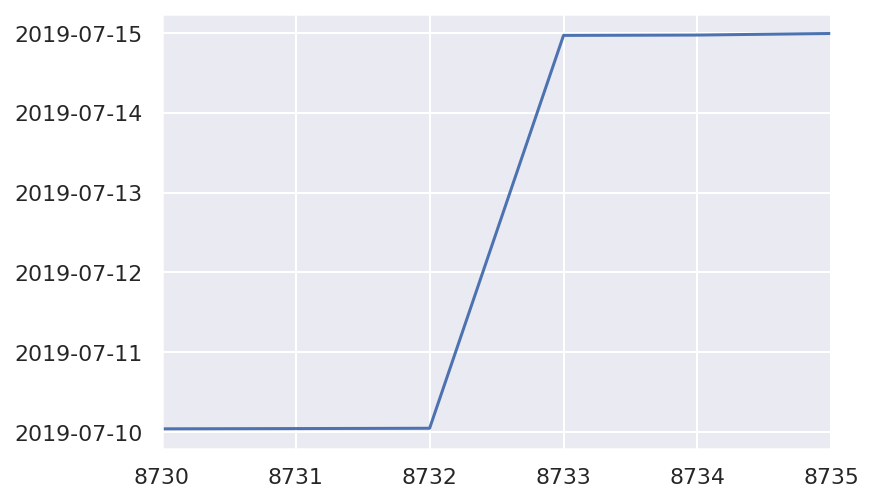

In [20]:
arc.loc[8730:8735, 'Начало нагрева дугой'].plot()
plt.show()

Посмотрим на конкретные итерации, разница осуществления которых составляет 4 дня

In [21]:
display(arc.query('key == 1899 or key == 1900'))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
8728,1899,2019-07-10 00:35:25,2019-07-10 00:37:32,0.42,0.36
8729,1899,2019-07-10 00:44:50,2019-07-10 00:53:11,2.07,1.71
8730,1899,2019-07-10 00:54:37,2019-07-10 00:57:52,0.87,0.61
8731,1899,2019-07-10 00:59:13,2019-07-10 01:02:36,0.91,0.62
8732,1899,2019-07-10 01:04:59,2019-07-10 01:05:55,0.24,0.18
8733,1900,2019-07-14 23:17:28,2019-07-14 23:18:44,0.26,0.20
8734,1900,2019-07-14 23:23:26,2019-07-14 23:27:21,0.77,0.57
8735,1900,2019-07-14 23:51:38,2019-07-14 23:56:09,0.91,0.81
8736,1900,2019-07-15 00:02:50,2019-07-15 00:06:23,0.82,0.64
8737,1900,2019-07-15 00:06:57,2019-07-15 00:08:26,0.34,0.29


Посмотрим ближе на итерации, которые идут не в хронологическом порядке

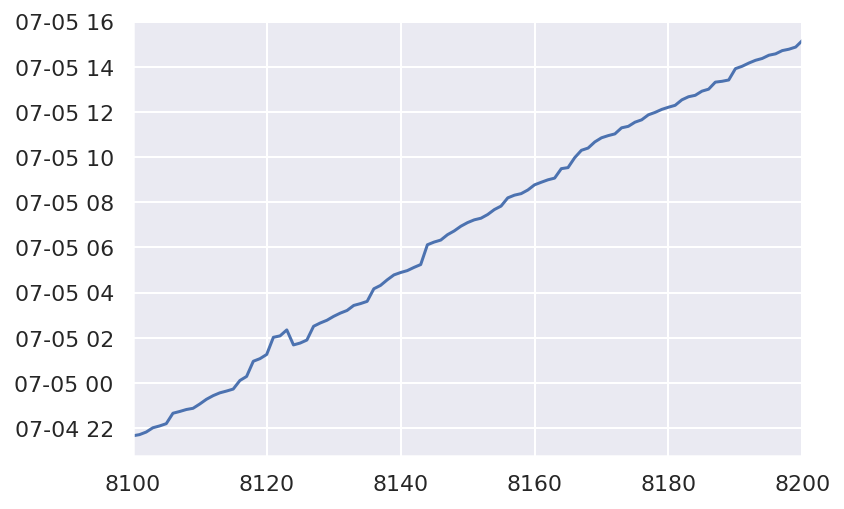

In [22]:
arc.loc[8100:8200, 'Начало нагрева дугой'].plot()
plt.show()

In [23]:
display(arc[8120:8130])

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
8120,1760,2019-07-05 01:15:44,2019-07-05 01:19:14,0.93,0.64
8121,1760,2019-07-05 02:01:20,2019-07-05 02:02:22,0.19,0.16
8122,1760,2019-07-05 02:05:09,2019-07-05 02:08:45,0.94,0.63
8123,1760,2019-07-05 02:20:56,2019-07-05 02:23:08,0.58,0.39
8124,1761,2019-07-05 01:41:03,2019-07-05 01:43:01,0.39,0.32
8125,1761,2019-07-05 01:46:03,2019-07-05 01:49:56,0.93,0.68
8126,1761,2019-07-05 01:54:02,2019-07-05 01:57:57,1.02,0.70
8127,1761,2019-07-05 02:30:34,2019-07-05 02:35:32,1.28,0.92
8128,1761,2019-07-05 02:39:21,2019-07-05 02:41:48,0.64,0.46
8129,1761,2019-07-05 02:46:37,2019-07-05 02:48:02,0.37,0.27


<b>Некоторые итерации проведены не в хронологическом порядке, например, партия 1760 и 1761 обрабатывались одновременно.Выяснить - допустима ли такая ситуация по технологии.</b>

#### Выводы  

* Выяснили у тимлида, что лаги во времени нагрева различных партий могут быть обусловлены графиком работы предприятия. Легирование стали определенной партии не зависит от другой и может проводиться параллельно. Вопрос снят, больше не рассматриваем.
* Единичные выбросы по мощностям хоть и единичны и не повлияют на обучение модели, заменили на медиану реактивных мощностей по партии.
* В качестве дополнительных фичей можно добавить расчетные величны, такие как количество замеров, средние мощности и суммы, посмотреть как они вляют на итоговую температуру и выбрать лучшие.

[К содержанию](#top)

#### Анализ данных об объеме сыпучих веществ <a name="bulk"></a>


 HEAD 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,43.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,150.00,154.00
1,2,nan,nan,nan,73.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,149.00,154.00
2,3,nan,nan,nan,34.00,nan,nan,nan,nan,nan,nan,nan,205.00,nan,152.00,153.00
3,4,nan,nan,nan,81.00,nan,nan,nan,nan,nan,nan,nan,207.00,nan,153.00,154.00
4,5,nan,nan,nan,78.00,nan,nan,nan,nan,nan,nan,nan,203.00,nan,151.00,152.00



 TAIL 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,nan,nan,170.00,nan,nan,nan,nan,nan,nan,nan,nan,252.00,nan,130.00,206.00
3125,3238,nan,nan,126.00,nan,nan,nan,nan,nan,nan,nan,nan,254.00,nan,108.00,106.00
3126,3239,nan,nan,nan,nan,nan,114.00,nan,nan,nan,nan,nan,158.00,nan,270.00,88.00
3127,3240,nan,nan,nan,nan,nan,26.00,nan,nan,nan,nan,nan,nan,nan,192.00,54.00
3128,3241,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,180.00,52.00



 SHAPE 



(3129, 16)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None


 NAN, % 



key        0.00
Bulk 1    91.95
Bulk 2    99.30
Bulk 3    58.52
Bulk 4    67.59
Bulk 5    97.54
Bulk 6    81.59
Bulk 7    99.20
Bulk 8    99.97
Bulk 9    99.39
Bulk 10   94.38
Bulk 11   94.34
Bulk 12   21.70
Bulk 13   99.42
Bulk 14   10.32
Bulk 15   28.16
dtype: float64


 UNIQUE 



key        3129
Bulk 1       47
Bulk 2       15
Bulk 3      278
Bulk 4      206
Bulk 5       55
Bulk 6      205
Bulk 7       25
Bulk 8        1
Bulk 9       10
Bulk 10      77
Bulk 11     101
Bulk 12     331
Bulk 13      14
Bulk 14     284
Bulk 15     156
dtype: int64


 UNUNIQUE 



key           0
Bulk 1     3082
Bulk 2     3114
Bulk 3     2851
Bulk 4     2923
Bulk 5     3074
Bulk 6     2924
Bulk 7     3104
Bulk 8     3128
Bulk 9     3119
Bulk 10    3052
Bulk 11    3028
Bulk 12    2798
Bulk 13    3115
Bulk 14    2845
Bulk 15    2973
dtype: int64


 DESCRIBE 



,count,mean,std,min,25%,50%,75%,max
key,3129.00,1624.38,933.34,1.00,816.00,1622.00,2431.00,3241.00
Bulk 1,252.00,39.24,18.28,10.00,27.00,31.00,46.00,185.00
Bulk 2,22.00,253.05,21.18,228.00,242.00,251.50,257.75,325.00
Bulk 3,1298.00,113.88,75.48,6.00,58.00,97.50,152.00,454.00
Bulk 4,1014.00,104.39,48.18,12.00,72.00,102.00,133.00,281.00
Bulk 5,77.00,107.03,81.79,11.00,70.00,86.00,132.00,603.00
Bulk 6,576.00,118.93,72.06,17.00,69.75,100.00,157.00,503.00
Bulk 7,25.00,305.60,191.02,47.00,155.00,298.00,406.00,772.00
Bulk 8,1.00,49.00,nan,49.00,49.00,49.00,49.00,49.00
Bulk 9,19.00,76.32,21.72,63.00,66.00,68.00,70.50,147.00



 DUPLICATES 



0


 CORR_MAP 



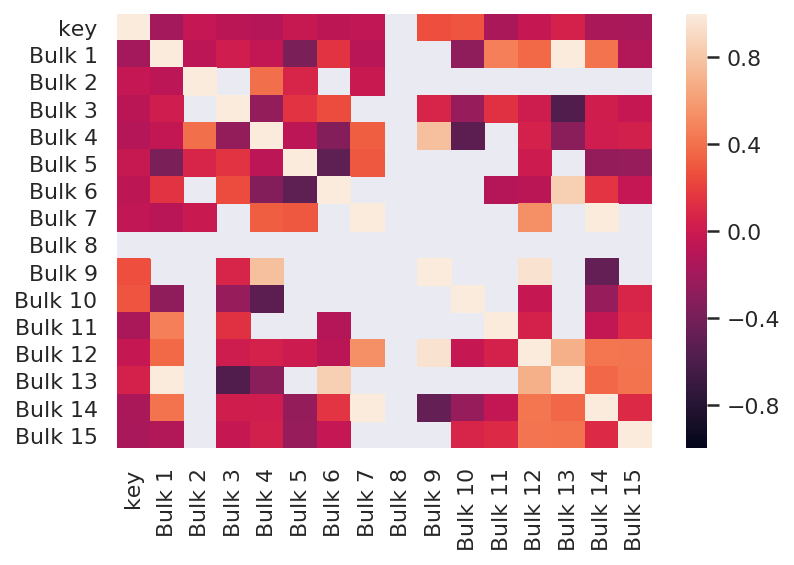

In [24]:
#загрузим данные об объеме сыпучих веществ
display_info(name=bulk,  head=5, tail=5, shape=1, info=1, nan=1, describe=1, duplicate=1, unique=1, corr=0, corr_map=-1)

### Вывод 
* Всего 3129 кейсов.
* 15 видов сыпучих примесей.
* Уникальных партий 3129 , что меньше чем в первом файле. Возможно сыпучие вещества добавлялись необходимы не для всех партий.
* Очень много пустых значений - логично, так как не все виды примесей используются для каждой партии - заменим пропуски нулями.
* Зависимости между определенными сыпучими веществами также логична, так как для опеределенного вида стали используют определенный состав примесей.

[К содержанию](#top)

#### Анализ данных о времени подачи сыпучих веществ <a name="bulk_time"></a>


 HEAD 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56



 TAIL 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 04:05:34,2019-09-01 04:05:34



 SHAPE 



(3129, 16)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


None


 NAN, % 



key        0.00
Bulk 1    91.95
Bulk 2    99.30
Bulk 3    58.52
Bulk 4    67.59
Bulk 5    97.54
Bulk 6    81.59
Bulk 7    99.20
Bulk 8    99.97
Bulk 9    99.39
Bulk 10   94.38
Bulk 11   94.34
Bulk 12   21.70
Bulk 13   99.42
Bulk 14   10.32
Bulk 15   28.16
dtype: float64


 UNIQUE 



key        3129
Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 8        1
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64


 UNUNIQUE 



key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


 DUPLICATES 



0


 CORR_MAP 



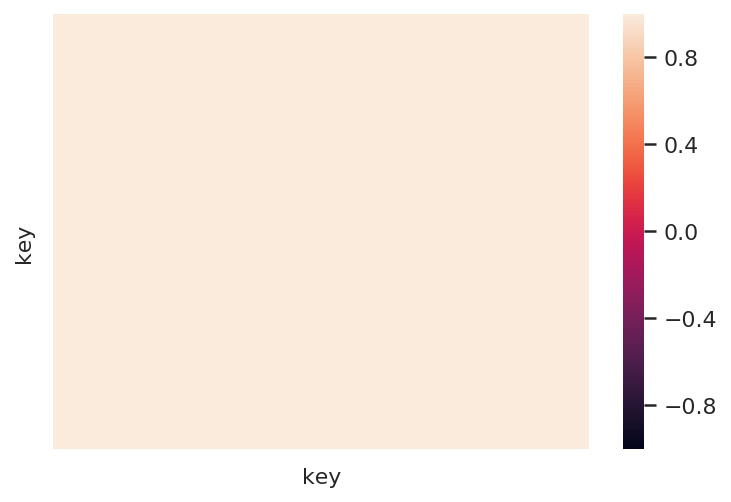

In [25]:
#загрузим данные о времени подачи сыпучих веществ
display_info(name=bulk_time,  head=5, tail=5, shape=1, info=1, nan=1, describe=0, duplicate=1, unique=1, corr=0, corr_map=-1)

### Вывод  

* Картина совпадает со данными об объемах сыпучих веществ.
* Такое же количество уникальных ключей.
* Однако после беседы с тимлидом стало известно, информация о времени подачи нам неважна. Для фичей ее использвать не будет. Возможно она понадобится для промежуточных рассчетов.

[К содержанию](#top)

#### Анализ данных о продувке сплава газом <a name="gas"></a>

In [26]:
#загрузим данные о продувке сплава газом
display_info(name=gas,  head=5, tail=5, shape=1, info=1, nan=1, describe=1, duplicate=1, unique=1, corr=1, corr_map='None')


 HEAD 



,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41



 TAIL 



,key,Газ 1
3234,3237,5.54
3235,3238,6.75
3236,3239,16.02
3237,3240,11.86
3238,3241,12.68



 SHAPE 



(3239, 2)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


 NAN, % 



key     0.00
Газ 1   0.00
dtype: float64


 UNIQUE 



key      3239
Газ 1    3239
dtype: int64


 UNUNIQUE 



key      0
Газ 1    0
dtype: int64


 DESCRIBE 



,count,mean,std,min,25%,50%,75%,max
key,3239.00,1621.86,935.39,1.00,812.50,1622.00,2431.50,3241.00
Газ 1,3239.00,11.00,6.22,0.01,7.04,9.84,13.77,78.00



 DUPLICATES 



0


 CORR 



,key,Газ 1
key,1.00,-0.04
Газ 1,-0.04,1.00


<Figure size 1440x576 with 0 Axes>

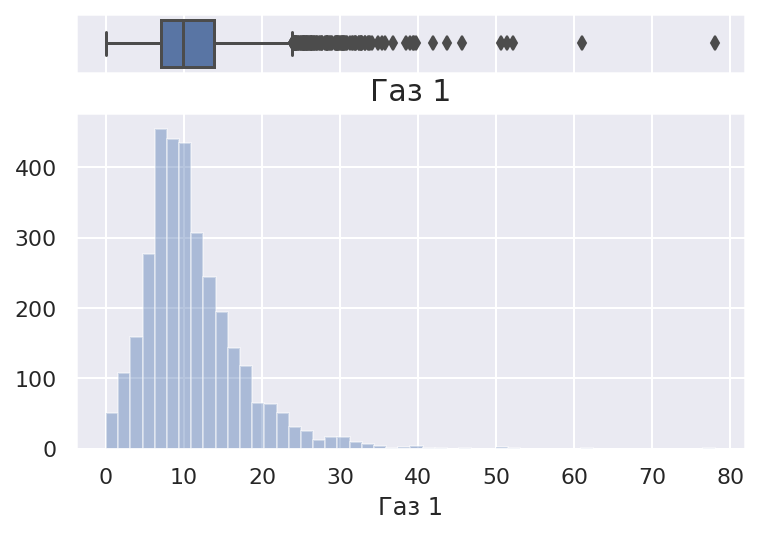

In [27]:
#посмотрим еще раз на распределение
sns_hist_box(df = gas,
             columns =['Газ 1'],
             x_figsize=20, y_figsize=8,
             n_bins=50,
             x_rot =0,
             title=1,
             label="None", legend=0,
             ylabel = 0
            )

### Вывод  

* Пустых значений нет.
* Количество уникальных ключей (партий) 3239. Больше чем в таблице с замерами температуры на 15 партий, возможно тот лаг в замрах, которых был обнаружен ранее и должен был содержать информацию по отсутствующим партиям. Возможно мощность по таким партиям установим как 0, если это потребуетсяю
* Данные имеюют корректный тип.
* Имеются выбросы, но мы не будем с этим ничего делать, так как возможно это технологические особенности.

[К содержанию](#top)

#### Анализ данных о результатах измерения температур <a name="temp"></a>

In [28]:
#загрузим данные о результатх измерения температур
display_info(name=temp,  head=5, tail=20, shape=1, info=1, nan=1, describe=1, duplicate=1, unique=1, corr=1, corr_map='None')


 HEAD 



,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00



 TAIL 



,key,Время замера,Температура
15887,3239,2019-09-01 01:42:46,nan
15888,3239,2019-09-01 01:48:00,nan
15889,3239,2019-09-01 01:59:27,nan
15890,3239,2019-09-01 02:13:30,nan
15891,3239,2019-09-01 02:22:15,nan
15892,3239,2019-09-01 02:23:02,nan
15893,3239,2019-09-01 02:24:15,nan
15894,3240,2019-09-01 02:39:01,1617.00
15895,3240,2019-09-01 02:48:33,nan
15896,3240,2019-09-01 03:03:21,nan



 SHAPE 



(15907, 3)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null datetime64[ns]
Температура     13006 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


None


 NAN, % 



key             0.00
Время замера    0.00
Температура    18.24
dtype: float64


 UNIQUE 



key              3216
Время замера    15907
Температура       175
dtype: int64


 UNUNIQUE 



key             12691
Время замера        0
Температура     15732
dtype: int64


 DESCRIBE 



,count,mean,std,min,25%,50%,75%,max
key,15907.00,1607.88,942.21,1.00,790.00,1618.00,2427.00,3241.00
Температура,13006.00,1591.84,21.38,1191.00,1581.00,1591.00,1601.00,1705.00



 DUPLICATES 



0


 CORR 



,key,Температура
key,1.00,-0.05
Температура,-0.05,1.00


<Figure size 1440x576 with 0 Axes>

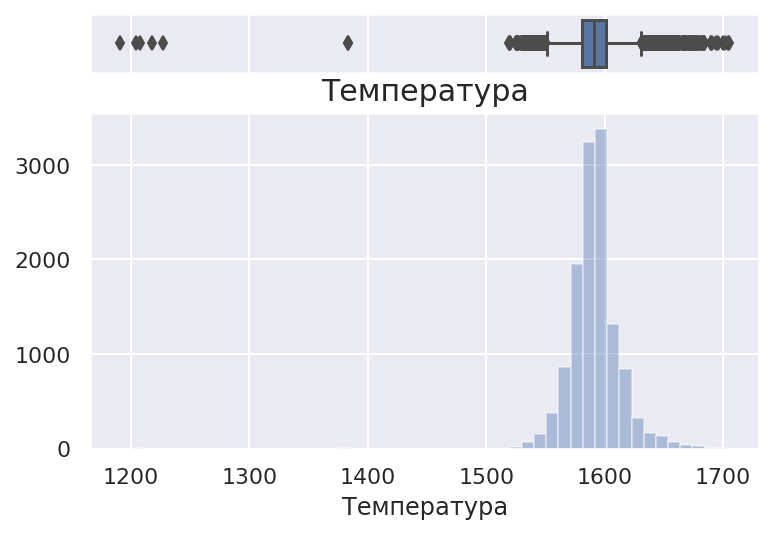

In [29]:
#посмотрим еще раз на распределение
sns_hist_box(temp,
             columns =['Температура'],
             x_figsize=20, y_figsize=8,
             n_bins=50,
             x_rot =0,
             title=1,
             label="None", legend=0,
             ylabel = 0
            )

### Вывод  

* Данные имею корректный тип.
* 18% информации о замеренной температуре отсутствует - если это пропуски по последней тепературе, кдалим, так как нам нужны известные данные для целевого признака.
* Количество уникальных ключей (партий) 3216 - опять же меньше, чем в таблице с газом, и на 2 партии меньше, чем в таблице со временем агрева.
* Имеются выбросы, но мы не будем с этим ничего делать, чтобы неидеализировать данные для обучения модели - вдруг выбросы это последние замеры.

[К содержанию](#top)

#### Анализ данных об объеме проволочных материалов <a name="wire"></a>


 HEAD 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.05,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.16,nan,nan,nan,nan,nan,nan,nan,nan
3,4,89.06,nan,nan,nan,nan,nan,nan,nan,nan
4,5,89.24,9.11,nan,nan,nan,nan,nan,nan,nan



 TAIL 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.09,nan,nan,nan,nan,nan,nan,nan,nan
3077,3238,56.13,nan,nan,nan,nan,nan,nan,nan,nan
3078,3239,143.36,nan,nan,nan,nan,nan,nan,nan,nan
3079,3240,34.07,nan,nan,nan,nan,nan,nan,nan,nan
3080,3241,63.12,nan,nan,nan,nan,nan,nan,nan,nan



 SHAPE 



(3081, 10)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


 NAN, % 



key       0.00
Wire 1    0.84
Wire 2   64.98
Wire 3   97.96
Wire 4   99.55
Wire 5   99.97
Wire 6   97.63
Wire 7   99.64
Wire 8   99.38
Wire 9   99.06
dtype: float64


 UNIQUE 



key       3081
Wire 1    2269
Wire 2     713
Wire 3      56
Wire 4      14
Wire 5       1
Wire 6      70
Wire 7      10
Wire 8      13
Wire 9      25
dtype: int64


 UNUNIQUE 



key          0
Wire 1     812
Wire 2    2368
Wire 3    3025
Wire 4    3067
Wire 5    3080
Wire 6    3011
Wire 7    3071
Wire 8    3068
Wire 9    3056
dtype: int64


 DESCRIBE 



,count,mean,std,min,25%,50%,75%,max
key,3081.00,1623.43,933.00,1.00,823.00,1619.00,2434.00,3241.00
Wire 1,3055.00,100.90,42.01,1.92,72.12,100.16,126.06,330.31
Wire 2,1079.00,50.58,39.32,0.03,20.19,40.14,70.23,282.78
Wire 3,63.00,189.48,99.51,0.14,95.14,235.19,276.25,385.01
Wire 4,14.00,57.44,28.82,24.15,40.81,45.23,76.12,113.23
Wire 5,1.00,15.13,nan,15.13,15.13,15.13,15.13,15.13
Wire 6,73.00,48.02,33.92,0.03,25.05,42.08,64.21,180.45
Wire 7,11.00,10.04,8.61,0.23,6.76,9.02,11.89,32.85
Wire 8,19.00,53.63,16.88,45.08,46.09,46.28,48.09,102.76
Wire 9,29.00,34.16,19.93,4.62,22.06,30.07,43.86,90.05



 DUPLICATES 



0


 CORR_MAP 



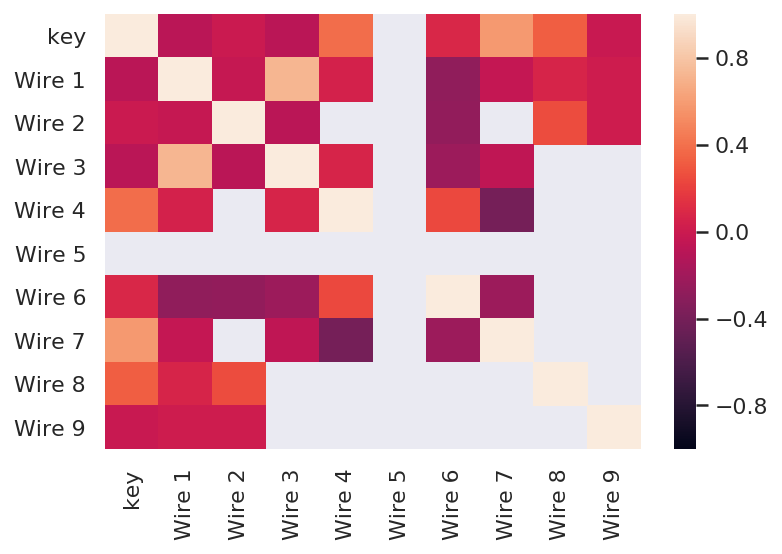

In [30]:
#загрузим данные об объеме проволочных материалов
display_info(name=wire,  head=5, tail=5, shape=1, info=1, nan=1, describe=1, duplicate=1, unique=1, corr=0, corr_map=-1)

In [31]:
#сразу удалим пустой бункер, чтобы потом не забыть
wire = wire.drop(['Wire 5'], axis=1)
data['wire'] = wire
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(8), int64(1)
memory usage: 216.8 KB


### Вывод 
* Всего 3081 кейсов. Меньше чем партий в таблице нагрева. Так же как и для сыпучих веществ верно утверждение о том, что проволока добавлялась не для всех партий, что также объясняет многочисленные пропуски.
* 9 видов бункеров с проволокой.
* Зависимости между определенными бункерами логична, так как для опеределенного вида стали используют определенный состав примесей.
* Из бункера 5 ниразу не добавлялась проволака - удалили его.

[К содержанию](#top)

#### Анализ данных о времени подачи проволочных материалов <a name="wire_time"></a>

In [32]:
#загрузим данные о времени подачи проволочных материалов
display_info(name=wire_time,  head=5, tail=5, shape=1, info=1, nan=1, describe=0, duplicate=1, unique=1, corr=0, corr_map='None')


 HEAD 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT



 TAIL 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-01 04:16:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT



 SHAPE 



(3081, 10)


 INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire 3    63 non-null datetime64[ns]
Wire 4    14 non-null datetime64[ns]
Wire 5    1 non-null datetime64[ns]
Wire 6    73 non-null datetime64[ns]
Wire 7    11 non-null datetime64[ns]
Wire 8    19 non-null datetime64[ns]
Wire 9    29 non-null datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None


 NAN, % 



key       0.00
Wire 1    0.84
Wire 2   64.98
Wire 3   97.96
Wire 4   99.55
Wire 5   99.97
Wire 6   97.63
Wire 7   99.64
Wire 8   99.38
Wire 9   99.06
dtype: float64


 UNIQUE 



key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63
Wire 4      14
Wire 5       1
Wire 6      73
Wire 7      11
Wire 8      19
Wire 9      29
dtype: int64


 UNUNIQUE 



key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


 DUPLICATES 



0

### Вывод  

* Картина совпадает со данными об объемах проволочных составляющих.
* Такое же количество уникальных ключей как и для таблицы объемов.
* Однако после беседы с тимлидом стало известно, информация о времени подачи примесей нам неважна. Для фичей ее использвать не будет. Возможно она понадобится для промежуточных рассчетов.

[К содержанию](#top)

## Вывод <a name="вывод"></a>

По итогам исследовательского анализа данных определим действия, необходимые для предобработки данных:
- рассчитаем дополнительные показатели по мощностям;
- проверим, время замера температуры и время нагрева по каждой партии - удалим те, что были замерены во время или до нагрева;
- промежуточные температуры удалим, они не влияют на результат, на итоговую температуру;
- время подачи материалов и проволки также не будем использовать, главное объем этих веществ;
- почистим пустые значения температур;
- удалим партии, где есть только одна замеренная температура;
- создадим признаки (первая температура, мощности, объем добавленных веществ, газ) и целевой (последняя температура).

[К содержанию](#top)

### 2. Предобработка данных <a name="Предобработка"></a>

Переименуем все столбцы, будем использовать только латинские прописные буквы, пробелы земеним знаком подчеркивания

In [33]:
arc.set_axis(['key','heating_bg','heating_end', 'active_energy', 'reactive_energy'],axis = 'columns',inplace = True)
temp.set_axis(['key','temp_time','temp'],axis = 'columns',inplace = True)
gas.set_axis(['key','gas'],axis = 'columns',inplace = True)
bulk.set_axis(list(bulk.columns.str.lower().str.replace(' ', '_')),axis = 'columns',inplace = True)
bulk_time.set_axis(list(bulk_time.columns.str.lower().str.replace(' ', '_')),axis = 'columns',inplace = True)
wire.set_axis(list(wire.columns.str.lower().str.replace(' ', '_')),axis = 'columns',inplace = True)
wire_time.set_axis(list(wire_time.columns.str.lower().str.replace(' ', '_')),axis = 'columns',inplace = True)

In [34]:
#проверим как прошла замена названий столбцов
for df in data.keys():
    print(data[df].columns)

Index(['key', 'heating_bg', 'heating_end', 'active_energy', 'reactive_energy'], dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')
Index(['key', 'gas'], dtype='object')
Index(['key', 'temp_time', 'temp'], dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9'],
      dtype='object')
Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')


<b>Проверим какие замеры последней температуры были произведены раньше либо во время нагревания стали</b>

In [35]:
#из таблицы с нагревами выделим время начала первого и окончания последнего замера
arc_time = arc.groupby('key').agg({'heating_bg':'min', 'heating_end':'max'})
arc_time

,heating_bg,heating_end
key,,
1,2019-05-03 11:02:14,2019-05-03 11:28:37
2,2019-05-03 11:34:14,2019-05-03 11:53:18
3,2019-05-03 12:06:54,2019-05-03 12:32:19
4,2019-05-03 12:39:37,2019-05-03 12:57:50
5,2019-05-03 13:11:13,2019-05-03 13:33:55
...,...,...
3237,2019-08-31 22:41:18,2019-08-31 23:03:48
3238,2019-08-31 23:26:18,2019-08-31 23:41:28
3239,2019-09-01 01:26:53,2019-09-01 02:15:43


<b>Сортируем замеренные температуры по времени замера:</b>
- До нагревания
- Во время нагревания
- После нагревания

In [36]:
#функция для сортировки
def heating_time(df):
    i = df['key']
    time = df['temp_time'] 
    if i in arc_time.index.values:
        if time < arc_time.loc[i]['heating_bg']:
            return "До нагревания"
        if (arc_time.loc[i]['heating_bg'] <= time) and (time <= arc_time.loc[i]['heating_end']):
            return "Во время нагревания"
        if arc_time.loc[i]['heating_end'] < time:
            return "После нагревания"
    return "Неизвестно"

#применяем 
temp['heating_time'] = temp.apply(heating_time, axis=1)

In [37]:
#посмотрим глазами, когда были замерены различные температуры
temp['heating_time'].value_counts()

Во время нагревания    11238
После нагревания        4605
До нагревания             62
Неизвестно                 2
Name: heating_time, dtype: int64

<b>Подготовим данные температур. Определим последнюю и первую температуры</b>

In [38]:
#посмотри есть ли партии с одной единственной температурой
temp['key'].value_counts(ascending=True)

195      1
279      1
3156     2
1424     2
1106     2
        ..
1689    15
46      16
1513    16
1214    16
44      16
Name: key, Length: 3216, dtype: int64

In [39]:
#да такие партии есть, удалим их
temp = temp.loc[(temp['key'] != 195) & (temp['key'] != 279)]
temp['key'].value_counts(ascending=False)

44      16
46      16
1513    16
1214    16
2108    15
        ..
151      2
2423     2
273      2
3033     2
800      2
Name: key, Length: 3214, dtype: int64

In [40]:
#выберем только первую и последнюю температуры
temp_info = pd.DataFrame()

temp_info['start_time'] = temp.sort_values('temp_time').groupby('key').first()['temp_time']
temp_info['end_time'] = temp.sort_values('temp_time').groupby('key').last()['temp_time']
temp_info['start_temp'] = temp.sort_values('temp_time').groupby('key').first()['temp']
temp_info['end_temp'] = temp.sort_values('temp_time').groupby('key').last()['temp']
temp_info['start_heating_time'] = temp.sort_values('temp_time').groupby('key').first()['heating_time']
temp_info['end_heating_time'] = temp.sort_values('temp_time').groupby('key').last()['heating_time']
temp_info.head()

,start_time,end_time,start_temp,end_temp,start_heating_time,end_heating_time
key,,,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.00,1613.00,Во время нагревания,После нагревания
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.00,1602.00,Во время нагревания,После нагревания
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.00,1599.00,Во время нагревания,После нагревания
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.00,1625.00,Во время нагревания,После нагревания
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.00,1602.00,Во время нагревания,После нагревания


In [41]:
temp_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 6 columns):
start_time            3214 non-null datetime64[ns]
end_time              3214 non-null datetime64[ns]
start_temp            3214 non-null float64
end_temp              3214 non-null float64
start_heating_time    3214 non-null object
end_heating_time      3214 non-null object
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 175.8+ KB


In [42]:
#удалим те партии, где совпадают температуры, будем считать что это случаи с одним единственным замером, такие нам не подходят
temp_info['diff_tеmp'] = temp_info['end_temp'] - temp_info['start_temp']
temp_info = temp_info[temp_info['diff_tеmp'] != 0]
temp_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 1 to 2499
Data columns (total 7 columns):
start_time            2433 non-null datetime64[ns]
end_time              2433 non-null datetime64[ns]
start_temp            2433 non-null float64
end_temp              2433 non-null float64
start_heating_time    2433 non-null object
end_heating_time      2433 non-null object
diff_tеmp             2433 non-null float64
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 152.1+ KB


In [43]:
#посмотрим есть ли партии, последняя температура которых была замерена до или во время нагревания, 
#а первая вовремя либо после нагрева
print(color.BOLD + color.RED + 'последняя температура' + color.END,
      temp_info['end_heating_time'].value_counts(normalize=True), sep='\n')

последняя температура
После нагревания      0.95
Во время нагревания   0.05
Name: end_heating_time, dtype: float64


In [44]:
#удалим те партии, где последняя температура была замерена до или во время нагревания
temp_info = temp_info[temp_info['end_heating_time'] != 'Во время нагревания']
print(color.BOLD + color.RED + 'последняя температура' + color.END,
      temp_info['end_heating_time'].value_counts(normalize=True), sep='\n')

последняя температура
После нагревания   1.00
Name: end_heating_time, dtype: float64


In [45]:
#добавим признак "время между первым и последним замерами"
temp_info['full_time'] = (temp_info['end_time'] - temp_info['start_time']).dt.seconds
temp_info.tail()

,start_time,end_time,start_temp,end_temp,start_heating_time,end_heating_time,diff_tеmp,full_time
key,,,,,,,,
2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.00,1591.00,Во время нагревания,После нагревания,21.00,1137
2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.00,1591.00,Во время нагревания,После нагревания,37.00,1618
2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.00,1589.00,Во время нагревания,После нагревания,18.00,717
2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.00,1594.00,Во время нагревания,После нагревания,3.00,1302
2499,2019-08-06 02:40:25,2019-08-06 03:00:28,1569.00,1603.00,Во время нагревания,После нагревания,34.00,1203


In [46]:
temp_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 1 to 2499
Data columns (total 8 columns):
start_time            2303 non-null datetime64[ns]
end_time              2303 non-null datetime64[ns]
start_temp            2303 non-null float64
end_temp              2303 non-null float64
start_heating_time    2303 non-null object
end_heating_time      2303 non-null object
diff_tеmp             2303 non-null float64
full_time             2303 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 161.9+ KB


<b>Добавим расчетные величины для показателя "мощность"</b>

In [47]:
#определим скорость скорость нагревания каждой итерации
arc['diff_heating_time'] = (arc['heating_end'] - arc['heating_bg']).dt.seconds
#рассчитаем отношение реактивной и активной мощностей по каждой итерации
arc['ratio_r_a_energy'] = arc['reactive_energy'] / arc['active_energy']
#рассчитаем физическую величину "полная мощность"
arc['full_energy'] = (arc['active_energy'] ** 2 + arc['reactive_energy'] ** 2) ** 0.5
arc.head()

,key,heating_bg,heating_end,active_energy,reactive_energy,diff_heating_time,ratio_r_a_energy,full_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69,228,0.70,1.19
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52,185,0.65,0.96
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50,172,0.67,0.90
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06,365,0.64,1.97
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41,148,0.60,0.81


In [48]:
arc.columns

Index(['key', 'heating_bg', 'heating_end', 'active_energy', 'reactive_energy',
       'diff_heating_time', 'ratio_r_a_energy', 'full_energy'],
      dtype='object')

In [128]:
#рассчитаем суммы и среднее по каждому столбцу данных
arc_pivot = arc.pivot_table(index='key',
                            values=['active_energy', 'reactive_energy', 'diff_heating_time', 'ratio_r_a_energy', 'full_energy'],
                           aggfunc = ['mean','sum'])
#переименуем столбцы
arc_pivot.columns = ["_".join((j,k)) for j,k in arc_pivot.columns]
arc_pivot.columns

Index(['mean_active_energy', 'mean_diff_heating_time', 'mean_full_energy',
       'mean_ratio_r_a_energy', 'mean_reactive_energy', 'sum_active_energy',
       'sum_diff_heating_time', 'sum_full_energy', 'sum_ratio_r_a_energy',
       'sum_reactive_energy'],
      dtype='object')

In [127]:
#оставим интересующие нас параметры
arc_pivot = arc_pivot.loc[:, ['mean_active_energy','mean_reactive_energy', 'mean_full_energy', 
                              'mean_ratio_r_a_energy', 'mean_diff_heating_time', 'sum_diff_heating_time']]
arc_pivot.head()

,mean_active_energy,mean_reactive_energy,mean_full_energy,mean_ratio_r_a_energy,mean_diff_heating_time,sum_diff_heating_time
key,,,,,,
1,nan,0.64,nan,0.65,nan,1098
2,nan,0.50,nan,0.65,nan,811
3,nan,0.32,nan,0.63,nan,655
4,nan,0.52,nan,0.64,nan,741
5,nan,0.56,nan,0.68,nan,869


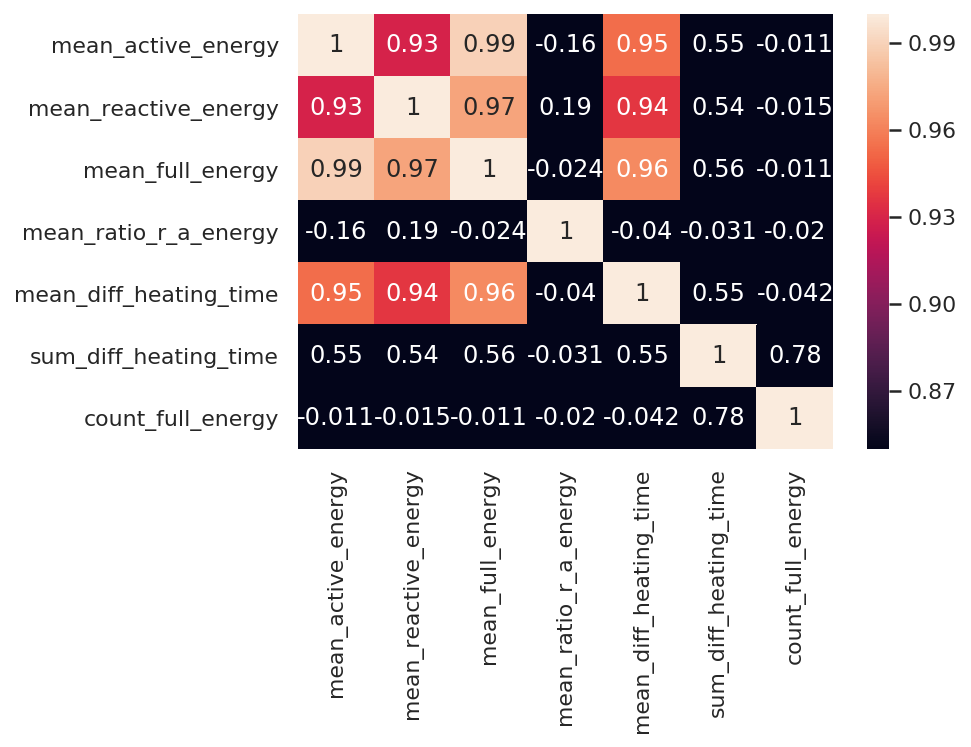

In [122]:
#посмотрим на корреляцию этих признаков
sns.heatmap(arc_pivot.corr(), annot=True, vmin=0.85)

<b>Сперва уберем мультиколлинеарность mean_diff_heating_time, так как он имеет большую зависимость с другими признаками чем суммарное время нагрева. Удалим полную мощность из таблицы - они показывает слишком высокую корреляцию. А также избавимся от активной средний мощности.</b>

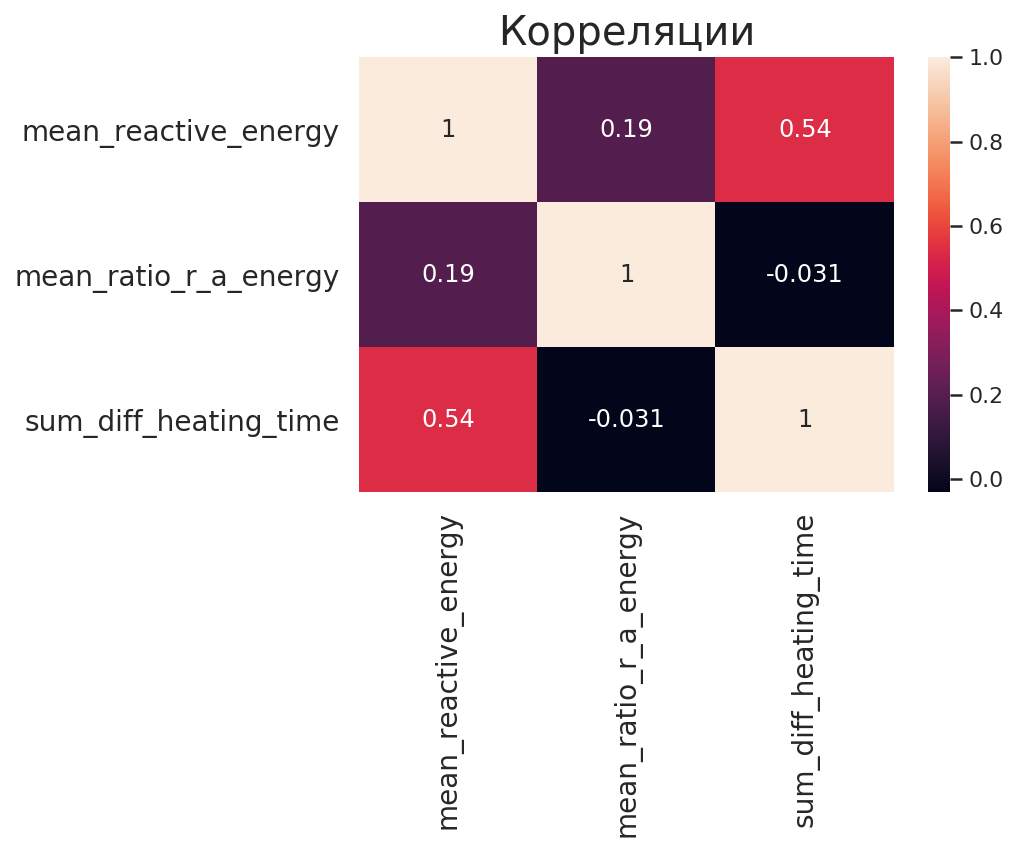

In [126]:
arc_pivot = arc_pivot.loc[:, ['mean_reactive_energy', 'mean_ratio_r_a_energy', 'sum_diff_heating_time']]
sns.heatmap(arc_pivot.corr(), annot=True,
            #vmin=0.85
           )
plt.title("Корреляции", fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

<b>Подготовим табилицы с примесями. Заменим все NaN нулями, будем считать, что вещество из данного бункера не добавлялось в смесь</b>

In [53]:
bulk = bulk.fillna(0)
bulk = bulk.set_index('key')
display(bulk.tail())

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
3237,0.00,0.00,170.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,252.00,0.00,130.00,206.00
3238,0.00,0.00,126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,254.00,0.00,108.00,106.00
3239,0.00,0.00,0.00,0.00,0.00,114.00,0.00,0.00,0.00,0.00,0.00,158.00,0.00,270.00,88.00
3240,0.00,0.00,0.00,0.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,192.00,54.00
3241,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,180.00,52.00


In [54]:
wire = wire.fillna(0)
wire = wire.set_index('key')
display(wire.tail())

,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,
3237,38.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3238,56.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3239,143.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3240,34.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3241,63.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [55]:
gas = gas.set_index('key')
display(gas.tail())

,gas
key,
3237,5.54
3238,6.75
3239,16.02
3240,11.86
3241,12.68


In [56]:
dfs = [temp_info, arc_pivot, bulk, wire, gas]
def print_shape(datas):
    return datas.shape
for df in dfs:
    print(print_shape(df))

(2303, 8)
(3214, 3)
(3129, 15)
(3081, 8)
(3239, 1)


<b>Подготовим итоговую таблицу с признаками для обучения модели</b>

In [57]:
#создадим список с целевыми партиями
target_keys = temp_info.index

In [58]:
temp_info = temp_info.loc[:, ['start_temp', 'end_temp', 'full_time']]
arc_pivot = arc_pivot.query('key in @target_keys')
bulk = bulk.query('key in @target_keys')
wire = wire.query('key in @target_keys')
gas = gas.query('key in @target_keys')

In [59]:
dfs = [temp_info, arc_pivot, bulk, wire, gas]
def print_shape(datas):
    return datas.shape
for df in dfs:
    print(print_shape(df))

(2303, 3)
(2303, 3)
(2242, 15)
(2215, 8)
(2301, 1)


Видим, что 2 партии не продувались газом, это противоречит технологии, удалим такие партии. Пропуски по добавляемым смесям заполним нулями

In [60]:
#Объеденим таблицы с признаками в одну
features = pd.concat([temp_info, arc_pivot, bulk, wire, gas], axis=1)

In [61]:
features[features['gas'].isna()]

,start_temp,end_temp,full_time,mean_reactive_energy,mean_ratio_r_a_energy,sum_diff_heating_time,bulk_1,bulk_2,bulk_3,bulk_4,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,gas
key,,,,,,,,,,,,,,,,,,,,,
193,1593.00,1595.00,2487,0.50,0.73,1040,0.00,0.00,0.00,192.00,...,204.00,122.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
259,1577.00,1590.00,1080,0.56,0.82,717,0.00,0.00,0.00,0.00,...,103.00,55.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan


In [62]:
features = features.dropna(subset=['gas'])

In [63]:
display(features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 1 to 2499
Data columns (total 30 columns):
start_temp               2301 non-null float64
end_temp                 2301 non-null float64
full_time                2301 non-null int64
mean_reactive_energy     2301 non-null float64
mean_ratio_r_a_energy    2301 non-null float64
sum_diff_heating_time    2301 non-null int64
bulk_1                   2240 non-null float64
bulk_2                   2240 non-null float64
bulk_3                   2240 non-null float64
bulk_4                   2240 non-null float64
bulk_5                   2240 non-null float64
bulk_6                   2240 non-null float64
bulk_7                   2240 non-null float64
bulk_8                   2240 non-null float64
bulk_9                   2240 non-null float64
bulk_10                  2240 non-null float64
bulk_11                  2240 non-null float64
bulk_12                  2240 non-null float64
bulk_13                  2240 non-null float64
bulk

None

In [64]:
features = features.fillna(0)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301 entries, 1 to 2499
Data columns (total 30 columns):
start_temp               2301 non-null float64
end_temp                 2301 non-null float64
full_time                2301 non-null int64
mean_reactive_energy     2301 non-null float64
mean_ratio_r_a_energy    2301 non-null float64
sum_diff_heating_time    2301 non-null int64
bulk_1                   2301 non-null float64
bulk_2                   2301 non-null float64
bulk_3                   2301 non-null float64
bulk_4                   2301 non-null float64
bulk_5                   2301 non-null float64
bulk_6                   2301 non-null float64
bulk_7                   2301 non-null float64
bulk_8                   2301 non-null float64
bulk_9                   2301 non-null float64
bulk_10                  2301 non-null float64
bulk_11                  2301 non-null float64
bulk_12                  2301 non-null float64
bulk_13                  2301 non-null float64
bulk

<b>Разобьем фичи на целевую и обучающие</b>

In [65]:
target = features.loc[:, "end_temp"]
features = features.drop('end_temp', axis=1)
display(target.shape, features.shape)

(2301,)

(2301, 29)

<b>Посмотрим нет ли мультиколлинеарности между факторами</b>

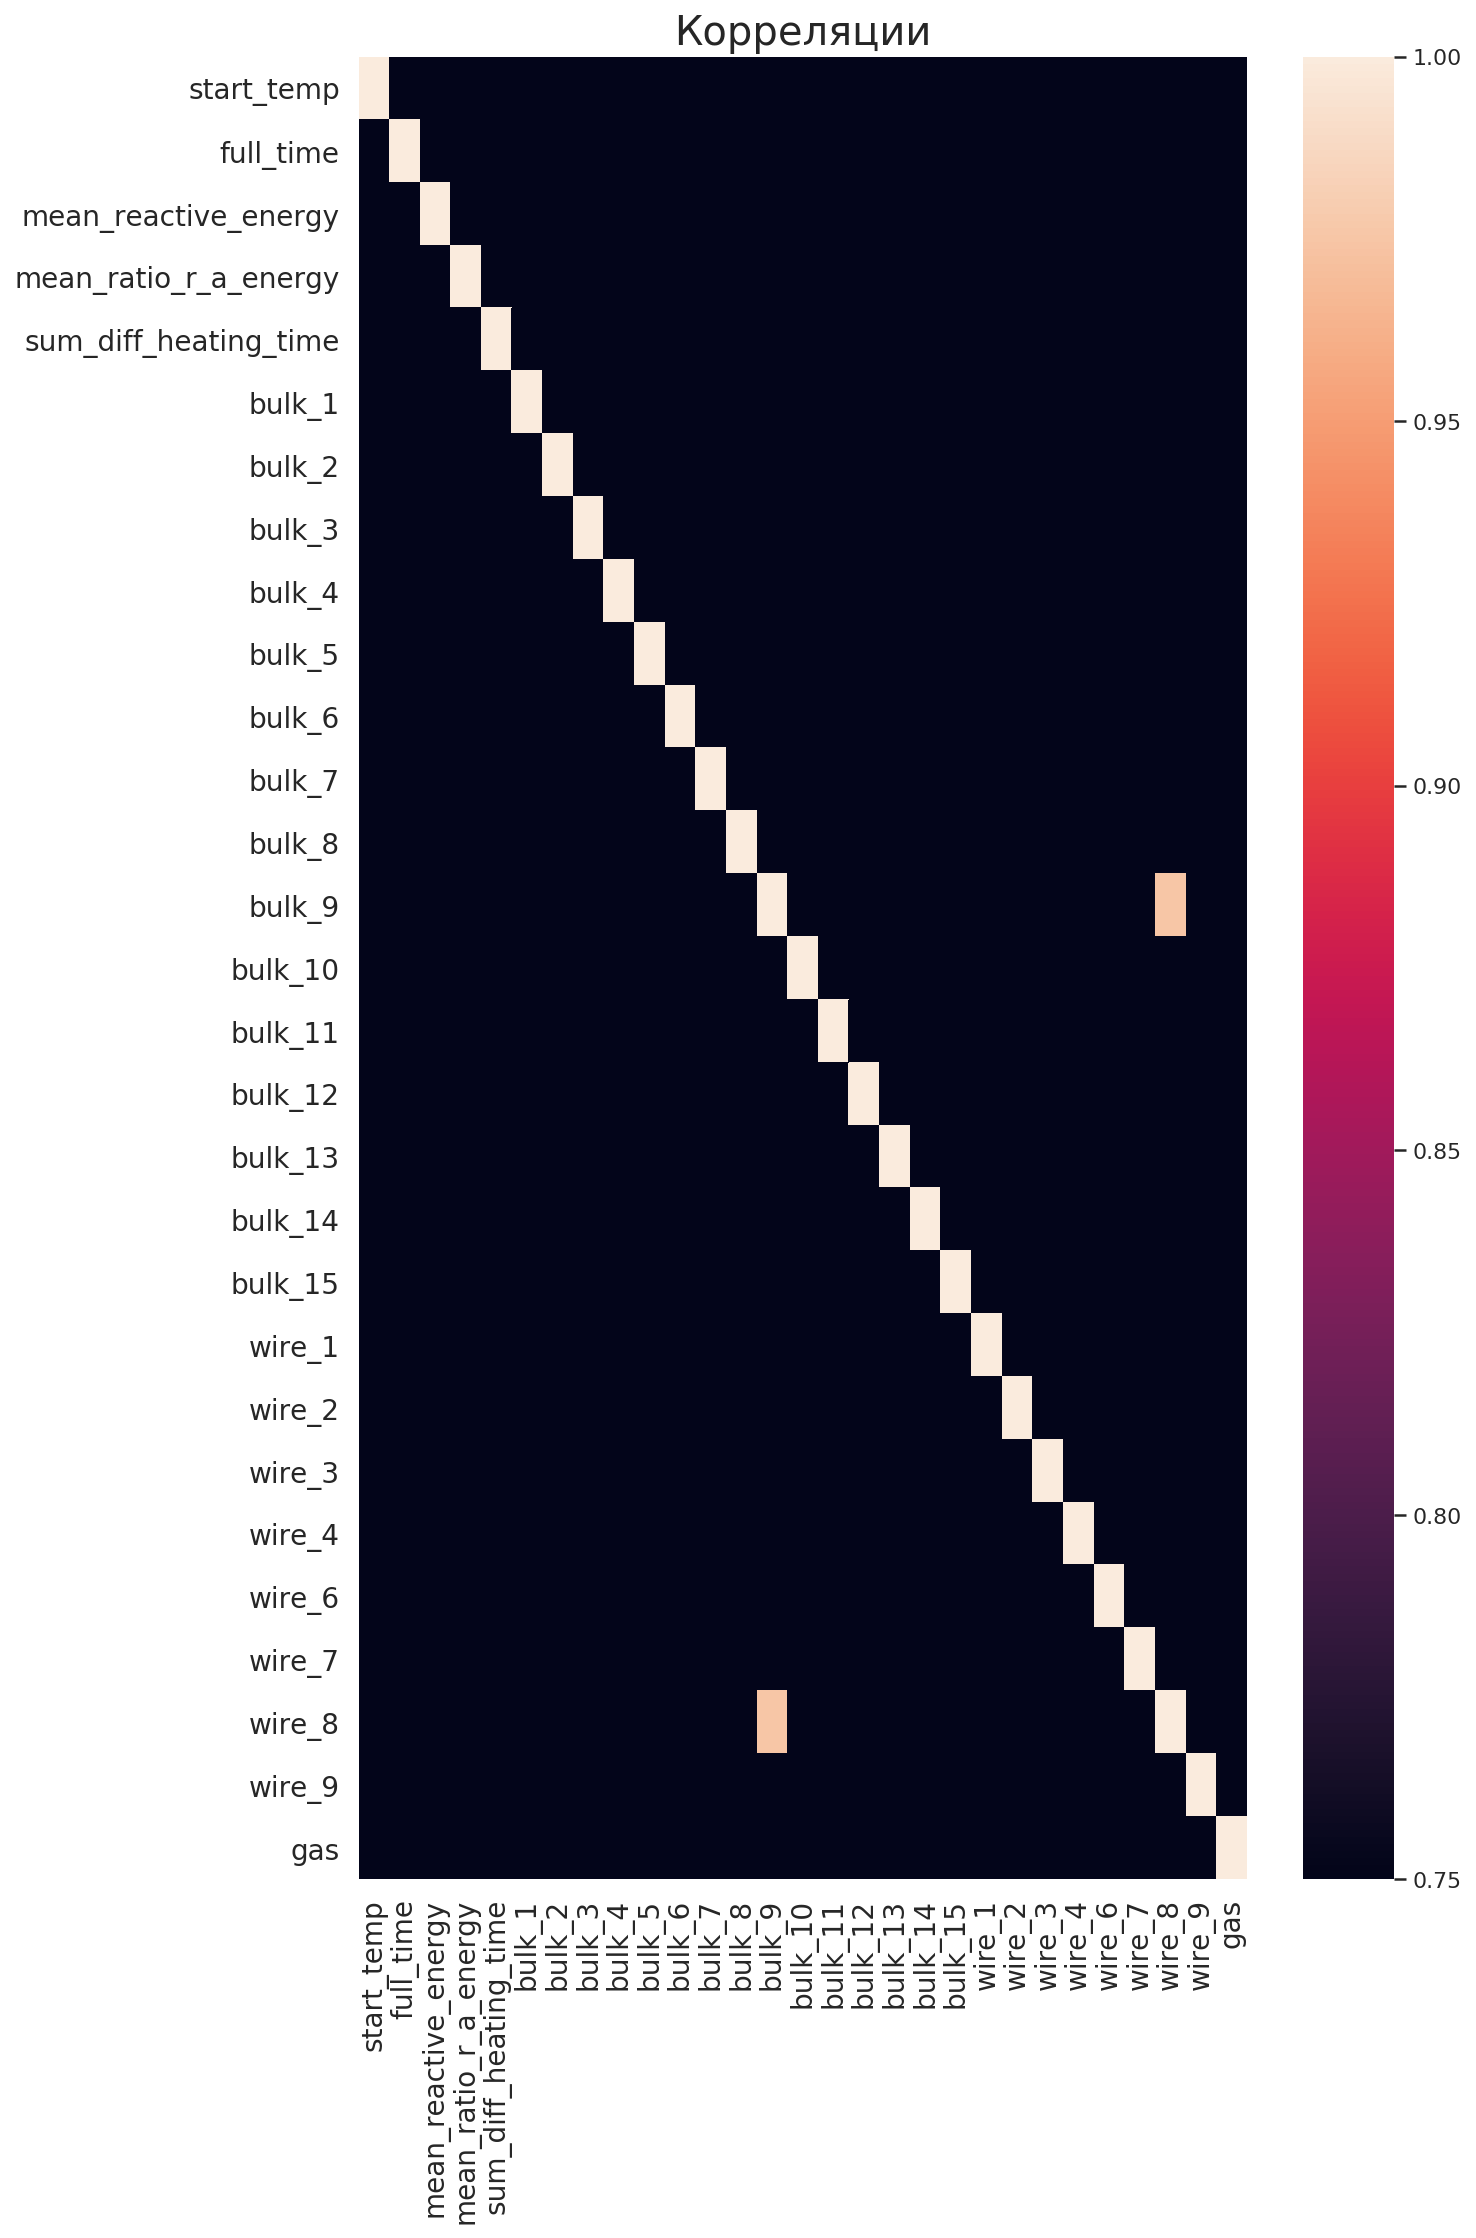

In [66]:
plt.figure(figsize=(10, 15))
sns.heatmap(features.corr(),
            fmt='.2g',
            vmin=0.75)
plt.tight_layout()
plt.title("Корреляции", fontsize=20)
plt.tick_params(labelsize=14)

plt.show()

<b>Наблюдается мультиколлинеарность между признаками wire 8 и bulk 9. После проведения анализа на значимость признаков, определим, какой из них можно удалить.</b>

In [67]:
#рассчитаем значимость каждого признака
model_import = ExtraTreesClassifier(n_estimators=250, random_state = 12345)
model_import.fit(features, target)
importance_data = pd.DataFrame(data = model_import.feature_importances_, index=features.columns, columns=['Importance'])
importance_data = importance_data.sort_values(by='Importance')
display(importance_data)

,Importance
bulk_8,0.00
wire_7,0.00
bulk_2,0.00
wire_4,0.00
wire_8,0.00
bulk_7,0.00
bulk_9,0.00
bulk_13,0.00
wire_3,0.00
wire_9,0.00


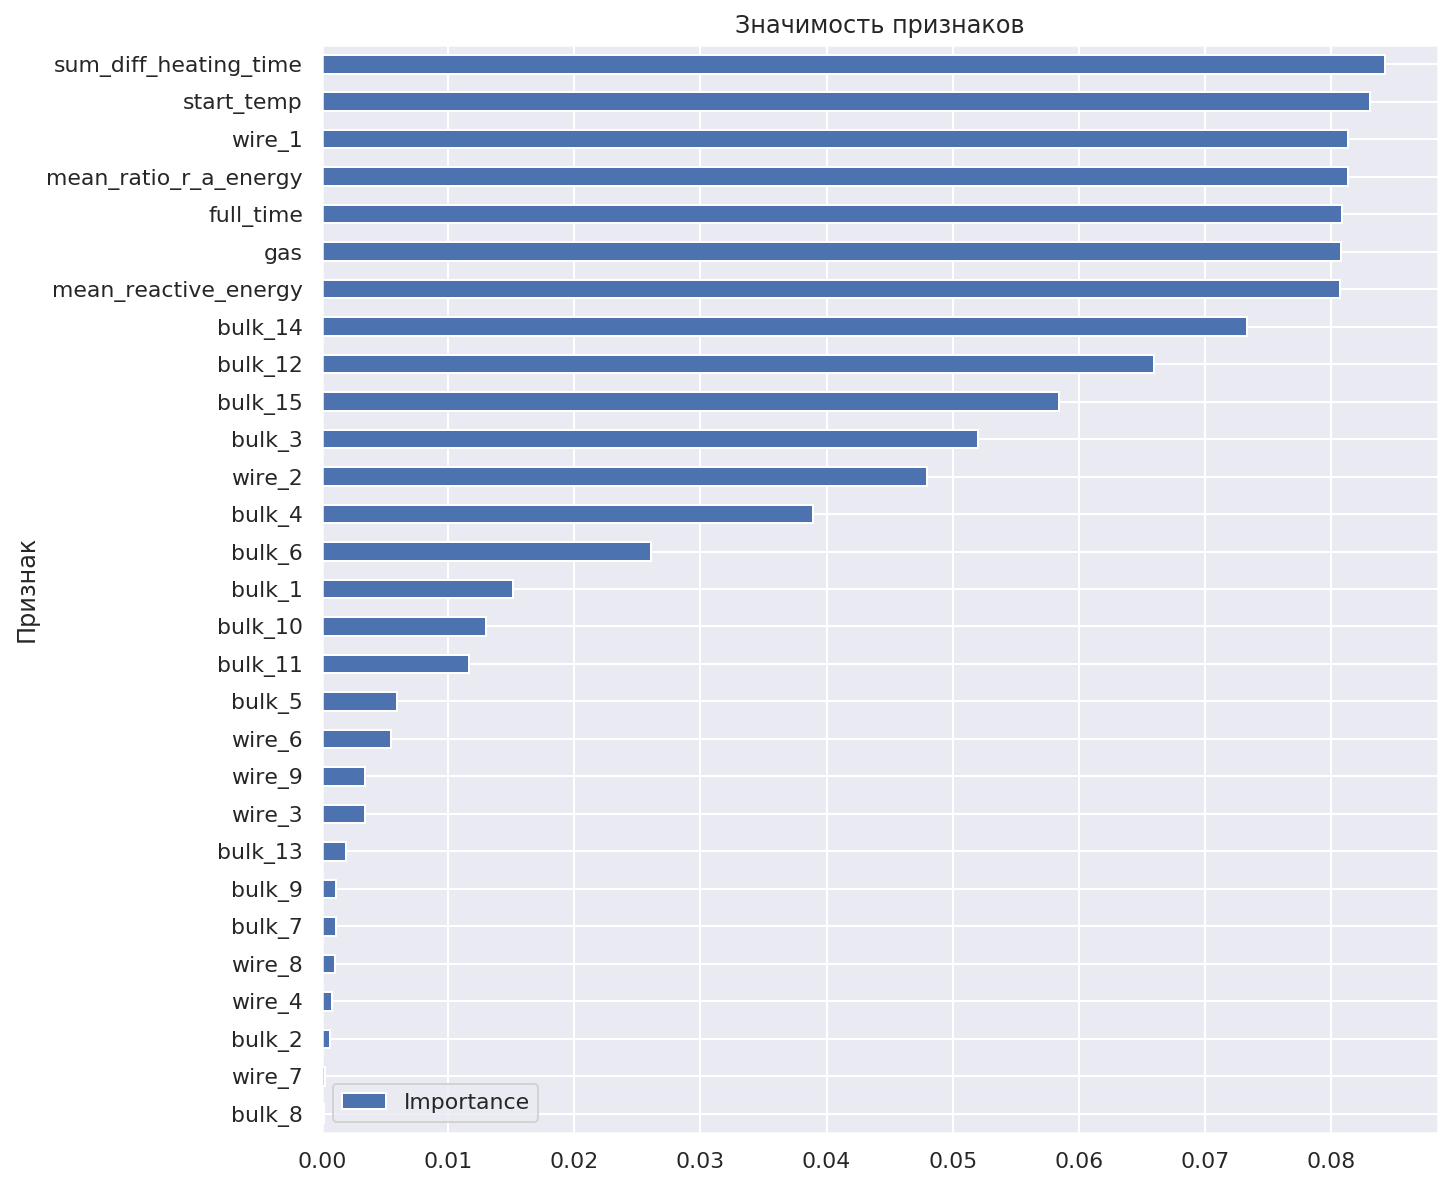

In [68]:
#отразим важность влияния признаков на графике
importance_data.plot(kind='barh', figsize=(10,10))
plt.title('Значимость признаков')
plt.ylabel('Признак')
plt.show()

<b>По итогам анализа важности признаков удалим из мультиколлинеарной пары wire 8 и bulk 9 признак "wire 8", также очень низкую значимость имеют признаки wire 7 и bulk 8, wire 4, bulk 2 -  меньше удаляемого признака wire 8, то их так же удалим</b>

In [69]:
features.columns

Index(['start_temp', 'full_time', 'mean_reactive_energy',
       'mean_ratio_r_a_energy', 'sum_diff_heating_time', 'bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9', 'gas'],
      dtype='object')

In [70]:
features = features.loc[:, ['start_temp', 'full_time', 'mean_reactive_energy',
       'mean_ratio_r_a_energy', 'sum_diff_heating_time', 'gas', 'bulk_1',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_9', ]]

### Вывод

* Очистили датасет от мультиколлинеарности и слабовлияющих на таргет признаков
* Подготовили два датасета: фичи для обучения и целевой признак

[К содержанию](#top)

### 3. Обучение моделей <a name="Обучение"></a>

* Разделение датасета на тестовый и тренинговый/валидационный.
* Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.

In [71]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = 0.25, random_state=12345)
display(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(1725, 25)

(576, 25)

(1725,)

(576,)

In [72]:
features_train_2, features_valid = train_test_split(features_train, test_size = 0.45, random_state=12345)
iso = IsolationForest(random_state=12345).fit(features_train)
iso_count = pd.DataFrame(index = features_train.index)
iso_count['iso'] = iso.predict(features_train)
iso_count['iso'].value_counts(normalize=True)

 1   0.90
-1   0.10
Name: iso, dtype: float64

* 10% аномальных предсказаний - совсем немного, не будем их трогать

<b>Далее выявим пулл подходов учитывающий возможные ограничения и найдем регрессионную модель удовлетворяющую необходимым характеристикам.</b>

In [73]:
# обучим LazyRegressor, чтобы он подсказал нам, какие алгориты могут подойти
#нужен валидационный датасет
#разбиваем на train и валид (20%)
lazy_features_train, lazy_features_valid, lazy_target_train, lazy_target_valid = train_test_split(features_train, 
                                                                                                  target_train, 
                                                                            test_size=0.20, random_state=12345)

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)

models,predictions = reg.fit(lazy_features_train, lazy_features_valid, lazy_target_train, lazy_target_valid)

 92%|█████████▏| 35/38 [00:45<00:02,  1.43it/s]

[21:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 38/38 [00:46<00:00,  1.22s/it]


In [74]:
display(models)

,R-Squared,RMSE,Time Taken
Model,,,
LGBMRegressor,0.71,7.65,0.24
GradientBoostingRegressor,0.71,7.66,0.44
XGBRegressor,0.70,7.85,0.36
HistGradientBoostingRegressor,0.69,7.97,10.35
BaggingRegressor,0.67,8.12,0.20
RandomForestRegressor,0.66,8.29,0.23
ExtraTreesRegressor,0.63,8.70,0.09
HuberRegressor,0.59,9.07,2.40
LassoLarsIC,0.58,9.20,0.11


<b>Возьмем самые привлекательные по RSME и попробудем подобрать лушие параметр:</b>
* LGBMRegressor
* GradientBoostingRegressor
* XGBRegressor
* HistGradientBoostingRegressor
* BaggingRegressor  

CatBoostRegressor тоже обучим
* CatBoostRegressor

<b>Создадим метрику MAE</b>

In [75]:
def mae(answer, prediction):
    mae = mean_absolute_error(answer, prediction)
    return mae
mae_scorer = make_scorer(
    mae,
    greater_is_better=False
)

In [76]:
#разделим на фолдеры 
cv = KFold(n_splits=5, random_state=1234, shuffle=True)

#### LGBMRegressor

In [79]:
#LGBMRegressor

grid_gs_LGBMR = {'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)]}

LGBMR = LGBMRegressor(random_state = 123)

gs_LGBMR = GridSearchCV(LGBMR, grid_gs_LGBMR, cv=cv, scoring = mae_scorer)

# временно закоментим для сокращения времени расчета
gs_LGBMR.fit(features_train,target_train)

best_params_LGBMR = gs_LGBMR.best_params_
print('Лучшие параметры для модели LGBMRegressor', best_params_LGBMR)
mae_LGBMR = gs_LGBMR.best_score_ * (-1)
print('MAE на валидационной выборке LGBMRegressor:', round(mae_LGBMR, 2))

Лучшие параметры для модели LGBMRegressor {'learning_rate': 0.1}
MAE на валидационной выборке LGBMRegressor: 5.94


#### GradientBoostingRegressor

In [80]:
# GradientBoostingRegressor
grid_GradBR = {'loss' : ['ls'],
        'learning_rate' : [i for i in np.arange(0.1,0.2,0.1)] , 
        'max_depth' : [i for i in np.arange(4,8,1)]}

GradBR = GradientBoostingRegressor(random_state = 123)

gs_GradBR = GridSearchCV(GradBR, grid_GradBR, cv=cv, scoring = mae_scorer)

# временно закоментим для сокращения времени расчета
gs_GradBR.fit(features_train,target_train)

best_params_GradBR = gs_GradBR.best_params_
print('Лучшие параметры для модели GradientBoostingRegressor', best_params_GradBR)
mae_GradBR = gs_GradBR.best_score_ * (-1)
print('MAE на валидационной выборке GradientBoostingRegressor:', round(mae_GradBR, 2))

Лучшие параметры для модели GradientBoostingRegressor {'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 6}
MAE на валидационной выборке GradientBoostingRegressor: 5.93


#### XGBRegressor

In [81]:
# XGBRegressor
grid_XGBR = {'eta' : [i for i in np.arange(0.1,0.3,0.1)] ,
             'max_depth' : [i for i in np.arange(4,9)]}

XGBR = XGBRegressor(random_state = 123)

gs_XGBR = GridSearchCV(XGBR, grid_XGBR, cv=cv, scoring = mae_scorer)

# временно закоментим для сокращения времени расчета
gs_XGBR.fit(features_train,target_train)

best_params_XGBR = gs_XGBR.best_params_
print('Лучшие параметры для модели XGBRegressor', best_params_XGBR)
mae_XGBR = gs_XGBR.best_score_ * (-1)
print('MAE на валидационной выборке XGBRegressor:', round(mae_XGBR, 2))

[21:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:56:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

#### HistGradientBoostingRegressor

In [82]:
# HistGradientBoostingRegressor
grid_histGBR = {'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)],
                'max_depth' : [i for i in np.arange(2,5,1)]}

histGBR = HistGradientBoostingRegressor(random_state = 123)

gs_histGBR = GridSearchCV(histGBR, grid_histGBR, cv=cv, scoring = mae_scorer)

# временно закоментим для сокращения времени расчета
gs_histGBR.fit(features_train,target_train)

best_params_histGBR = gs_histGBR.best_params_
print('Лучшие параметры для модели HistGradientBoostingRegressor', best_params_histGBR)
mae_histGBR = gs_histGBR.best_score_ * (-1)
print('MAE на валидационной выборке HistGradientBoostingRegressor:', round(mae_histGBR, 2))

Лучшие параметры для модели HistGradientBoostingRegressor {'learning_rate': 0.2, 'max_depth': 3}
MAE на валидационной выборке HistGradientBoostingRegressor: 5.97


#### BaggingRegressor

In [83]:
# BaggingRegressor
grid_bagR = {'n_estimators' : [i for i in np.arange(129,134,1)]}

bagR = BaggingRegressor(random_state = 123)

gs_bagR= GridSearchCV(bagR, grid_bagR, cv=cv, scoring = mae_scorer)

# временно закоментим для сокращения времени расчета
gs_bagR.fit(features_train,target_train)

best_params_bagR = gs_bagR.best_params_
print('Лучшие параметры для модели BaggingRegressor', best_params_bagR)
mae_bagR = gs_bagR.best_score_ * (-1)
print('MAE на валидационной выборке BaggingRegressor:', round(mae_bagR, 2))

Лучшие параметры для модели BaggingRegressor {'n_estimators': 130}
MAE на валидационной выборке BaggingRegressor: 6.17


<b>Модель Catboost</b>

In [84]:
parameters = {'depth'         : [4, 5],
              'learning_rate' : [0.25, 0.5],
              'iterations'    : [58, 59, 60]
             }
cat = CatBoostRegressor(random_state=123)
grid_cat = GridSearchCV(cat,
                    param_grid = parameters,
                    cv = cv,
                    scoring=mae_scorer)
grid_cat.fit(features_train, target_train, verbose = 0)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f20b99b6490>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [4, 5], 'iterations': [58, 59, 60],
                         'learning_rate': [0.25, 0.5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mae, greater_is_better=False), verbose=0)

In [85]:
best_params_cat = grid_cat.best_params_
print('Лучшие параметры для модели Catboost',best_params_cat)
mae_cat = grid_cat.best_score_ * (-1)
print('MAE на валидационной выборке Catboost:', round(mae_cat, 2))

Лучшие параметры для модели Catboost {'depth': 5, 'iterations': 60, 'learning_rate': 0.25}
MAE на валидационной выборке Catboost: 5.82


#### Создадим сводную таблицу результатов обучения моделей на валидационной выборке

In [86]:
#результаты сохраним в таблицу
results_1 = (
    {'Models':
     ['LGBMRegressor', 'GradientBoostingRegressor', 'XGBRegressor',
      'HistGradientBoostingRegressor','BaggingRegressor','CatBoostRegressor'],
     'MAE на кросс-валидации': [round(mae_LGBMR, 2),
                                 round(mae_GradBR, 2),
                                 round(mae_XGBR, 2),
                                 round(mae_histGBR, 2),
                                round(mae_bagR, 2),
                                round(mae_cat, 2)
                                 ]
    }
)
results = pd.DataFrame(results_1)
print(color.BOLD + 'Метрики качества моделей на кросс-валидации' +color.END)
#results.columns = pd.MultiIndex.from_product([['Метрики качества моделей на кросс-валидации'], results.columns])
display(results.sort_values(by='MAE на кросс-валидации').reset_index(drop=True))

Метрики качества моделей на кросс-валидации


,Models,MAE на кросс-валидации
0,XGBRegressor,5.82
1,CatBoostRegressor,5.82
2,GradientBoostingRegressor,5.93
3,LGBMRegressor,5.94
4,HistGradientBoostingRegressor,5.97
5,BaggingRegressor,6.17


#### Вывод

In [87]:
#посмотрим, можно ли уменьшить количество параметров
cat_imp = CatBoostRegressor(random_state=123, depth=5,
                            iterations=60, learning_rate=0.25, verbose=0).fit(features_train, target_train)
feature_importances_info = pd.DataFrame()
feature_importances_info['columns'] = features_train.columns
feature_importances_info['importances'] = cat_imp.feature_importances_
feature_importances_info.sort_values(by = 'importances').head(10)

,columns,importances
12,bulk_9,0.00
24,wire_9,0.00
13,bulk_10,0.01
16,bulk_13,0.02
21,wire_3,0.03
14,bulk_11,0.07
22,wire_4,0.09
8,bulk_4,0.31
7,bulk_3,0.33
11,bulk_7,0.37


In [88]:
#удалим маловажные признаки
col_unnecessary = feature_importances_info.query('importances < 0.01')['columns'].to_list()
features_train = features_train.drop(col_unnecessary, axis=1)
features_test = features_test.drop(col_unnecessary, axis=1)

In [89]:
features_train.columns

Index(['start_temp', 'full_time', 'mean_reactive_energy',
       'mean_ratio_r_a_energy', 'sum_diff_heating_time', 'gas', 'bulk_1',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6'],
      dtype='object')

### Вывод  
В качестве лучшей модели будем использовать модель Catboost

[К содержанию](#top)

### 4. Тестирование моделей <a name="Тестирование"></a>

<b>Попробуем использовать стекинг из обученных нами моделей</b>

In [90]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_predict

class DjStacking(BaseEstimator, ClassifierMixin):  
    """Стэкинг моделей scikit-learn"""

    def __init__(self, models, ens_model):
        """
        Инициализация
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=12345):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                pr = clf.predict(valid)
                self.valid[:, t] = pr.ravel()
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                cr = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict')
                self.valid[:, t] += cr.ravel()
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y)  
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            pr = clf.predict(X)
            X_meta[:, t] = pr.ravel()
        
        a = self.ens_model.predict(X_meta)
        
        return (a)


In [91]:
def run_and_plot(clf, X, y, label):    
    a = clf.predict(X)
    print (label + ' MAE = ' + str(mean_absolute_error(y, a) ))

In [92]:
LGBMR =  LGBMRegressor(random_state = 123, learning_rate= 0.1)
GradBR = GradientBoostingRegressor(random_state = 123, learning_rate = 0.1, loss = 'ls', max_depth= 6)
XGBR = XGBRegressor(random_state = 123, eta =0.1, max_depth= 6, verbose=0)
histGBR = HistGradientBoostingRegressor(random_state = 123, learning_rate=0.2, max_depth= 3)
bagR = BaggingRegressor(random_state = 123, n_estimators=130)
cat = CatBoostRegressor(random_state=12345, depth =6, iterations = 60, learning_rate=0.25, verbose=0)

In [93]:
#Запускаем блендинг и стекинг
models = [LGBMR, GradBR, XGBR, histGBR, bagR, grid_cat] 
ens_model = CatBoostRegressor(learning_rate=0.25, depth=6, iterations= 60, verbose=False)
s1 = DjStacking(models, ens_model)
s1.fit(features_train, target_train)
run_and_plot(s1, features_test, target_test, '1-stacking')

s2 = DjStacking(models, ens_model)
s2.fit(features_train, target_train, p=-1)
run_and_plot(s2,features_test, target_test, '2-stacking')

[22:00:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 15.2347664	total: 1.16ms	remaining: 66.2ms
1:	learn: 13.7404692	total: 2.3ms	remaining: 64.4ms
2:	learn: 12.6593153	total: 3.26ms	remaining: 59.8ms
3:	learn: 11.7738289	total: 4.18ms	remaining: 56.4ms
4:	learn: 11.0266911	total: 5.14ms	remaining: 54.5ms
5:	learn: 10.7283124	total: 6.07ms	remaining: 52.6ms
6:	learn: 10.2888856	total: 6.99ms	remaining: 50.9ms
7:	learn: 9.8695252	total: 7.98ms	remaining: 49.9ms
8:	learn: 9.5250459	total: 8.92ms	remaining: 48.6ms
9:	learn: 9.2729342	total: 9.85ms	remaining: 47.3ms
10:	learn: 8.9976072	total: 12ms	remaining: 51.3ms
11:	learn: 8.8171663	total: 12.9ms	remaining: 49.6ms
12:	learn: 8.7133447	total: 13.9ms	remaining: 48.1ms
13:	learn: 8.5948699	total: 14.8ms	remaining: 46.5ms
14:	learn: 8.4447390	total: 99ms	remaining: 284ms
15:	learn: 8.3639562	total: 100ms	remaining: 263ms
16:	learn: 8.2588896	total: 101ms	re

53:	learn: 6.2798645	total: 408ms	remaining: 30.2ms
54:	learn: 6.2683797	total: 410ms	remaining: 22.3ms
55:	learn: 6.2251945	total: 411ms	remaining: 14.7ms
56:	learn: 6.2084766	total: 412ms	remaining: 7.23ms
57:	learn: 6.1626665	total: 413ms	remaining: 0us
0:	learn: 14.2825685	total: 1.13ms	remaining: 64.2ms
1:	learn: 13.0107151	total: 2.15ms	remaining: 60.1ms
2:	learn: 11.9158468	total: 3.08ms	remaining: 56.6ms
3:	learn: 11.1487640	total: 4.06ms	remaining: 54.9ms
4:	learn: 10.6197380	total: 5.02ms	remaining: 53.2ms
5:	learn: 10.2613484	total: 6.01ms	remaining: 52.1ms
6:	learn: 9.8467230	total: 6.94ms	remaining: 50.5ms
7:	learn: 9.6370793	total: 9.73ms	remaining: 60.8ms
8:	learn: 9.3595070	total: 12.6ms	remaining: 68.7ms
9:	learn: 9.1585196	total: 20.1ms	remaining: 96.3ms
10:	learn: 8.9221953	total: 21ms	remaining: 89.8ms
11:	learn: 8.7403881	total: 21.9ms	remaining: 84.1ms
12:	learn: 8.5572437	total: 22.9ms	remaining: 79.1ms
13:	learn: 8.3701465	total: 23.8ms	remaining: 74.8ms
14:	lea

50:	learn: 5.3342429	total: 303ms	remaining: 41.6ms
51:	learn: 5.2910843	total: 305ms	remaining: 35.2ms
52:	learn: 5.2380619	total: 306ms	remaining: 28.9ms
53:	learn: 5.1729709	total: 307ms	remaining: 22.8ms
54:	learn: 5.1407019	total: 308ms	remaining: 16.8ms
55:	learn: 5.1340826	total: 309ms	remaining: 11ms
56:	learn: 5.1174099	total: 311ms	remaining: 5.45ms
57:	learn: 5.0543504	total: 312ms	remaining: 0us
0:	learn: 12.8651766	total: 1.24ms	remaining: 70.4ms
1:	learn: 11.2997775	total: 2.19ms	remaining: 61.4ms
2:	learn: 10.6705034	total: 3.09ms	remaining: 56.7ms
3:	learn: 9.8152586	total: 4.11ms	remaining: 55.4ms
4:	learn: 9.3025134	total: 5.08ms	remaining: 53.9ms
5:	learn: 8.9803417	total: 6.02ms	remaining: 52.2ms
6:	learn: 8.6370330	total: 6.98ms	remaining: 50.8ms
7:	learn: 8.3629776	total: 7.92ms	remaining: 49.5ms
8:	learn: 8.1865738	total: 8.86ms	remaining: 48.2ms
9:	learn: 8.0475237	total: 77.4ms	remaining: 372ms
10:	learn: 7.9007042	total: 78.5ms	remaining: 335ms
11:	learn: 7.79

56:	learn: 4.7731994	total: 429ms	remaining: 7.52ms
57:	learn: 4.7325518	total: 432ms	remaining: 0us
0:	learn: 13.0885488	total: 1.15ms	remaining: 65.6ms
1:	learn: 11.2578928	total: 2.17ms	remaining: 60.7ms
2:	learn: 10.6015420	total: 3.11ms	remaining: 57ms
3:	learn: 9.9209143	total: 4.07ms	remaining: 55ms
4:	learn: 9.3644869	total: 5.07ms	remaining: 53.7ms
5:	learn: 9.0528438	total: 6.03ms	remaining: 52.2ms
6:	learn: 8.8228662	total: 6.92ms	remaining: 50.5ms
7:	learn: 8.7119572	total: 7.93ms	remaining: 49.6ms
8:	learn: 8.4237266	total: 8.86ms	remaining: 48.3ms
9:	learn: 8.1878952	total: 9.82ms	remaining: 47.2ms
10:	learn: 8.0491058	total: 10.7ms	remaining: 45.8ms
11:	learn: 7.8607581	total: 15.6ms	remaining: 59.8ms
12:	learn: 7.6603333	total: 16.6ms	remaining: 57.4ms
13:	learn: 7.4553912	total: 17.5ms	remaining: 55ms
14:	learn: 7.3766883	total: 18.4ms	remaining: 52.8ms
15:	learn: 7.2525097	total: 19.3ms	remaining: 50.7ms
16:	learn: 7.1813320	total: 20.2ms	remaining: 48.7ms
17:	learn: 

47:	learn: 6.4705451	total: 407ms	remaining: 93.2ms
48:	learn: 6.4285996	total: 408ms	remaining: 83.2ms
49:	learn: 6.3745567	total: 409ms	remaining: 73.7ms
50:	learn: 6.3290986	total: 410ms	remaining: 64.4ms
51:	learn: 6.3178151	total: 411ms	remaining: 55.3ms
52:	learn: 6.2853175	total: 412ms	remaining: 46.7ms
53:	learn: 6.2548461	total: 413ms	remaining: 38.3ms
54:	learn: 6.2461452	total: 415ms	remaining: 30.2ms
55:	learn: 6.1943225	total: 500ms	remaining: 26.8ms
56:	learn: 6.1469407	total: 501ms	remaining: 17.6ms
57:	learn: 6.1030466	total: 502ms	remaining: 8.65ms
58:	learn: 6.0734378	total: 503ms	remaining: 0us
0:	learn: 14.7033839	total: 1.15ms	remaining: 67ms
1:	learn: 13.4409072	total: 2.37ms	remaining: 67.5ms
2:	learn: 12.3461318	total: 3.4ms	remaining: 63.6ms
3:	learn: 11.5288201	total: 4.52ms	remaining: 62.2ms
4:	learn: 10.9253264	total: 5.57ms	remaining: 60.2ms
5:	learn: 10.6612790	total: 6.9ms	remaining: 61ms
6:	learn: 10.3334819	total: 8.18ms	remaining: 60.7ms
7:	learn: 10.0

33:	learn: 6.9218884	total: 245ms	remaining: 180ms
34:	learn: 6.8664336	total: 246ms	remaining: 168ms
35:	learn: 6.7927884	total: 247ms	remaining: 157ms
36:	learn: 6.7215113	total: 247ms	remaining: 147ms
37:	learn: 6.6470723	total: 248ms	remaining: 137ms
38:	learn: 6.5888407	total: 250ms	remaining: 128ms
39:	learn: 6.5629452	total: 251ms	remaining: 119ms
40:	learn: 6.5107039	total: 252ms	remaining: 111ms
41:	learn: 6.4747072	total: 253ms	remaining: 103ms
42:	learn: 6.4323162	total: 254ms	remaining: 94.6ms
43:	learn: 6.4156809	total: 338ms	remaining: 115ms
44:	learn: 6.3898368	total: 339ms	remaining: 105ms
45:	learn: 6.3489491	total: 340ms	remaining: 96.1ms
46:	learn: 6.2987594	total: 341ms	remaining: 87ms
47:	learn: 6.2485729	total: 342ms	remaining: 78.3ms
48:	learn: 6.2344852	total: 343ms	remaining: 69.9ms
49:	learn: 6.2250712	total: 344ms	remaining: 61.9ms
50:	learn: 6.1696767	total: 345ms	remaining: 54ms
51:	learn: 6.1596017	total: 346ms	remaining: 46.5ms
52:	learn: 6.1083834	total:

30:	learn: 6.1260598	total: 132ms	remaining: 119ms
31:	learn: 6.0643000	total: 133ms	remaining: 112ms
32:	learn: 6.0159092	total: 134ms	remaining: 105ms
33:	learn: 6.0008269	total: 135ms	remaining: 99ms
34:	learn: 5.9275052	total: 136ms	remaining: 92.9ms
35:	learn: 5.8567796	total: 136ms	remaining: 87.2ms
36:	learn: 5.7839825	total: 137ms	remaining: 81.7ms
37:	learn: 5.6972008	total: 138ms	remaining: 76.4ms
38:	learn: 5.6795179	total: 139ms	remaining: 71.4ms
39:	learn: 5.6344968	total: 140ms	remaining: 66.5ms
40:	learn: 5.5991029	total: 141ms	remaining: 62ms
41:	learn: 5.5805324	total: 142ms	remaining: 57.5ms
42:	learn: 5.5140637	total: 222ms	remaining: 82.4ms
43:	learn: 5.4392364	total: 223ms	remaining: 75.9ms
44:	learn: 5.4031027	total: 224ms	remaining: 69.6ms
45:	learn: 5.3826805	total: 225ms	remaining: 63.5ms
46:	learn: 5.3408195	total: 226ms	remaining: 57.7ms
47:	learn: 5.3182161	total: 227ms	remaining: 52ms
48:	learn: 5.2746532	total: 228ms	remaining: 46.5ms
49:	learn: 5.2433551	

32:	learn: 7.2065244	total: 184ms	remaining: 150ms
33:	learn: 7.1583093	total: 185ms	remaining: 141ms
34:	learn: 7.0909091	total: 186ms	remaining: 133ms
35:	learn: 7.0142283	total: 187ms	remaining: 124ms
36:	learn: 6.9515197	total: 188ms	remaining: 117ms
37:	learn: 6.9255695	total: 188ms	remaining: 109ms
38:	learn: 6.8380948	total: 189ms	remaining: 102ms
39:	learn: 6.7989234	total: 190ms	remaining: 95.1ms
40:	learn: 6.7594423	total: 191ms	remaining: 88.6ms
41:	learn: 6.6966354	total: 192ms	remaining: 82.4ms
42:	learn: 6.6417045	total: 193ms	remaining: 76.3ms
43:	learn: 6.6039806	total: 194ms	remaining: 70.5ms
44:	learn: 6.5866263	total: 195ms	remaining: 65ms
45:	learn: 6.5781950	total: 196ms	remaining: 59.6ms
46:	learn: 6.5294112	total: 197ms	remaining: 54.5ms
47:	learn: 6.4789522	total: 198ms	remaining: 49.5ms
48:	learn: 6.4372236	total: 199ms	remaining: 44.6ms
49:	learn: 6.4299944	total: 200ms	remaining: 39.9ms
50:	learn: 6.3990267	total: 201ms	remaining: 35.4ms
51:	learn: 6.3682460	

33:	learn: 6.7210128	total: 251ms	remaining: 192ms
34:	learn: 6.6145171	total: 252ms	remaining: 180ms
35:	learn: 6.5648132	total: 253ms	remaining: 169ms
36:	learn: 6.4955814	total: 254ms	remaining: 158ms
37:	learn: 6.4841396	total: 256ms	remaining: 148ms
38:	learn: 6.4513578	total: 257ms	remaining: 138ms
39:	learn: 6.3784046	total: 258ms	remaining: 129ms
40:	learn: 6.3277047	total: 259ms	remaining: 120ms
41:	learn: 6.2872150	total: 260ms	remaining: 111ms
42:	learn: 6.2327851	total: 261ms	remaining: 103ms
43:	learn: 6.1842195	total: 340ms	remaining: 124ms
44:	learn: 6.1694445	total: 341ms	remaining: 114ms
45:	learn: 6.1201598	total: 342ms	remaining: 104ms
46:	learn: 6.0771083	total: 343ms	remaining: 94.8ms
47:	learn: 6.0442866	total: 344ms	remaining: 86ms
48:	learn: 6.0161309	total: 345ms	remaining: 77.4ms
49:	learn: 5.9760822	total: 346ms	remaining: 69.1ms
50:	learn: 5.9691605	total: 347ms	remaining: 61.2ms
51:	learn: 5.9219876	total: 348ms	remaining: 53.5ms
52:	learn: 5.9083155	total:

32:	learn: 5.9962170	total: 63.5ms	remaining: 52ms
33:	learn: 5.9198352	total: 65ms	remaining: 49.7ms
34:	learn: 5.8762569	total: 66.6ms	remaining: 47.5ms
35:	learn: 5.8204431	total: 67.9ms	remaining: 45.2ms
36:	learn: 5.8008163	total: 68.7ms	remaining: 42.7ms
37:	learn: 5.7873876	total: 70ms	remaining: 40.5ms
38:	learn: 5.7365396	total: 70.9ms	remaining: 38.2ms
39:	learn: 5.6874230	total: 72.1ms	remaining: 36.1ms
40:	learn: 5.6804734	total: 73ms	remaining: 33.8ms
41:	learn: 5.5950569	total: 73.9ms	remaining: 31.7ms
42:	learn: 5.5347385	total: 74.7ms	remaining: 29.5ms
43:	learn: 5.4490071	total: 160ms	remaining: 58ms
44:	learn: 5.3868512	total: 161ms	remaining: 53.5ms
45:	learn: 5.3325203	total: 161ms	remaining: 49.1ms
46:	learn: 5.3072397	total: 162ms	remaining: 44.9ms
47:	learn: 5.2681492	total: 163ms	remaining: 40.8ms
48:	learn: 5.2438650	total: 164ms	remaining: 36.9ms
49:	learn: 5.1845484	total: 165ms	remaining: 33ms
50:	learn: 5.1403395	total: 168ms	remaining: 29.6ms
51:	learn: 5.

25:	learn: 6.3073088	total: 217ms	remaining: 283ms
26:	learn: 6.2917736	total: 218ms	remaining: 266ms
27:	learn: 6.2253576	total: 219ms	remaining: 250ms
28:	learn: 6.1621259	total: 220ms	remaining: 235ms
29:	learn: 6.0641247	total: 221ms	remaining: 221ms
30:	learn: 5.9765934	total: 222ms	remaining: 207ms
31:	learn: 5.9123725	total: 223ms	remaining: 195ms
32:	learn: 5.8638192	total: 224ms	remaining: 183ms
33:	learn: 5.8030821	total: 225ms	remaining: 172ms
34:	learn: 5.7398580	total: 226ms	remaining: 161ms
35:	learn: 5.6967752	total: 226ms	remaining: 151ms
36:	learn: 5.6019644	total: 313ms	remaining: 195ms
37:	learn: 5.5707379	total: 314ms	remaining: 182ms
38:	learn: 5.5621921	total: 315ms	remaining: 170ms
39:	learn: 5.5539410	total: 316ms	remaining: 158ms
40:	learn: 5.5195466	total: 317ms	remaining: 147ms
41:	learn: 5.4791916	total: 318ms	remaining: 136ms
42:	learn: 5.4107540	total: 319ms	remaining: 126ms
43:	learn: 5.3968832	total: 319ms	remaining: 116ms
44:	learn: 5.3373211	total: 320

22:	learn: 7.5805535	total: 232ms	remaining: 353ms
23:	learn: 7.5364530	total: 234ms	remaining: 331ms
24:	learn: 7.4597718	total: 235ms	remaining: 310ms
25:	learn: 7.3989229	total: 236ms	remaining: 291ms
26:	learn: 7.2806791	total: 239ms	remaining: 274ms
27:	learn: 7.2133914	total: 241ms	remaining: 258ms
28:	learn: 7.1604171	total: 242ms	remaining: 242ms
29:	learn: 7.1155689	total: 329ms	remaining: 307ms
30:	learn: 7.0856062	total: 331ms	remaining: 288ms
31:	learn: 7.0309192	total: 333ms	remaining: 270ms
32:	learn: 6.9990160	total: 334ms	remaining: 253ms
33:	learn: 6.8886680	total: 336ms	remaining: 237ms
34:	learn: 6.8005621	total: 343ms	remaining: 226ms
35:	learn: 6.7104424	total: 425ms	remaining: 260ms
36:	learn: 6.6132188	total: 428ms	remaining: 243ms
37:	learn: 6.5372917	total: 430ms	remaining: 227ms
38:	learn: 6.4594033	total: 432ms	remaining: 210ms
39:	learn: 6.4181080	total: 434ms	remaining: 195ms
40:	learn: 6.3632210	total: 436ms	remaining: 181ms
41:	learn: 6.3358772	total: 443

19:	learn: 6.6701721	total: 198ms	remaining: 375ms
20:	learn: 6.5835569	total: 200ms	remaining: 352ms
21:	learn: 6.5245085	total: 201ms	remaining: 329ms
22:	learn: 6.4599906	total: 202ms	remaining: 307ms
23:	learn: 6.3154273	total: 203ms	remaining: 288ms
24:	learn: 6.2946046	total: 204ms	remaining: 270ms
25:	learn: 6.2717221	total: 211ms	remaining: 260ms
26:	learn: 6.1692209	total: 218ms	remaining: 250ms
27:	learn: 6.0363160	total: 294ms	remaining: 315ms
28:	learn: 5.9062951	total: 295ms	remaining: 295ms
29:	learn: 5.8962519	total: 296ms	remaining: 277ms
30:	learn: 5.8337222	total: 298ms	remaining: 259ms
31:	learn: 5.7336129	total: 299ms	remaining: 243ms
32:	learn: 5.6318290	total: 301ms	remaining: 228ms
33:	learn: 5.5132782	total: 302ms	remaining: 214ms
34:	learn: 5.4436447	total: 309ms	remaining: 203ms
35:	learn: 5.4116346	total: 390ms	remaining: 239ms
36:	learn: 5.3058600	total: 393ms	remaining: 223ms
37:	learn: 5.2432027	total: 394ms	remaining: 207ms
38:	learn: 5.1472659	total: 395

23:	learn: 5.8116126	total: 246ms	remaining: 348ms
24:	learn: 5.7278194	total: 248ms	remaining: 328ms
25:	learn: 5.6890570	total: 249ms	remaining: 307ms
26:	learn: 5.5923318	total: 251ms	remaining: 288ms
27:	learn: 5.5474190	total: 252ms	remaining: 270ms
28:	learn: 5.4618336	total: 253ms	remaining: 253ms
29:	learn: 5.3824283	total: 260ms	remaining: 243ms
30:	learn: 5.3225312	total: 343ms	remaining: 298ms
31:	learn: 5.1956842	total: 345ms	remaining: 280ms
32:	learn: 5.1383289	total: 347ms	remaining: 263ms
33:	learn: 5.1001349	total: 349ms	remaining: 246ms
34:	learn: 5.0231845	total: 351ms	remaining: 230ms
35:	learn: 4.9489890	total: 352ms	remaining: 215ms
36:	learn: 4.8785002	total: 354ms	remaining: 201ms
37:	learn: 4.8447299	total: 439ms	remaining: 231ms
38:	learn: 4.8352988	total: 441ms	remaining: 215ms
39:	learn: 4.7498364	total: 442ms	remaining: 199ms
40:	learn: 4.7430821	total: 444ms	remaining: 184ms
41:	learn: 4.6625546	total: 446ms	remaining: 170ms
42:	learn: 4.5792426	total: 447

24:	learn: 7.2441013	total: 215ms	remaining: 293ms
25:	learn: 7.2061183	total: 217ms	remaining: 276ms
26:	learn: 7.1081124	total: 219ms	remaining: 260ms
27:	learn: 7.0662515	total: 220ms	remaining: 244ms
28:	learn: 7.0304903	total: 221ms	remaining: 229ms
29:	learn: 6.9464779	total: 223ms	remaining: 215ms
30:	learn: 6.8872468	total: 224ms	remaining: 202ms
31:	learn: 6.8545061	total: 312ms	remaining: 263ms
32:	learn: 6.7712935	total: 314ms	remaining: 247ms
33:	learn: 6.7027909	total: 315ms	remaining: 232ms
34:	learn: 6.6339760	total: 318ms	remaining: 218ms
35:	learn: 6.5740759	total: 319ms	remaining: 204ms
36:	learn: 6.5150741	total: 320ms	remaining: 190ms
37:	learn: 6.4565760	total: 321ms	remaining: 178ms
38:	learn: 6.4279014	total: 323ms	remaining: 165ms
39:	learn: 6.3825303	total: 409ms	remaining: 194ms
40:	learn: 6.3375710	total: 412ms	remaining: 181ms
41:	learn: 6.2907532	total: 414ms	remaining: 167ms
42:	learn: 6.2725536	total: 416ms	remaining: 155ms
43:	learn: 6.2372315	total: 417

18:	learn: 7.5359336	total: 186ms	remaining: 392ms
19:	learn: 7.4619572	total: 188ms	remaining: 367ms
20:	learn: 7.4104533	total: 191ms	remaining: 345ms
21:	learn: 7.3737649	total: 193ms	remaining: 324ms
22:	learn: 7.3134971	total: 268ms	remaining: 420ms
23:	learn: 7.2625463	total: 270ms	remaining: 393ms
24:	learn: 7.1960561	total: 271ms	remaining: 368ms
25:	learn: 7.1082328	total: 272ms	remaining: 345ms
26:	learn: 7.0202398	total: 273ms	remaining: 324ms
27:	learn: 6.9433496	total: 275ms	remaining: 304ms
28:	learn: 6.8659764	total: 276ms	remaining: 286ms
29:	learn: 6.7782627	total: 283ms	remaining: 274ms
30:	learn: 6.7144137	total: 364ms	remaining: 329ms
31:	learn: 6.6489426	total: 366ms	remaining: 308ms
32:	learn: 6.5644731	total: 367ms	remaining: 289ms
33:	learn: 6.5121927	total: 368ms	remaining: 271ms
34:	learn: 6.4867909	total: 370ms	remaining: 254ms
35:	learn: 6.3668597	total: 371ms	remaining: 237ms
36:	learn: 6.3406881	total: 372ms	remaining: 221ms
37:	learn: 6.3131613	total: 374

20:	learn: 6.2624357	total: 233ms	remaining: 421ms
21:	learn: 6.1436144	total: 234ms	remaining: 394ms
22:	learn: 6.0017650	total: 236ms	remaining: 369ms
23:	learn: 5.9817630	total: 237ms	remaining: 346ms
24:	learn: 5.9377150	total: 238ms	remaining: 324ms
25:	learn: 5.8707541	total: 240ms	remaining: 304ms
26:	learn: 5.8571378	total: 241ms	remaining: 285ms
27:	learn: 5.7385016	total: 242ms	remaining: 268ms
28:	learn: 5.6408535	total: 329ms	remaining: 341ms
29:	learn: 5.5588007	total: 331ms	remaining: 320ms
30:	learn: 5.5004795	total: 332ms	remaining: 300ms
31:	learn: 5.4358086	total: 333ms	remaining: 281ms
32:	learn: 5.3904498	total: 334ms	remaining: 263ms
33:	learn: 5.3047665	total: 347ms	remaining: 255ms
34:	learn: 5.2576458	total: 353ms	remaining: 242ms
35:	learn: 5.2378397	total: 426ms	remaining: 272ms
36:	learn: 5.1614454	total: 428ms	remaining: 255ms
37:	learn: 5.0815572	total: 431ms	remaining: 238ms
38:	learn: 5.0199515	total: 432ms	remaining: 222ms
39:	learn: 4.9952948	total: 434

22:	learn: 7.3853156	total: 241ms	remaining: 387ms
23:	learn: 7.3247184	total: 242ms	remaining: 363ms
24:	learn: 7.2711549	total: 243ms	remaining: 341ms
25:	learn: 7.2404597	total: 245ms	remaining: 320ms
26:	learn: 7.1371069	total: 246ms	remaining: 301ms
27:	learn: 7.0814707	total: 247ms	remaining: 282ms
28:	learn: 7.0542532	total: 248ms	remaining: 265ms
29:	learn: 6.9725559	total: 255ms	remaining: 255ms
30:	learn: 6.8870330	total: 261ms	remaining: 245ms
31:	learn: 6.7636715	total: 337ms	remaining: 295ms
32:	learn: 6.7224249	total: 339ms	remaining: 277ms
33:	learn: 6.6929338	total: 340ms	remaining: 260ms
34:	learn: 6.6687893	total: 341ms	remaining: 244ms
35:	learn: 6.6271567	total: 342ms	remaining: 228ms
36:	learn: 6.5313265	total: 343ms	remaining: 213ms
37:	learn: 6.4619722	total: 350ms	remaining: 203ms
38:	learn: 6.3967443	total: 434ms	remaining: 234ms
39:	learn: 6.3776131	total: 436ms	remaining: 218ms
40:	learn: 6.3144875	total: 438ms	remaining: 203ms
41:	learn: 6.2990886	total: 439

23:	learn: 6.8454217	total: 207ms	remaining: 311ms
24:	learn: 6.7458292	total: 209ms	remaining: 292ms
25:	learn: 6.6174084	total: 210ms	remaining: 275ms
26:	learn: 6.5638355	total: 211ms	remaining: 258ms
27:	learn: 6.5234912	total: 213ms	remaining: 243ms
28:	learn: 6.4676105	total: 214ms	remaining: 229ms
29:	learn: 6.4207444	total: 215ms	remaining: 215ms
30:	learn: 6.3790961	total: 221ms	remaining: 207ms
31:	learn: 6.3560560	total: 301ms	remaining: 264ms
32:	learn: 6.2889894	total: 303ms	remaining: 248ms
33:	learn: 6.2381917	total: 304ms	remaining: 232ms
34:	learn: 6.1976609	total: 305ms	remaining: 218ms
35:	learn: 6.1466081	total: 306ms	remaining: 204ms
36:	learn: 6.0914441	total: 308ms	remaining: 191ms
37:	learn: 6.0814826	total: 309ms	remaining: 179ms
38:	learn: 6.0359135	total: 315ms	remaining: 170ms
39:	learn: 5.9925260	total: 322ms	remaining: 161ms
40:	learn: 5.9354810	total: 397ms	remaining: 184ms
41:	learn: 5.8649283	total: 399ms	remaining: 171ms
42:	learn: 5.8085568	total: 401

24:	learn: 6.0548174	total: 240ms	remaining: 336ms
25:	learn: 6.0057222	total: 242ms	remaining: 317ms
26:	learn: 5.9233481	total: 244ms	remaining: 298ms
27:	learn: 5.8305822	total: 246ms	remaining: 282ms
28:	learn: 5.7449395	total: 248ms	remaining: 265ms
29:	learn: 5.6563032	total: 255ms	remaining: 255ms
30:	learn: 5.6199495	total: 262ms	remaining: 245ms
31:	learn: 5.5784744	total: 337ms	remaining: 295ms
32:	learn: 5.4414593	total: 339ms	remaining: 277ms
33:	learn: 5.3518976	total: 340ms	remaining: 260ms
34:	learn: 5.3095715	total: 341ms	remaining: 244ms
35:	learn: 5.2169636	total: 343ms	remaining: 228ms
36:	learn: 5.1870737	total: 344ms	remaining: 214ms
37:	learn: 5.0915045	total: 350ms	remaining: 203ms
38:	learn: 5.0420323	total: 363ms	remaining: 195ms
39:	learn: 4.9946150	total: 434ms	remaining: 217ms
40:	learn: 4.9419436	total: 437ms	remaining: 203ms
41:	learn: 4.8686652	total: 438ms	remaining: 188ms
42:	learn: 4.8597646	total: 440ms	remaining: 174ms
43:	learn: 4.7799335	total: 441

23:	learn: 5.9321285	total: 192ms	remaining: 289ms
24:	learn: 5.8002435	total: 273ms	remaining: 382ms
25:	learn: 5.6929360	total: 274ms	remaining: 359ms
26:	learn: 5.6509259	total: 276ms	remaining: 337ms
27:	learn: 5.5806304	total: 277ms	remaining: 317ms
28:	learn: 5.5349217	total: 278ms	remaining: 297ms
29:	learn: 5.4994120	total: 279ms	remaining: 279ms
30:	learn: 5.3581034	total: 281ms	remaining: 263ms
31:	learn: 5.3434457	total: 282ms	remaining: 247ms
32:	learn: 5.2605101	total: 285ms	remaining: 233ms
33:	learn: 5.2083946	total: 365ms	remaining: 279ms
34:	learn: 5.1658176	total: 366ms	remaining: 262ms
35:	learn: 5.0925698	total: 368ms	remaining: 245ms
36:	learn: 4.9944052	total: 369ms	remaining: 229ms
37:	learn: 4.9727964	total: 370ms	remaining: 214ms
38:	learn: 4.9649981	total: 372ms	remaining: 200ms
39:	learn: 4.8842612	total: 374ms	remaining: 187ms
40:	learn: 4.8309932	total: 461ms	remaining: 214ms
41:	learn: 4.7908745	total: 464ms	remaining: 199ms
42:	learn: 4.7450774	total: 465

0:	learn: 13.5861906	total: 1.08ms	remaining: 61.4ms
1:	learn: 12.4413971	total: 2.13ms	remaining: 59.7ms
2:	learn: 11.7527509	total: 3.04ms	remaining: 55.8ms
3:	learn: 10.9487329	total: 3.95ms	remaining: 53.4ms
4:	learn: 10.4805023	total: 4.79ms	remaining: 50.8ms
5:	learn: 10.1312626	total: 5.72ms	remaining: 49.6ms
6:	learn: 9.7751999	total: 6.58ms	remaining: 47.9ms
7:	learn: 9.4906528	total: 7.45ms	remaining: 46.6ms
8:	learn: 9.2925788	total: 8.29ms	remaining: 45.2ms
9:	learn: 9.1442560	total: 9.12ms	remaining: 43.8ms
10:	learn: 8.9040845	total: 10ms	remaining: 42.8ms
11:	learn: 8.7214577	total: 10.9ms	remaining: 41.8ms
12:	learn: 8.6156613	total: 11.8ms	remaining: 40.8ms
13:	learn: 8.4643703	total: 12.6ms	remaining: 39.7ms
14:	learn: 8.3207382	total: 13.6ms	remaining: 38.8ms
15:	learn: 8.1982480	total: 14.5ms	remaining: 38ms
16:	learn: 8.0511804	total: 100ms	remaining: 241ms
17:	learn: 7.9659524	total: 101ms	remaining: 224ms
18:	learn: 7.8709392	total: 102ms	remaining: 209ms
19:	lea

0:	learn: 13.7013269	total: 1.09ms	remaining: 62.5ms
1:	learn: 12.3956564	total: 2.17ms	remaining: 60.7ms
2:	learn: 11.5637093	total: 3.02ms	remaining: 55.4ms
3:	learn: 11.0131206	total: 3.96ms	remaining: 53.5ms
4:	learn: 10.5364385	total: 4.88ms	remaining: 51.8ms
5:	learn: 10.0220290	total: 5.79ms	remaining: 50.2ms
6:	learn: 9.6507967	total: 6.69ms	remaining: 48.7ms
7:	learn: 9.2894067	total: 7.57ms	remaining: 47.3ms
8:	learn: 9.0462939	total: 8.42ms	remaining: 45.9ms
9:	learn: 8.8946942	total: 9.28ms	remaining: 44.5ms
10:	learn: 8.6698096	total: 10.2ms	remaining: 43.4ms
11:	learn: 8.5033401	total: 11.1ms	remaining: 42.4ms
12:	learn: 8.3008959	total: 90.9ms	remaining: 315ms
13:	learn: 8.1828102	total: 92.3ms	remaining: 290ms
14:	learn: 8.0683025	total: 93.1ms	remaining: 267ms
15:	learn: 7.8614123	total: 94ms	remaining: 247ms
16:	learn: 7.7760748	total: 94.9ms	remaining: 229ms
17:	learn: 7.7150550	total: 95.9ms	remaining: 213ms
18:	learn: 7.6522496	total: 96.8ms	remaining: 199ms
19:	le

0:	learn: 12.8368928	total: 1.4ms	remaining: 79.9ms
1:	learn: 11.3208796	total: 2.43ms	remaining: 68.1ms
2:	learn: 10.2601366	total: 3.28ms	remaining: 60.1ms
3:	learn: 9.6489813	total: 4.2ms	remaining: 56.8ms
4:	learn: 9.2293975	total: 5.52ms	remaining: 58.5ms
5:	learn: 8.8939151	total: 7.16ms	remaining: 62ms
6:	learn: 8.5582985	total: 7.95ms	remaining: 58ms
7:	learn: 8.3003204	total: 9.4ms	remaining: 58.8ms
8:	learn: 8.1887597	total: 10.2ms	remaining: 55.7ms
9:	learn: 8.0488392	total: 11.1ms	remaining: 53.3ms
10:	learn: 7.8436914	total: 12ms	remaining: 51.2ms
11:	learn: 7.7218230	total: 12.8ms	remaining: 49.1ms
12:	learn: 7.5888613	total: 13.7ms	remaining: 47.4ms
13:	learn: 7.4215677	total: 66.7ms	remaining: 210ms
14:	learn: 7.3101387	total: 67.8ms	remaining: 194ms
15:	learn: 7.1406817	total: 68.7ms	remaining: 180ms
16:	learn: 6.9311312	total: 69.5ms	remaining: 168ms
17:	learn: 6.7021444	total: 70.3ms	remaining: 156ms
18:	learn: 6.5901010	total: 71.2ms	remaining: 146ms
19:	learn: 6.46

0:	learn: 13.9837834	total: 1.06ms	remaining: 61.6ms
1:	learn: 12.8313737	total: 2.05ms	remaining: 58.4ms
2:	learn: 11.6014454	total: 2.93ms	remaining: 54.6ms
3:	learn: 10.7260135	total: 3.8ms	remaining: 52.3ms
4:	learn: 10.0904900	total: 4.66ms	remaining: 50.3ms
5:	learn: 9.8108049	total: 5.62ms	remaining: 49.6ms
6:	learn: 9.4066528	total: 6.58ms	remaining: 48.9ms
7:	learn: 9.1490035	total: 7.42ms	remaining: 47.3ms
8:	learn: 8.8963285	total: 8.52ms	remaining: 47.3ms
9:	learn: 8.7178276	total: 9.41ms	remaining: 46.1ms
10:	learn: 8.5197369	total: 10.3ms	remaining: 45ms
11:	learn: 8.3677121	total: 16.6ms	remaining: 65ms
12:	learn: 8.2442460	total: 81.1ms	remaining: 287ms
13:	learn: 8.1509870	total: 82.1ms	remaining: 264ms
14:	learn: 8.0370083	total: 83.3ms	remaining: 244ms
15:	learn: 7.9685512	total: 84.2ms	remaining: 226ms
16:	learn: 7.8653680	total: 85ms	remaining: 210ms
17:	learn: 7.7646544	total: 85.8ms	remaining: 195ms
18:	learn: 7.7212831	total: 86.6ms	remaining: 182ms
19:	learn: 7

0:	learn: 14.7602046	total: 1.14ms	remaining: 66.3ms
1:	learn: 13.2051928	total: 1.96ms	remaining: 55.9ms
2:	learn: 12.3165672	total: 2.77ms	remaining: 51.6ms
3:	learn: 11.4949186	total: 3.63ms	remaining: 49.9ms
4:	learn: 10.9999074	total: 4.49ms	remaining: 48.5ms
5:	learn: 10.5878937	total: 5.3ms	remaining: 46.9ms
6:	learn: 10.2050369	total: 6.19ms	remaining: 46ms
7:	learn: 9.8318911	total: 8.2ms	remaining: 52.3ms
8:	learn: 9.6404915	total: 9.05ms	remaining: 50.3ms
9:	learn: 9.4406519	total: 10.6ms	remaining: 51.7ms
10:	learn: 9.1471532	total: 11.4ms	remaining: 49.8ms
11:	learn: 8.9345091	total: 12.3ms	remaining: 48ms
12:	learn: 8.7439589	total: 13.1ms	remaining: 46.4ms
13:	learn: 8.6056244	total: 97.2ms	remaining: 312ms
14:	learn: 8.4711808	total: 98.2ms	remaining: 288ms
15:	learn: 8.3061298	total: 99.1ms	remaining: 266ms
16:	learn: 8.1824267	total: 100ms	remaining: 247ms
17:	learn: 8.0962660	total: 101ms	remaining: 230ms
18:	learn: 8.0374450	total: 102ms	remaining: 214ms
19:	learn: 

0:	learn: 12.3533963	total: 1.14ms	remaining: 65.9ms
1:	learn: 10.8216073	total: 2.14ms	remaining: 61ms
2:	learn: 10.2845137	total: 3.03ms	remaining: 56.6ms
3:	learn: 9.5425947	total: 3.96ms	remaining: 54.5ms
4:	learn: 9.1430834	total: 4.91ms	remaining: 53ms
5:	learn: 8.7419369	total: 5.82ms	remaining: 51.5ms
6:	learn: 8.4907182	total: 6.7ms	remaining: 49.8ms
7:	learn: 8.1394867	total: 7.55ms	remaining: 48.1ms
8:	learn: 7.9447654	total: 8.41ms	remaining: 46.7ms
9:	learn: 7.7685865	total: 9.29ms	remaining: 45.5ms
10:	learn: 7.5360373	total: 10.2ms	remaining: 44.4ms
11:	learn: 7.4053352	total: 11ms	remaining: 43.2ms
12:	learn: 7.3251546	total: 82.7ms	remaining: 293ms
13:	learn: 7.2476876	total: 85.1ms	remaining: 274ms
14:	learn: 7.0959866	total: 86ms	remaining: 252ms
15:	learn: 6.9007865	total: 86.9ms	remaining: 234ms
16:	learn: 6.8095172	total: 87.8ms	remaining: 217ms
17:	learn: 6.7055279	total: 88.7ms	remaining: 202ms
18:	learn: 6.6576226	total: 89.6ms	remaining: 189ms
19:	learn: 6.556

0:	learn: 12.1270143	total: 1.69ms	remaining: 98.1ms
1:	learn: 10.5084268	total: 3.13ms	remaining: 89.1ms
2:	learn: 9.6579056	total: 4.33ms	remaining: 80.8ms
3:	learn: 9.3301625	total: 5.48ms	remaining: 75.4ms
4:	learn: 8.7796524	total: 6.66ms	remaining: 71.9ms
5:	learn: 8.4941331	total: 7.58ms	remaining: 67ms
6:	learn: 8.1544234	total: 8.48ms	remaining: 63ms
7:	learn: 7.9698509	total: 9.38ms	remaining: 59.8ms
8:	learn: 7.8027309	total: 10.2ms	remaining: 56.9ms
9:	learn: 7.6560209	total: 11.5ms	remaining: 56.4ms
10:	learn: 7.4855714	total: 12.4ms	remaining: 54.1ms
11:	learn: 7.3524406	total: 38.6ms	remaining: 151ms
12:	learn: 7.2276634	total: 39.6ms	remaining: 140ms
13:	learn: 7.1344906	total: 41.6ms	remaining: 134ms
14:	learn: 6.9434757	total: 42.5ms	remaining: 125ms
15:	learn: 6.7966270	total: 44ms	remaining: 118ms
16:	learn: 6.7357181	total: 46.4ms	remaining: 115ms
17:	learn: 6.6448623	total: 48ms	remaining: 109ms
18:	learn: 6.5295912	total: 49ms	remaining: 103ms
19:	learn: 6.331369

0:	learn: 14.1814664	total: 2.35ms	remaining: 138ms
1:	learn: 13.0554837	total: 3.65ms	remaining: 106ms
2:	learn: 11.9436532	total: 4.84ms	remaining: 91.9ms
3:	learn: 11.1313426	total: 6.01ms	remaining: 84.1ms
4:	learn: 10.5643361	total: 6.93ms	remaining: 76.2ms
5:	learn: 10.2697494	total: 7.81ms	remaining: 70.3ms
6:	learn: 9.8807530	total: 8.64ms	remaining: 65.4ms
7:	learn: 9.5536220	total: 9.46ms	remaining: 61.5ms
8:	learn: 9.3217920	total: 10.3ms	remaining: 58.2ms
9:	learn: 9.0513968	total: 11.2ms	remaining: 55.8ms
10:	learn: 8.8480241	total: 12ms	remaining: 53.6ms
11:	learn: 8.7273839	total: 18.3ms	remaining: 73.2ms
12:	learn: 8.5958351	total: 54ms	remaining: 195ms
13:	learn: 8.3924081	total: 55ms	remaining: 181ms
14:	learn: 8.2831022	total: 55.9ms	remaining: 168ms
15:	learn: 8.2105025	total: 56.8ms	remaining: 156ms
16:	learn: 8.1100354	total: 57.7ms	remaining: 146ms
17:	learn: 8.0403270	total: 58.6ms	remaining: 137ms
18:	learn: 7.9975901	total: 59.5ms	remaining: 128ms
19:	learn: 7

39:	learn: 6.4248386	total: 245ms	remaining: 123ms
40:	learn: 6.4139771	total: 247ms	remaining: 114ms
41:	learn: 6.3724019	total: 248ms	remaining: 106ms
42:	learn: 6.3497676	total: 249ms	remaining: 98.3ms
43:	learn: 6.2853153	total: 249ms	remaining: 90.7ms
44:	learn: 6.2397609	total: 250ms	remaining: 83.4ms
45:	learn: 6.1771944	total: 251ms	remaining: 76.5ms
46:	learn: 6.1213778	total: 252ms	remaining: 69.7ms
47:	learn: 6.1117200	total: 253ms	remaining: 63.3ms
48:	learn: 6.0625844	total: 254ms	remaining: 57ms
49:	learn: 5.9995596	total: 255ms	remaining: 51ms
50:	learn: 5.9658294	total: 256ms	remaining: 45.1ms
51:	learn: 5.9213884	total: 340ms	remaining: 52.3ms
52:	learn: 5.8928895	total: 341ms	remaining: 45.1ms
53:	learn: 5.8577464	total: 342ms	remaining: 38ms
54:	learn: 5.8085699	total: 343ms	remaining: 31.2ms
55:	learn: 5.7736191	total: 344ms	remaining: 24.6ms
56:	learn: 5.7541705	total: 345ms	remaining: 18.1ms
57:	learn: 5.7158088	total: 346ms	remaining: 11.9ms
58:	learn: 5.7079697	

31:	learn: 5.7391422	total: 192ms	remaining: 168ms
32:	learn: 5.6907961	total: 193ms	remaining: 158ms
33:	learn: 5.6816640	total: 194ms	remaining: 148ms
34:	learn: 5.6242686	total: 195ms	remaining: 139ms
35:	learn: 5.5278862	total: 197ms	remaining: 131ms
36:	learn: 5.4553546	total: 197ms	remaining: 123ms
37:	learn: 5.3782744	total: 198ms	remaining: 115ms
38:	learn: 5.3636723	total: 199ms	remaining: 107ms
39:	learn: 5.3319792	total: 200ms	remaining: 100ms
40:	learn: 5.2567695	total: 201ms	remaining: 93.1ms
41:	learn: 5.2151451	total: 202ms	remaining: 86.4ms
42:	learn: 5.1436263	total: 202ms	remaining: 80.1ms
43:	learn: 5.1372928	total: 203ms	remaining: 73.9ms
44:	learn: 5.1035863	total: 288ms	remaining: 95.8ms
45:	learn: 5.0831986	total: 289ms	remaining: 87.8ms
46:	learn: 5.0374930	total: 289ms	remaining: 80.1ms
47:	learn: 5.0271226	total: 290ms	remaining: 72.6ms
48:	learn: 4.9858350	total: 291ms	remaining: 65.4ms
49:	learn: 4.9377539	total: 292ms	remaining: 58.4ms
50:	learn: 4.9067712	

31:	learn: 6.2462308	total: 241ms	remaining: 195ms
32:	learn: 6.2107645	total: 242ms	remaining: 183ms
33:	learn: 6.1516240	total: 243ms	remaining: 172ms
34:	learn: 6.0705325	total: 244ms	remaining: 160ms
35:	learn: 5.9951009	total: 247ms	remaining: 151ms
36:	learn: 5.9515660	total: 248ms	remaining: 141ms
37:	learn: 5.8901337	total: 250ms	remaining: 132ms
38:	learn: 5.8502797	total: 252ms	remaining: 123ms
39:	learn: 5.8048254	total: 333ms	remaining: 150ms
40:	learn: 5.7947919	total: 334ms	remaining: 139ms
41:	learn: 5.7334849	total: 336ms	remaining: 128ms
42:	learn: 5.6546616	total: 337ms	remaining: 117ms
43:	learn: 5.6247421	total: 338ms	remaining: 107ms
44:	learn: 5.5687924	total: 339ms	remaining: 98ms
45:	learn: 5.5066040	total: 341ms	remaining: 88.8ms
46:	learn: 5.4824709	total: 342ms	remaining: 80ms
47:	learn: 5.4721793	total: 343ms	remaining: 71.4ms
48:	learn: 5.4615308	total: 344ms	remaining: 63.2ms
49:	learn: 5.4279241	total: 345ms	remaining: 55.2ms
50:	learn: 5.4222783	total: 4

31:	learn: 6.6878208	total: 259ms	remaining: 210ms
32:	learn: 6.6071657	total: 261ms	remaining: 198ms
33:	learn: 6.5278500	total: 262ms	remaining: 185ms
34:	learn: 6.4047308	total: 265ms	remaining: 174ms
35:	learn: 6.3348696	total: 266ms	remaining: 163ms
36:	learn: 6.2731212	total: 268ms	remaining: 152ms
37:	learn: 6.2004436	total: 269ms	remaining: 142ms
38:	learn: 6.1616603	total: 270ms	remaining: 132ms
39:	learn: 6.0672726	total: 272ms	remaining: 122ms
40:	learn: 5.9944369	total: 273ms	remaining: 113ms
41:	learn: 5.9598615	total: 274ms	remaining: 104ms
42:	learn: 5.9437644	total: 354ms	remaining: 123ms
43:	learn: 5.8564569	total: 355ms	remaining: 113ms
44:	learn: 5.8248505	total: 356ms	remaining: 103ms
45:	learn: 5.7788426	total: 357ms	remaining: 93.2ms
46:	learn: 5.7069420	total: 358ms	remaining: 83.8ms
47:	learn: 5.6417048	total: 359ms	remaining: 74.9ms
48:	learn: 5.5885569	total: 360ms	remaining: 66.2ms
49:	learn: 5.5546995	total: 361ms	remaining: 57.8ms
50:	learn: 5.5312325	total

31:	learn: 5.0261655	total: 233ms	remaining: 189ms
32:	learn: 4.9652643	total: 235ms	remaining: 178ms
33:	learn: 4.9436620	total: 236ms	remaining: 167ms
34:	learn: 4.8805887	total: 237ms	remaining: 156ms
35:	learn: 4.8226255	total: 238ms	remaining: 146ms
36:	learn: 4.7366229	total: 239ms	remaining: 136ms
37:	learn: 4.6350820	total: 241ms	remaining: 127ms
38:	learn: 4.5513529	total: 242ms	remaining: 118ms
39:	learn: 4.5067812	total: 243ms	remaining: 109ms
40:	learn: 4.4645845	total: 244ms	remaining: 101ms
41:	learn: 4.3943899	total: 328ms	remaining: 125ms
42:	learn: 4.3868998	total: 329ms	remaining: 115ms
43:	learn: 4.3306181	total: 330ms	remaining: 105ms
44:	learn: 4.2728053	total: 331ms	remaining: 95.7ms
45:	learn: 4.2566762	total: 333ms	remaining: 86.8ms
46:	learn: 4.2073172	total: 334ms	remaining: 78.1ms
47:	learn: 4.1570248	total: 335ms	remaining: 69.8ms
48:	learn: 4.1089163	total: 336ms	remaining: 61.7ms
49:	learn: 4.1049279	total: 337ms	remaining: 54ms
50:	learn: 4.0719647	total:

31:	learn: 5.0057111	total: 245ms	remaining: 199ms
32:	learn: 4.9963281	total: 247ms	remaining: 187ms
33:	learn: 4.9550389	total: 248ms	remaining: 175ms
34:	learn: 4.8821354	total: 250ms	remaining: 164ms
35:	learn: 4.7936331	total: 251ms	remaining: 153ms
36:	learn: 4.7220804	total: 252ms	remaining: 143ms
37:	learn: 4.6650670	total: 253ms	remaining: 133ms
38:	learn: 4.6597906	total: 254ms	remaining: 124ms
39:	learn: 4.5558698	total: 256ms	remaining: 115ms
40:	learn: 4.4776977	total: 257ms	remaining: 107ms
41:	learn: 4.4240555	total: 263ms	remaining: 100ms
42:	learn: 4.3818895	total: 340ms	remaining: 118ms
43:	learn: 4.3264032	total: 341ms	remaining: 108ms
44:	learn: 4.2734960	total: 342ms	remaining: 98.8ms
45:	learn: 4.2247846	total: 343ms	remaining: 89.5ms
46:	learn: 4.1845931	total: 344ms	remaining: 80.6ms
47:	learn: 4.1167473	total: 346ms	remaining: 72ms
48:	learn: 4.0599864	total: 347ms	remaining: 63.8ms
49:	learn: 4.0311283	total: 348ms	remaining: 55.7ms
50:	learn: 3.9904644	total:

31:	learn: 6.3177921	total: 210ms	remaining: 177ms
32:	learn: 6.2308713	total: 212ms	remaining: 167ms
33:	learn: 6.1602098	total: 213ms	remaining: 157ms
34:	learn: 6.0909127	total: 214ms	remaining: 147ms
35:	learn: 6.0300380	total: 215ms	remaining: 137ms
36:	learn: 5.9378438	total: 216ms	remaining: 129ms
37:	learn: 5.9176166	total: 217ms	remaining: 120ms
38:	learn: 5.9000797	total: 219ms	remaining: 112ms
39:	learn: 5.8088434	total: 220ms	remaining: 104ms
40:	learn: 5.7555049	total: 221ms	remaining: 96.9ms
41:	learn: 5.6907463	total: 222ms	remaining: 89.8ms
42:	learn: 5.6354367	total: 223ms	remaining: 83ms
43:	learn: 5.5861220	total: 304ms	remaining: 104ms
44:	learn: 5.5208986	total: 306ms	remaining: 95.1ms
45:	learn: 5.4702100	total: 307ms	remaining: 86.7ms
46:	learn: 5.4048352	total: 308ms	remaining: 78.6ms
47:	learn: 5.3775732	total: 309ms	remaining: 70.8ms
48:	learn: 5.3627398	total: 310ms	remaining: 63.3ms
49:	learn: 5.3198718	total: 311ms	remaining: 56ms
50:	learn: 5.3053704	total

26:	learn: 5.4193528	total: 197ms	remaining: 234ms
27:	learn: 5.3376936	total: 199ms	remaining: 220ms
28:	learn: 5.2438378	total: 200ms	remaining: 207ms
29:	learn: 5.1450175	total: 201ms	remaining: 194ms
30:	learn: 5.0575973	total: 203ms	remaining: 184ms
31:	learn: 5.0371449	total: 205ms	remaining: 173ms
32:	learn: 4.9545941	total: 206ms	remaining: 162ms
33:	learn: 4.8783430	total: 207ms	remaining: 152ms
34:	learn: 4.8626987	total: 208ms	remaining: 143ms
35:	learn: 4.7969793	total: 292ms	remaining: 187ms
36:	learn: 4.7104594	total: 293ms	remaining: 174ms
37:	learn: 4.6988045	total: 295ms	remaining: 163ms
38:	learn: 4.6483662	total: 296ms	remaining: 152ms
39:	learn: 4.5909351	total: 297ms	remaining: 141ms
40:	learn: 4.5040459	total: 298ms	remaining: 131ms
41:	learn: 4.4058362	total: 299ms	remaining: 121ms
42:	learn: 4.3964144	total: 300ms	remaining: 112ms
43:	learn: 4.3645646	total: 301ms	remaining: 103ms
44:	learn: 4.2745679	total: 302ms	remaining: 94ms
45:	learn: 4.2038560	total: 388m

30:	learn: 5.2825997	total: 260ms	remaining: 235ms
31:	learn: 5.2255332	total: 263ms	remaining: 222ms
32:	learn: 5.1506526	total: 266ms	remaining: 209ms
33:	learn: 5.1342606	total: 267ms	remaining: 196ms
34:	learn: 5.1260467	total: 268ms	remaining: 184ms
35:	learn: 5.1154881	total: 269ms	remaining: 172ms
36:	learn: 5.0491262	total: 271ms	remaining: 161ms
37:	learn: 5.0086113	total: 272ms	remaining: 150ms
38:	learn: 4.9530240	total: 273ms	remaining: 140ms
39:	learn: 4.8999058	total: 274ms	remaining: 130ms
40:	learn: 4.7853750	total: 356ms	remaining: 156ms
41:	learn: 4.7121675	total: 357ms	remaining: 144ms
42:	learn: 4.6755904	total: 358ms	remaining: 133ms
43:	learn: 4.5925202	total: 359ms	remaining: 122ms
44:	learn: 4.5731077	total: 360ms	remaining: 112ms
45:	learn: 4.5103213	total: 361ms	remaining: 102ms
46:	learn: 4.4391404	total: 362ms	remaining: 92.5ms
47:	learn: 4.4074498	total: 364ms	remaining: 83.3ms
48:	learn: 4.3612976	total: 365ms	remaining: 74.4ms
49:	learn: 4.2644667	total: 

27:	learn: 6.8995006	total: 278ms	remaining: 318ms
28:	learn: 6.8246392	total: 279ms	remaining: 299ms
29:	learn: 6.7190353	total: 281ms	remaining: 281ms
30:	learn: 6.6313505	total: 282ms	remaining: 264ms
31:	learn: 6.5842614	total: 283ms	remaining: 248ms
32:	learn: 6.5083103	total: 284ms	remaining: 233ms
33:	learn: 6.4325570	total: 285ms	remaining: 218ms
34:	learn: 6.3755124	total: 286ms	remaining: 205ms
35:	learn: 6.2959799	total: 288ms	remaining: 192ms
36:	learn: 6.2442377	total: 289ms	remaining: 180ms
37:	learn: 6.1996789	total: 290ms	remaining: 168ms
38:	learn: 6.1082012	total: 373ms	remaining: 201ms
39:	learn: 6.0714938	total: 375ms	remaining: 187ms
40:	learn: 6.0231544	total: 376ms	remaining: 174ms
41:	learn: 5.9397746	total: 377ms	remaining: 162ms
42:	learn: 5.8860848	total: 379ms	remaining: 150ms
43:	learn: 5.8400601	total: 380ms	remaining: 138ms
44:	learn: 5.8219807	total: 381ms	remaining: 127ms
45:	learn: 5.7464814	total: 382ms	remaining: 116ms
46:	learn: 5.6874352	total: 383

30:	learn: 6.2235415	total: 255ms	remaining: 239ms
31:	learn: 6.1453073	total: 257ms	remaining: 225ms
32:	learn: 6.1063942	total: 258ms	remaining: 211ms
33:	learn: 6.0618181	total: 259ms	remaining: 198ms
34:	learn: 5.9958370	total: 261ms	remaining: 186ms
35:	learn: 5.9114590	total: 262ms	remaining: 175ms
36:	learn: 5.8937631	total: 263ms	remaining: 163ms
37:	learn: 5.8299459	total: 264ms	remaining: 153ms
38:	learn: 5.7355902	total: 265ms	remaining: 143ms
39:	learn: 5.6669059	total: 266ms	remaining: 133ms
40:	learn: 5.6505849	total: 268ms	remaining: 124ms
41:	learn: 5.5972547	total: 350ms	remaining: 150ms
42:	learn: 5.5235758	total: 352ms	remaining: 139ms
43:	learn: 5.4774671	total: 353ms	remaining: 128ms
44:	learn: 5.4623762	total: 354ms	remaining: 118ms
45:	learn: 5.4249596	total: 355ms	remaining: 108ms
46:	learn: 5.3687670	total: 356ms	remaining: 98.6ms
47:	learn: 5.3564261	total: 358ms	remaining: 89.4ms
48:	learn: 5.3095442	total: 359ms	remaining: 80.6ms
49:	learn: 5.2491410	total: 

33:	learn: 4.8247174	total: 262ms	remaining: 200ms
34:	learn: 4.7371471	total: 263ms	remaining: 188ms
35:	learn: 4.6574103	total: 264ms	remaining: 176ms
36:	learn: 4.5941401	total: 266ms	remaining: 165ms
37:	learn: 4.5245707	total: 267ms	remaining: 155ms
38:	learn: 4.5053884	total: 268ms	remaining: 144ms
39:	learn: 4.4764835	total: 269ms	remaining: 135ms
40:	learn: 4.3925070	total: 270ms	remaining: 125ms
41:	learn: 4.3133316	total: 271ms	remaining: 116ms
42:	learn: 4.2503292	total: 357ms	remaining: 141ms
43:	learn: 4.2124909	total: 358ms	remaining: 130ms
44:	learn: 4.1618046	total: 359ms	remaining: 120ms
45:	learn: 4.1328876	total: 360ms	remaining: 110ms
46:	learn: 4.0634126	total: 361ms	remaining: 100ms
47:	learn: 4.0491841	total: 363ms	remaining: 90.7ms
48:	learn: 4.0387499	total: 364ms	remaining: 81.7ms
49:	learn: 3.9865786	total: 365ms	remaining: 73ms
50:	learn: 3.9394250	total: 366ms	remaining: 64.6ms
51:	learn: 3.8560416	total: 367ms	remaining: 56.5ms
52:	learn: 3.7970308	total: 

23:	learn: 7.0550750	total: 247ms	remaining: 371ms
24:	learn: 6.9612995	total: 249ms	remaining: 348ms
25:	learn: 6.9232221	total: 250ms	remaining: 327ms
26:	learn: 6.8828981	total: 252ms	remaining: 307ms
27:	learn: 6.8146248	total: 253ms	remaining: 289ms
28:	learn: 6.7920661	total: 254ms	remaining: 272ms
29:	learn: 6.7295735	total: 261ms	remaining: 261ms
30:	learn: 6.6712947	total: 341ms	remaining: 319ms
31:	learn: 6.5971614	total: 343ms	remaining: 300ms
32:	learn: 6.5470681	total: 344ms	remaining: 282ms
33:	learn: 6.4786010	total: 345ms	remaining: 264ms
34:	learn: 6.3872012	total: 347ms	remaining: 248ms
35:	learn: 6.3074196	total: 348ms	remaining: 232ms
36:	learn: 6.2385482	total: 349ms	remaining: 217ms
37:	learn: 6.2114746	total: 356ms	remaining: 206ms
38:	learn: 6.1915673	total: 438ms	remaining: 236ms
39:	learn: 6.1340592	total: 440ms	remaining: 220ms
40:	learn: 6.0798800	total: 442ms	remaining: 205ms
41:	learn: 6.0286017	total: 444ms	remaining: 190ms
42:	learn: 5.9721061	total: 446

36:	learn: 6.9539386	total: 267ms	remaining: 151ms
37:	learn: 6.9259436	total: 269ms	remaining: 141ms
38:	learn: 6.8708064	total: 269ms	remaining: 131ms
39:	learn: 6.7784362	total: 270ms	remaining: 122ms
40:	learn: 6.7035291	total: 271ms	remaining: 112ms
41:	learn: 6.6391727	total: 272ms	remaining: 104ms
42:	learn: 6.5711180	total: 273ms	remaining: 95.2ms
43:	learn: 6.5442214	total: 274ms	remaining: 87.1ms
44:	learn: 6.5054782	total: 275ms	remaining: 79.3ms
45:	learn: 6.4579037	total: 276ms	remaining: 71.9ms
46:	learn: 6.4449664	total: 276ms	remaining: 64.7ms
47:	learn: 6.3762017	total: 277ms	remaining: 57.8ms
48:	learn: 6.3339280	total: 278ms	remaining: 51.1ms
49:	learn: 6.2581979	total: 361ms	remaining: 57.8ms
50:	learn: 6.2483727	total: 362ms	remaining: 49.7ms
51:	learn: 6.2029407	total: 363ms	remaining: 41.9ms
52:	learn: 6.1505488	total: 364ms	remaining: 34.4ms
53:	learn: 6.1378506	total: 365ms	remaining: 27ms
54:	learn: 6.0858891	total: 366ms	remaining: 20ms
55:	learn: 6.0551041	t

34:	learn: 5.7592487	total: 191ms	remaining: 126ms
35:	learn: 5.7008269	total: 192ms	remaining: 118ms
36:	learn: 5.5929348	total: 193ms	remaining: 110ms
37:	learn: 5.5538436	total: 194ms	remaining: 102ms
38:	learn: 5.5411775	total: 276ms	remaining: 135ms
39:	learn: 5.4821696	total: 277ms	remaining: 125ms
40:	learn: 5.4066484	total: 278ms	remaining: 115ms
41:	learn: 5.3561731	total: 279ms	remaining: 106ms
42:	learn: 5.3085480	total: 280ms	remaining: 97.6ms
43:	learn: 5.2508132	total: 281ms	remaining: 89.3ms
44:	learn: 5.1950979	total: 281ms	remaining: 81.3ms
45:	learn: 5.1695509	total: 282ms	remaining: 73.7ms
46:	learn: 5.1633549	total: 283ms	remaining: 66.3ms
47:	learn: 5.1058219	total: 284ms	remaining: 59.2ms
48:	learn: 5.0703322	total: 285ms	remaining: 52.3ms
49:	learn: 5.0132798	total: 286ms	remaining: 45.7ms
50:	learn: 4.9650174	total: 287ms	remaining: 39.3ms
51:	learn: 4.9089931	total: 370ms	remaining: 42.7ms
52:	learn: 4.8796429	total: 371ms	remaining: 35ms
53:	learn: 4.8597540	t

36:	learn: 5.6909507	total: 223ms	remaining: 126ms
37:	learn: 5.6127242	total: 224ms	remaining: 118ms
38:	learn: 5.5573700	total: 225ms	remaining: 110ms
39:	learn: 5.5257072	total: 226ms	remaining: 102ms
40:	learn: 5.4299615	total: 227ms	remaining: 94ms
41:	learn: 5.3987336	total: 228ms	remaining: 86.8ms
42:	learn: 5.3302930	total: 229ms	remaining: 79.8ms
43:	learn: 5.2499430	total: 230ms	remaining: 73ms
44:	learn: 5.2004118	total: 231ms	remaining: 66.6ms
45:	learn: 5.1392423	total: 231ms	remaining: 60.4ms
46:	learn: 5.0777635	total: 232ms	remaining: 54.4ms
47:	learn: 5.0699961	total: 233ms	remaining: 48.6ms
48:	learn: 5.0192732	total: 234ms	remaining: 43ms
49:	learn: 4.9549357	total: 317ms	remaining: 50.8ms
50:	learn: 4.9429396	total: 318ms	remaining: 43.7ms
51:	learn: 4.9029179	total: 319ms	remaining: 36.8ms
52:	learn: 4.8931123	total: 320ms	remaining: 30.2ms
53:	learn: 4.8490765	total: 321ms	remaining: 23.8ms
54:	learn: 4.8116994	total: 322ms	remaining: 17.6ms
55:	learn: 4.7915519	t

26:	learn: 7.8626092	total: 218ms	remaining: 258ms
27:	learn: 7.7502180	total: 219ms	remaining: 242ms
28:	learn: 7.7108124	total: 220ms	remaining: 227ms
29:	learn: 7.6534711	total: 221ms	remaining: 214ms
30:	learn: 7.6035482	total: 222ms	remaining: 200ms
31:	learn: 7.5648347	total: 223ms	remaining: 188ms
32:	learn: 7.4315207	total: 224ms	remaining: 176ms
33:	learn: 7.3643354	total: 225ms	remaining: 165ms
34:	learn: 7.2794176	total: 225ms	remaining: 155ms
35:	learn: 7.1877703	total: 226ms	remaining: 145ms
36:	learn: 7.1601796	total: 313ms	remaining: 186ms
37:	learn: 7.1401483	total: 314ms	remaining: 174ms
38:	learn: 7.0864586	total: 315ms	remaining: 162ms
39:	learn: 7.0391628	total: 316ms	remaining: 150ms
40:	learn: 6.9824709	total: 317ms	remaining: 139ms
41:	learn: 6.9055757	total: 318ms	remaining: 129ms
42:	learn: 6.8907403	total: 319ms	remaining: 119ms
43:	learn: 6.8119567	total: 320ms	remaining: 109ms
44:	learn: 6.7549094	total: 321ms	remaining: 99.9ms
45:	learn: 6.7014112	total: 32

36:	learn: 6.8945609	total: 208ms	remaining: 124ms
37:	learn: 6.8651182	total: 209ms	remaining: 116ms
38:	learn: 6.7660747	total: 210ms	remaining: 108ms
39:	learn: 6.7412049	total: 211ms	remaining: 100ms
40:	learn: 6.7049450	total: 212ms	remaining: 93.2ms
41:	learn: 6.6288177	total: 213ms	remaining: 86.3ms
42:	learn: 6.5974287	total: 214ms	remaining: 79.7ms
43:	learn: 6.5445470	total: 215ms	remaining: 73.4ms
44:	learn: 6.5238110	total: 216ms	remaining: 67.3ms
45:	learn: 6.5085826	total: 217ms	remaining: 61.4ms
46:	learn: 6.4953589	total: 218ms	remaining: 55.7ms
47:	learn: 6.4525029	total: 219ms	remaining: 50.3ms
48:	learn: 6.4127457	total: 220ms	remaining: 44.9ms
49:	learn: 6.3634228	total: 297ms	remaining: 53.5ms
50:	learn: 6.3458477	total: 300ms	remaining: 47ms
51:	learn: 6.3099373	total: 301ms	remaining: 40.5ms
52:	learn: 6.2420729	total: 302ms	remaining: 34.1ms
53:	learn: 6.2135947	total: 302ms	remaining: 28ms
54:	learn: 6.1848668	total: 303ms	remaining: 22.1ms
55:	learn: 6.1256998

27:	learn: 6.3838978	total: 114ms	remaining: 126ms
28:	learn: 6.3598484	total: 114ms	remaining: 118ms
29:	learn: 6.2859147	total: 117ms	remaining: 113ms
30:	learn: 6.2326936	total: 118ms	remaining: 107ms
31:	learn: 6.1225256	total: 119ms	remaining: 101ms
32:	learn: 6.0888035	total: 120ms	remaining: 94.6ms
33:	learn: 5.9912323	total: 121ms	remaining: 89ms
34:	learn: 5.9428206	total: 122ms	remaining: 83.6ms
35:	learn: 5.9025299	total: 123ms	remaining: 78.4ms
36:	learn: 5.8516550	total: 124ms	remaining: 73.5ms
37:	learn: 5.8021846	total: 125ms	remaining: 68.8ms
38:	learn: 5.7439574	total: 131ms	remaining: 67.1ms
39:	learn: 5.6838231	total: 208ms	remaining: 99ms
40:	learn: 5.6249412	total: 209ms	remaining: 92ms
41:	learn: 5.5797661	total: 211ms	remaining: 85.3ms
42:	learn: 5.5372723	total: 212ms	remaining: 78.7ms
43:	learn: 5.5290934	total: 212ms	remaining: 72.4ms
44:	learn: 5.4376539	total: 213ms	remaining: 66.4ms
45:	learn: 5.4276530	total: 214ms	remaining: 60.6ms
46:	learn: 5.3775305	to

39:	learn: 6.9148467	total: 222ms	remaining: 111ms
40:	learn: 6.8983668	total: 223ms	remaining: 104ms
41:	learn: 6.8384080	total: 224ms	remaining: 96.1ms
42:	learn: 6.7717061	total: 225ms	remaining: 89ms
43:	learn: 6.7017722	total: 226ms	remaining: 82.2ms
44:	learn: 6.6441201	total: 227ms	remaining: 75.6ms
45:	learn: 6.5808540	total: 228ms	remaining: 69.3ms
46:	learn: 6.5124505	total: 229ms	remaining: 63.2ms
47:	learn: 6.4708682	total: 229ms	remaining: 57.4ms
48:	learn: 6.4289142	total: 230ms	remaining: 51.7ms
49:	learn: 6.3717737	total: 231ms	remaining: 46.2ms
50:	learn: 6.3093472	total: 232ms	remaining: 41ms
51:	learn: 6.2649314	total: 318ms	remaining: 48.9ms
52:	learn: 6.2277386	total: 319ms	remaining: 42.1ms
53:	learn: 6.1788617	total: 320ms	remaining: 35.5ms
54:	learn: 6.1329567	total: 320ms	remaining: 29.1ms
55:	learn: 6.1242428	total: 321ms	remaining: 22.9ms
56:	learn: 6.0690761	total: 322ms	remaining: 17ms
57:	learn: 6.0327672	total: 323ms	remaining: 11.1ms
58:	learn: 6.0002557

38:	learn: 6.8299691	total: 217ms	remaining: 117ms
39:	learn: 6.7767586	total: 219ms	remaining: 109ms
40:	learn: 6.7125010	total: 220ms	remaining: 102ms
41:	learn: 6.6535869	total: 221ms	remaining: 94.5ms
42:	learn: 6.5960882	total: 221ms	remaining: 87.5ms
43:	learn: 6.5637740	total: 222ms	remaining: 80.8ms
44:	learn: 6.5279299	total: 223ms	remaining: 74.4ms
45:	learn: 6.5055100	total: 224ms	remaining: 68.1ms
46:	learn: 6.4497735	total: 225ms	remaining: 62.2ms
47:	learn: 6.3778969	total: 226ms	remaining: 56.4ms
48:	learn: 6.3301852	total: 227ms	remaining: 50.9ms
49:	learn: 6.2719844	total: 227ms	remaining: 45.5ms
50:	learn: 6.2442568	total: 234ms	remaining: 41.2ms
51:	learn: 6.2222141	total: 312ms	remaining: 47.9ms
52:	learn: 6.1879708	total: 313ms	remaining: 41.3ms
53:	learn: 6.1748181	total: 314ms	remaining: 34.9ms
54:	learn: 6.1662079	total: 315ms	remaining: 28.6ms
55:	learn: 6.1103622	total: 316ms	remaining: 22.5ms
56:	learn: 6.0642777	total: 316ms	remaining: 16.7ms
57:	learn: 6.00

36:	learn: 5.7838746	total: 210ms	remaining: 131ms
37:	learn: 5.7124048	total: 211ms	remaining: 122ms
38:	learn: 5.6346107	total: 212ms	remaining: 114ms
39:	learn: 5.5633280	total: 213ms	remaining: 107ms
40:	learn: 5.5479392	total: 214ms	remaining: 99.3ms
41:	learn: 5.4573909	total: 215ms	remaining: 92.3ms
42:	learn: 5.4225864	total: 216ms	remaining: 85.5ms
43:	learn: 5.3759475	total: 217ms	remaining: 79ms
44:	learn: 5.3299585	total: 218ms	remaining: 72.8ms
45:	learn: 5.3192789	total: 219ms	remaining: 66.7ms
46:	learn: 5.3104038	total: 220ms	remaining: 60.9ms
47:	learn: 5.3050697	total: 305ms	remaining: 76.2ms
48:	learn: 5.2684992	total: 306ms	remaining: 68.7ms
49:	learn: 5.2187812	total: 307ms	remaining: 61.4ms
50:	learn: 5.2035040	total: 308ms	remaining: 54.3ms
51:	learn: 5.1305652	total: 309ms	remaining: 47.5ms
52:	learn: 5.0828839	total: 310ms	remaining: 40.9ms
53:	learn: 5.0198041	total: 310ms	remaining: 34.5ms
54:	learn: 5.0091324	total: 311ms	remaining: 28.3ms
55:	learn: 4.96845

39:	learn: 5.6035789	total: 214ms	remaining: 107ms
40:	learn: 5.5390603	total: 216ms	remaining: 99.9ms
41:	learn: 5.4654860	total: 217ms	remaining: 92.9ms
42:	learn: 5.4329142	total: 218ms	remaining: 86.1ms
43:	learn: 5.3747259	total: 219ms	remaining: 79.5ms
44:	learn: 5.3600041	total: 220ms	remaining: 73.2ms
45:	learn: 5.3458765	total: 220ms	remaining: 67.1ms
46:	learn: 5.2649501	total: 221ms	remaining: 61.2ms
47:	learn: 5.2597951	total: 222ms	remaining: 55.5ms
48:	learn: 5.2177177	total: 223ms	remaining: 50.1ms
49:	learn: 5.2063963	total: 224ms	remaining: 44.8ms
50:	learn: 5.1427721	total: 225ms	remaining: 39.7ms
51:	learn: 5.1137632	total: 304ms	remaining: 46.8ms
52:	learn: 5.0896359	total: 305ms	remaining: 40.3ms
53:	learn: 5.0172603	total: 306ms	remaining: 34ms
54:	learn: 4.9878741	total: 307ms	remaining: 27.9ms
55:	learn: 4.9800765	total: 308ms	remaining: 22ms
56:	learn: 4.9197040	total: 309ms	remaining: 16.3ms
57:	learn: 4.8517162	total: 310ms	remaining: 10.7ms
58:	learn: 4.8170

32:	learn: 6.8830941	total: 225ms	remaining: 170ms
33:	learn: 6.7853354	total: 227ms	remaining: 160ms
34:	learn: 6.6953943	total: 228ms	remaining: 150ms
35:	learn: 6.6122409	total: 229ms	remaining: 140ms
36:	learn: 6.5490631	total: 230ms	remaining: 131ms
37:	learn: 6.4977848	total: 232ms	remaining: 122ms
38:	learn: 6.4701196	total: 233ms	remaining: 114ms
39:	learn: 6.4519615	total: 234ms	remaining: 106ms
40:	learn: 6.3653478	total: 236ms	remaining: 97.7ms
41:	learn: 6.3326776	total: 237ms	remaining: 90.2ms
42:	learn: 6.2636843	total: 321ms	remaining: 112ms
43:	learn: 6.1924161	total: 322ms	remaining: 102ms
44:	learn: 6.1308706	total: 323ms	remaining: 93.4ms
45:	learn: 6.0719210	total: 324ms	remaining: 84.6ms
46:	learn: 6.0174218	total: 326ms	remaining: 76.2ms
47:	learn: 5.9512968	total: 327ms	remaining: 68.1ms
48:	learn: 5.8970783	total: 328ms	remaining: 60.2ms
49:	learn: 5.8369151	total: 329ms	remaining: 52.7ms
50:	learn: 5.7851906	total: 330ms	remaining: 45.3ms
51:	learn: 5.7543726	t

25:	learn: 5.7384874	total: 196ms	remaining: 241ms
26:	learn: 5.5933640	total: 197ms	remaining: 226ms
27:	learn: 5.4755536	total: 198ms	remaining: 213ms
28:	learn: 5.4666662	total: 200ms	remaining: 200ms
29:	learn: 5.3871094	total: 201ms	remaining: 187ms
30:	learn: 5.3639301	total: 202ms	remaining: 176ms
31:	learn: 5.2792757	total: 203ms	remaining: 165ms
32:	learn: 5.2306901	total: 204ms	remaining: 155ms
33:	learn: 5.2237057	total: 206ms	remaining: 145ms
34:	learn: 5.1226964	total: 290ms	remaining: 191ms
35:	learn: 5.0497927	total: 292ms	remaining: 178ms
36:	learn: 4.9518280	total: 293ms	remaining: 166ms
37:	learn: 4.8765940	total: 294ms	remaining: 155ms
38:	learn: 4.7607008	total: 295ms	remaining: 144ms
39:	learn: 4.7090553	total: 296ms	remaining: 133ms
40:	learn: 4.6181658	total: 298ms	remaining: 123ms
41:	learn: 4.6102355	total: 299ms	remaining: 114ms
42:	learn: 4.5937001	total: 300ms	remaining: 105ms
43:	learn: 4.5435416	total: 301ms	remaining: 95.8ms
44:	learn: 4.5189284	total: 30

25:	learn: 5.7869605	total: 193ms	remaining: 237ms
26:	learn: 5.6735098	total: 195ms	remaining: 223ms
27:	learn: 5.5601501	total: 196ms	remaining: 210ms
28:	learn: 5.5218934	total: 197ms	remaining: 197ms
29:	learn: 5.4594243	total: 198ms	remaining: 185ms
30:	learn: 5.3603358	total: 199ms	remaining: 173ms
31:	learn: 5.3242477	total: 282ms	remaining: 229ms
32:	learn: 5.3034575	total: 283ms	remaining: 215ms
33:	learn: 5.2267675	total: 285ms	remaining: 201ms
34:	learn: 5.1076884	total: 286ms	remaining: 188ms
35:	learn: 5.0667495	total: 287ms	remaining: 175ms
36:	learn: 5.0340272	total: 288ms	remaining: 163ms
37:	learn: 4.9227538	total: 289ms	remaining: 152ms
38:	learn: 4.8552656	total: 290ms	remaining: 141ms
39:	learn: 4.8423833	total: 291ms	remaining: 131ms
40:	learn: 4.7860779	total: 293ms	remaining: 121ms
41:	learn: 4.7747302	total: 378ms	remaining: 144ms
42:	learn: 4.7637421	total: 379ms	remaining: 132ms
43:	learn: 4.6691722	total: 380ms	remaining: 121ms
44:	learn: 4.6320427	total: 382

30:	learn: 7.1578689	total: 265ms	remaining: 239ms
31:	learn: 7.0246003	total: 267ms	remaining: 225ms
32:	learn: 6.9823840	total: 268ms	remaining: 211ms
33:	learn: 6.9253076	total: 269ms	remaining: 198ms
34:	learn: 6.8501997	total: 270ms	remaining: 185ms
35:	learn: 6.7699833	total: 272ms	remaining: 173ms
36:	learn: 6.6713381	total: 273ms	remaining: 162ms
37:	learn: 6.6153374	total: 274ms	remaining: 151ms
38:	learn: 6.5674597	total: 275ms	remaining: 141ms
39:	learn: 6.5141527	total: 276ms	remaining: 131ms
40:	learn: 6.4915548	total: 277ms	remaining: 122ms
41:	learn: 6.4471409	total: 361ms	remaining: 146ms
42:	learn: 6.4283780	total: 362ms	remaining: 135ms
43:	learn: 6.3608887	total: 363ms	remaining: 124ms
44:	learn: 6.3035586	total: 365ms	remaining: 113ms
45:	learn: 6.2688060	total: 366ms	remaining: 103ms
46:	learn: 6.2151421	total: 367ms	remaining: 93.8ms
47:	learn: 6.1614671	total: 369ms	remaining: 84.5ms
48:	learn: 6.1489129	total: 370ms	remaining: 75.5ms
49:	learn: 6.1231251	total: 

32:	learn: 6.6708461	total: 236ms	remaining: 186ms
33:	learn: 6.5657797	total: 238ms	remaining: 175ms
34:	learn: 6.4767265	total: 239ms	remaining: 164ms
35:	learn: 6.4286705	total: 240ms	remaining: 153ms
36:	learn: 6.3811287	total: 241ms	remaining: 143ms
37:	learn: 6.3058048	total: 242ms	remaining: 134ms
38:	learn: 6.2029141	total: 244ms	remaining: 125ms
39:	learn: 6.1231544	total: 245ms	remaining: 116ms
40:	learn: 6.0796829	total: 246ms	remaining: 108ms
41:	learn: 6.0278715	total: 247ms	remaining: 100ms
42:	learn: 6.0110336	total: 248ms	remaining: 92.4ms
43:	learn: 5.9426405	total: 331ms	remaining: 113ms
44:	learn: 5.9299886	total: 332ms	remaining: 103ms
45:	learn: 5.8713928	total: 333ms	remaining: 94.2ms
46:	learn: 5.8179501	total: 335ms	remaining: 85.4ms
47:	learn: 5.7845435	total: 336ms	remaining: 77ms
48:	learn: 5.7493999	total: 337ms	remaining: 68.8ms
49:	learn: 5.7058601	total: 338ms	remaining: 60.9ms
50:	learn: 5.6337189	total: 339ms	remaining: 53.2ms
51:	learn: 5.6244093	total

24:	learn: 6.0688806	total: 196ms	remaining: 266ms
25:	learn: 5.9713323	total: 198ms	remaining: 251ms
26:	learn: 5.8197339	total: 199ms	remaining: 235ms
27:	learn: 5.7566664	total: 200ms	remaining: 222ms
28:	learn: 5.6788132	total: 201ms	remaining: 208ms
29:	learn: 5.6627799	total: 203ms	remaining: 196ms
30:	learn: 5.6133231	total: 204ms	remaining: 184ms
31:	learn: 5.5338334	total: 205ms	remaining: 173ms
32:	learn: 5.4522073	total: 206ms	remaining: 162ms
33:	learn: 5.4275319	total: 207ms	remaining: 152ms
34:	learn: 5.3220818	total: 291ms	remaining: 199ms
35:	learn: 5.2738550	total: 292ms	remaining: 186ms
36:	learn: 5.1897027	total: 293ms	remaining: 174ms
37:	learn: 5.1625059	total: 294ms	remaining: 163ms
38:	learn: 5.0670784	total: 295ms	remaining: 151ms
39:	learn: 4.9818775	total: 297ms	remaining: 141ms
40:	learn: 4.9221982	total: 298ms	remaining: 131ms
41:	learn: 4.8415820	total: 299ms	remaining: 121ms
42:	learn: 4.8341911	total: 300ms	remaining: 112ms
43:	learn: 4.7566234	total: 301

31:	learn: 6.7957524	total: 248ms	remaining: 217ms
32:	learn: 6.7121456	total: 250ms	remaining: 204ms
33:	learn: 6.6402764	total: 251ms	remaining: 192ms
34:	learn: 6.6008302	total: 252ms	remaining: 180ms
35:	learn: 6.5401492	total: 253ms	remaining: 169ms
36:	learn: 6.5221868	total: 254ms	remaining: 158ms
37:	learn: 6.5069626	total: 255ms	remaining: 148ms
38:	learn: 6.4900186	total: 256ms	remaining: 138ms
39:	learn: 6.3807922	total: 257ms	remaining: 129ms
40:	learn: 6.3133665	total: 258ms	remaining: 120ms
41:	learn: 6.2535626	total: 260ms	remaining: 111ms
42:	learn: 6.2131570	total: 343ms	remaining: 135ms
43:	learn: 6.1554266	total: 344ms	remaining: 125ms
44:	learn: 6.0711758	total: 345ms	remaining: 115ms
45:	learn: 6.0288274	total: 346ms	remaining: 105ms
46:	learn: 5.9665600	total: 348ms	remaining: 96.1ms
47:	learn: 5.9553664	total: 349ms	remaining: 87.2ms
48:	learn: 5.8898657	total: 350ms	remaining: 78.5ms
49:	learn: 5.8373875	total: 351ms	remaining: 70.2ms
50:	learn: 5.8310056	total:

32:	learn: 6.7086252	total: 264ms	remaining: 216ms
33:	learn: 6.6771952	total: 266ms	remaining: 204ms
34:	learn: 6.6125459	total: 267ms	remaining: 191ms
35:	learn: 6.5857319	total: 269ms	remaining: 179ms
36:	learn: 6.5545921	total: 270ms	remaining: 168ms
37:	learn: 6.4982698	total: 271ms	remaining: 157ms
38:	learn: 6.4615075	total: 272ms	remaining: 147ms
39:	learn: 6.3909885	total: 273ms	remaining: 137ms
40:	learn: 6.2761500	total: 274ms	remaining: 127ms
41:	learn: 6.2514478	total: 276ms	remaining: 118ms
42:	learn: 6.1732527	total: 277ms	remaining: 109ms
43:	learn: 6.1364981	total: 359ms	remaining: 130ms
44:	learn: 6.0657646	total: 360ms	remaining: 120ms
45:	learn: 5.9888950	total: 361ms	remaining: 110ms
46:	learn: 5.9817353	total: 362ms	remaining: 100ms
47:	learn: 5.9516778	total: 364ms	remaining: 90.9ms
48:	learn: 5.9005922	total: 365ms	remaining: 81.9ms
49:	learn: 5.8313759	total: 366ms	remaining: 73.2ms
50:	learn: 5.7828878	total: 367ms	remaining: 64.8ms
51:	learn: 5.7368082	total:

32:	learn: 5.6751643	total: 272ms	remaining: 222ms
33:	learn: 5.6370373	total: 274ms	remaining: 209ms
34:	learn: 5.5283538	total: 276ms	remaining: 197ms
35:	learn: 5.4378358	total: 277ms	remaining: 185ms
36:	learn: 5.3630881	total: 278ms	remaining: 173ms
37:	learn: 5.2488297	total: 279ms	remaining: 162ms
38:	learn: 5.1616102	total: 281ms	remaining: 151ms
39:	learn: 5.0520516	total: 282ms	remaining: 141ms
40:	learn: 5.0044889	total: 283ms	remaining: 131ms
41:	learn: 4.9595955	total: 284ms	remaining: 122ms
42:	learn: 4.9341569	total: 366ms	remaining: 145ms
43:	learn: 4.9204926	total: 368ms	remaining: 134ms
44:	learn: 4.8758915	total: 369ms	remaining: 123ms
45:	learn: 4.8661098	total: 370ms	remaining: 113ms
46:	learn: 4.7861595	total: 371ms	remaining: 103ms
47:	learn: 4.6969330	total: 373ms	remaining: 93.1ms
48:	learn: 4.6614997	total: 374ms	remaining: 83.9ms
49:	learn: 4.6063539	total: 375ms	remaining: 75ms
50:	learn: 4.5575278	total: 376ms	remaining: 66.4ms
51:	learn: 4.5502380	total: 3

29:	learn: 5.6819955	total: 265ms	remaining: 265ms
30:	learn: 5.6015260	total: 266ms	remaining: 249ms
31:	learn: 5.5448961	total: 268ms	remaining: 234ms
32:	learn: 5.4670238	total: 269ms	remaining: 220ms
33:	learn: 5.4507892	total: 270ms	remaining: 206ms
34:	learn: 5.4106575	total: 271ms	remaining: 194ms
35:	learn: 5.3323497	total: 272ms	remaining: 181ms
36:	learn: 5.2423853	total: 273ms	remaining: 170ms
37:	learn: 5.1577467	total: 275ms	remaining: 159ms
38:	learn: 5.1441500	total: 276ms	remaining: 148ms
39:	learn: 5.0984401	total: 277ms	remaining: 138ms
40:	learn: 5.0642107	total: 361ms	remaining: 167ms
41:	learn: 4.9727389	total: 362ms	remaining: 155ms
42:	learn: 4.8330300	total: 363ms	remaining: 144ms
43:	learn: 4.8179630	total: 364ms	remaining: 133ms
44:	learn: 4.7877233	total: 366ms	remaining: 122ms
45:	learn: 4.7828488	total: 367ms	remaining: 112ms
46:	learn: 4.7292332	total: 368ms	remaining: 102ms
47:	learn: 4.6770536	total: 370ms	remaining: 92.4ms
48:	learn: 4.5807467	total: 37

38:	learn: 6.7083668	total: 267ms	remaining: 130ms
39:	learn: 6.6597365	total: 268ms	remaining: 121ms
40:	learn: 6.6499510	total: 269ms	remaining: 112ms
41:	learn: 6.5657890	total: 270ms	remaining: 103ms
42:	learn: 6.5017901	total: 271ms	remaining: 94.5ms
43:	learn: 6.4284243	total: 272ms	remaining: 86.5ms
44:	learn: 6.4213091	total: 272ms	remaining: 78.7ms
45:	learn: 6.4104610	total: 274ms	remaining: 71.4ms
46:	learn: 6.3459787	total: 274ms	remaining: 64.2ms
47:	learn: 6.2939475	total: 275ms	remaining: 57.3ms
48:	learn: 6.2359184	total: 276ms	remaining: 50.7ms
49:	learn: 6.2049288	total: 277ms	remaining: 44.3ms
50:	learn: 6.1373147	total: 362ms	remaining: 49.7ms
51:	learn: 6.0867150	total: 363ms	remaining: 41.9ms
52:	learn: 6.0559470	total: 364ms	remaining: 34.4ms
53:	learn: 6.0470090	total: 365ms	remaining: 27ms
54:	learn: 6.0419151	total: 366ms	remaining: 19.9ms
55:	learn: 5.9868244	total: 367ms	remaining: 13.1ms
56:	learn: 5.9537000	total: 368ms	remaining: 6.45ms
57:	learn: 5.92427

28:	learn: 7.1071826	total: 190ms	remaining: 190ms
29:	learn: 7.0354341	total: 192ms	remaining: 179ms
30:	learn: 6.9998964	total: 193ms	remaining: 168ms
31:	learn: 6.9814171	total: 194ms	remaining: 157ms
32:	learn: 6.8833977	total: 194ms	remaining: 147ms
33:	learn: 6.7814063	total: 195ms	remaining: 138ms
34:	learn: 6.7161086	total: 196ms	remaining: 129ms
35:	learn: 6.6430008	total: 197ms	remaining: 120ms
36:	learn: 6.5812786	total: 198ms	remaining: 112ms
37:	learn: 6.5387319	total: 199ms	remaining: 105ms
38:	learn: 6.5108578	total: 200ms	remaining: 97.3ms
39:	learn: 6.4901412	total: 201ms	remaining: 90.3ms
40:	learn: 6.4352100	total: 202ms	remaining: 83.6ms
41:	learn: 6.3814706	total: 203ms	remaining: 77.2ms
42:	learn: 6.3578173	total: 205ms	remaining: 71.4ms
43:	learn: 6.3025602	total: 283ms	remaining: 90.1ms
44:	learn: 6.2857924	total: 284ms	remaining: 82.1ms
45:	learn: 6.2735659	total: 285ms	remaining: 74.4ms
46:	learn: 6.2637835	total: 286ms	remaining: 67ms
47:	learn: 6.2149205	tot

36:	learn: 5.5164285	total: 245ms	remaining: 139ms
37:	learn: 5.4416984	total: 246ms	remaining: 129ms
38:	learn: 5.3837197	total: 247ms	remaining: 120ms
39:	learn: 5.3345914	total: 248ms	remaining: 112ms
40:	learn: 5.3214236	total: 249ms	remaining: 103ms
41:	learn: 5.2352375	total: 250ms	remaining: 95.1ms
42:	learn: 5.1645888	total: 251ms	remaining: 87.5ms
43:	learn: 5.1423577	total: 252ms	remaining: 80.1ms
44:	learn: 5.0961947	total: 253ms	remaining: 73ms
45:	learn: 5.0890167	total: 253ms	remaining: 66.1ms
46:	learn: 5.0512863	total: 254ms	remaining: 59.5ms
47:	learn: 5.0061423	total: 255ms	remaining: 53.2ms
48:	learn: 4.9536737	total: 256ms	remaining: 47ms
49:	learn: 4.9047454	total: 339ms	remaining: 54.2ms
50:	learn: 4.8663039	total: 340ms	remaining: 46.7ms
51:	learn: 4.8581115	total: 341ms	remaining: 39.3ms
52:	learn: 4.8268246	total: 342ms	remaining: 32.2ms
53:	learn: 4.7694369	total: 343ms	remaining: 25.4ms
54:	learn: 4.7512373	total: 344ms	remaining: 18.7ms
55:	learn: 4.7224237	

40:	learn: 6.3125254	total: 225ms	remaining: 98.9ms
41:	learn: 6.2973338	total: 227ms	remaining: 91.8ms
42:	learn: 6.2606144	total: 228ms	remaining: 84.7ms
43:	learn: 6.2480173	total: 228ms	remaining: 77.9ms
44:	learn: 6.2181835	total: 229ms	remaining: 71.3ms
45:	learn: 6.1804714	total: 230ms	remaining: 65ms
46:	learn: 6.1344045	total: 231ms	remaining: 59ms
47:	learn: 6.0832570	total: 232ms	remaining: 53.1ms
48:	learn: 6.0376700	total: 233ms	remaining: 47.5ms
49:	learn: 6.0290683	total: 233ms	remaining: 42ms
50:	learn: 5.9850038	total: 234ms	remaining: 36.8ms
51:	learn: 5.9481942	total: 235ms	remaining: 31.7ms
52:	learn: 5.9130082	total: 236ms	remaining: 26.7ms
53:	learn: 5.8537648	total: 320ms	remaining: 29.6ms
54:	learn: 5.8145591	total: 321ms	remaining: 23.4ms
55:	learn: 5.7671199	total: 322ms	remaining: 17.2ms
56:	learn: 5.7160294	total: 323ms	remaining: 11.3ms
57:	learn: 5.6775171	total: 324ms	remaining: 5.58ms
58:	learn: 5.6490922	total: 325ms	remaining: 0us
0:	learn: 14.7841590	

36:	learn: 6.5610236	total: 215ms	remaining: 128ms
37:	learn: 6.4964929	total: 216ms	remaining: 119ms
38:	learn: 6.4777125	total: 217ms	remaining: 111ms
39:	learn: 6.3991602	total: 218ms	remaining: 104ms
40:	learn: 6.3455541	total: 219ms	remaining: 96.1ms
41:	learn: 6.3354098	total: 220ms	remaining: 88.9ms
42:	learn: 6.2650008	total: 221ms	remaining: 82.1ms
43:	learn: 6.1949334	total: 221ms	remaining: 75.5ms
44:	learn: 6.1816073	total: 222ms	remaining: 69.2ms
45:	learn: 6.1744304	total: 223ms	remaining: 63.1ms
46:	learn: 6.1166158	total: 224ms	remaining: 57.3ms
47:	learn: 6.0817027	total: 225ms	remaining: 51.6ms
48:	learn: 6.0227620	total: 226ms	remaining: 46.2ms
49:	learn: 5.9735888	total: 304ms	remaining: 54.7ms
50:	learn: 5.9465200	total: 305ms	remaining: 47.9ms
51:	learn: 5.9401747	total: 306ms	remaining: 41.2ms
52:	learn: 5.9275235	total: 307ms	remaining: 34.8ms
53:	learn: 5.9220744	total: 308ms	remaining: 28.5ms
54:	learn: 5.8700638	total: 309ms	remaining: 22.5ms
55:	learn: 5.807

29:	learn: 6.0881712	total: 192ms	remaining: 185ms
30:	learn: 6.0188939	total: 193ms	remaining: 174ms
31:	learn: 5.9675042	total: 194ms	remaining: 163ms
32:	learn: 5.8664044	total: 194ms	remaining: 153ms
33:	learn: 5.7916731	total: 195ms	remaining: 144ms
34:	learn: 5.6961571	total: 196ms	remaining: 135ms
35:	learn: 5.6184502	total: 197ms	remaining: 126ms
36:	learn: 5.5875912	total: 198ms	remaining: 118ms
37:	learn: 5.5450204	total: 199ms	remaining: 110ms
38:	learn: 5.4961993	total: 281ms	remaining: 144ms
39:	learn: 5.4820066	total: 282ms	remaining: 134ms
40:	learn: 5.3979420	total: 283ms	remaining: 124ms
41:	learn: 5.3569541	total: 284ms	remaining: 115ms
42:	learn: 5.3007590	total: 285ms	remaining: 106ms
43:	learn: 5.2523303	total: 286ms	remaining: 97.4ms
44:	learn: 5.1919402	total: 287ms	remaining: 89.2ms
45:	learn: 5.1453050	total: 288ms	remaining: 81.3ms
46:	learn: 5.1082726	total: 288ms	remaining: 73.6ms
47:	learn: 5.0435116	total: 289ms	remaining: 66.3ms
48:	learn: 5.0338028	total

37:	learn: 5.4637431	total: 267ms	remaining: 148ms
38:	learn: 5.3977024	total: 268ms	remaining: 138ms
39:	learn: 5.3291045	total: 269ms	remaining: 128ms
40:	learn: 5.2465209	total: 270ms	remaining: 119ms
41:	learn: 5.2378670	total: 271ms	remaining: 110ms
42:	learn: 5.1800724	total: 272ms	remaining: 101ms
43:	learn: 5.1632040	total: 273ms	remaining: 93ms
44:	learn: 5.1063438	total: 274ms	remaining: 85.2ms
45:	learn: 5.0512528	total: 275ms	remaining: 77.6ms
46:	learn: 5.0057000	total: 276ms	remaining: 70.5ms
47:	learn: 4.9883623	total: 277ms	remaining: 63.5ms
48:	learn: 4.9561038	total: 278ms	remaining: 56.7ms
49:	learn: 4.9016754	total: 362ms	remaining: 65.2ms
50:	learn: 4.8789899	total: 363ms	remaining: 57ms
51:	learn: 4.8634767	total: 364ms	remaining: 49ms
52:	learn: 4.7968882	total: 365ms	remaining: 41.3ms
53:	learn: 4.7901780	total: 366ms	remaining: 33.9ms
54:	learn: 4.7677476	total: 367ms	remaining: 26.7ms
55:	learn: 4.7161658	total: 368ms	remaining: 19.7ms
56:	learn: 4.6620505	tot

36:	learn: 6.8032794	total: 199ms	remaining: 124ms
37:	learn: 6.7635916	total: 201ms	remaining: 116ms
38:	learn: 6.7026809	total: 201ms	remaining: 108ms
39:	learn: 6.6631712	total: 202ms	remaining: 101ms
40:	learn: 6.6004728	total: 206ms	remaining: 95.3ms
41:	learn: 6.5360151	total: 207ms	remaining: 88.6ms
42:	learn: 6.4643068	total: 208ms	remaining: 82.1ms
43:	learn: 6.4052313	total: 209ms	remaining: 75.8ms
44:	learn: 6.3467646	total: 209ms	remaining: 69.8ms
45:	learn: 6.3299783	total: 210ms	remaining: 64ms
46:	learn: 6.2540960	total: 212ms	remaining: 58.5ms
47:	learn: 6.2140767	total: 212ms	remaining: 53.1ms
48:	learn: 6.1576494	total: 213ms	remaining: 47.9ms
49:	learn: 6.1453698	total: 214ms	remaining: 42.8ms
50:	learn: 6.1356754	total: 215ms	remaining: 37.9ms
51:	learn: 6.1212899	total: 292ms	remaining: 44.8ms
52:	learn: 6.0613174	total: 292ms	remaining: 38.6ms
53:	learn: 6.0412275	total: 293ms	remaining: 32.6ms
54:	learn: 6.0018628	total: 294ms	remaining: 26.7ms
55:	learn: 5.93926

40:	learn: 5.2855862	total: 242ms	remaining: 112ms
41:	learn: 5.2363567	total: 243ms	remaining: 104ms
42:	learn: 5.2262024	total: 244ms	remaining: 96.4ms
43:	learn: 5.1735771	total: 245ms	remaining: 89ms
44:	learn: 5.1277102	total: 245ms	remaining: 81.8ms
45:	learn: 5.0640360	total: 246ms	remaining: 75ms
46:	learn: 5.0391591	total: 247ms	remaining: 68.4ms
47:	learn: 4.9972339	total: 248ms	remaining: 62ms
48:	learn: 4.9449513	total: 249ms	remaining: 55.9ms
49:	learn: 4.9089317	total: 250ms	remaining: 50ms
50:	learn: 4.8530884	total: 251ms	remaining: 44.2ms
51:	learn: 4.8401206	total: 251ms	remaining: 38.7ms
52:	learn: 4.8009487	total: 337ms	remaining: 44.5ms
53:	learn: 4.7506949	total: 338ms	remaining: 37.6ms
54:	learn: 4.6831058	total: 339ms	remaining: 30.8ms
55:	learn: 4.6399294	total: 340ms	remaining: 24.3ms
56:	learn: 4.5675288	total: 341ms	remaining: 17.9ms
57:	learn: 4.5499898	total: 342ms	remaining: 11.8ms
58:	learn: 4.5248701	total: 343ms	remaining: 5.81ms
59:	learn: 4.4671274	t

35:	learn: 5.3553108	total: 194ms	remaining: 129ms
36:	learn: 5.2730948	total: 196ms	remaining: 122ms
37:	learn: 5.1939803	total: 196ms	remaining: 114ms
38:	learn: 5.1100451	total: 197ms	remaining: 106ms
39:	learn: 5.0398732	total: 198ms	remaining: 99.2ms
40:	learn: 4.9751485	total: 199ms	remaining: 92.3ms
41:	learn: 4.9651334	total: 200ms	remaining: 85.7ms
42:	learn: 4.9474548	total: 201ms	remaining: 79.5ms
43:	learn: 4.8942784	total: 202ms	remaining: 73.5ms
44:	learn: 4.8644417	total: 203ms	remaining: 67.6ms
45:	learn: 4.8562105	total: 204ms	remaining: 62ms
46:	learn: 4.8261060	total: 205ms	remaining: 56.6ms
47:	learn: 4.8109504	total: 211ms	remaining: 52.7ms
48:	learn: 4.7603592	total: 288ms	remaining: 64.6ms
49:	learn: 4.6989103	total: 289ms	remaining: 57.8ms
50:	learn: 4.6609235	total: 290ms	remaining: 51.1ms
51:	learn: 4.6530020	total: 291ms	remaining: 44.7ms
52:	learn: 4.6043244	total: 292ms	remaining: 38.5ms
53:	learn: 4.5616635	total: 292ms	remaining: 32.5ms
54:	learn: 4.51903

31:	learn: 6.6738481	total: 255ms	remaining: 207ms
32:	learn: 6.6005680	total: 257ms	remaining: 194ms
33:	learn: 6.5685022	total: 258ms	remaining: 182ms
34:	learn: 6.5373207	total: 259ms	remaining: 170ms
35:	learn: 6.4781609	total: 260ms	remaining: 159ms
36:	learn: 6.3865451	total: 261ms	remaining: 148ms
37:	learn: 6.3462281	total: 262ms	remaining: 138ms
38:	learn: 6.2792507	total: 263ms	remaining: 128ms
39:	learn: 6.2200194	total: 265ms	remaining: 119ms
40:	learn: 6.2071831	total: 266ms	remaining: 110ms
41:	learn: 6.1685354	total: 351ms	remaining: 134ms
42:	learn: 6.0742768	total: 352ms	remaining: 123ms
43:	learn: 6.0329077	total: 353ms	remaining: 112ms
44:	learn: 5.9814410	total: 355ms	remaining: 102ms
45:	learn: 5.9621606	total: 356ms	remaining: 92.8ms
46:	learn: 5.8887517	total: 357ms	remaining: 83.6ms
47:	learn: 5.8783635	total: 358ms	remaining: 74.6ms
48:	learn: 5.8709230	total: 359ms	remaining: 66ms
49:	learn: 5.8042050	total: 361ms	remaining: 57.7ms
50:	learn: 5.7288194	total: 

30:	learn: 6.5710804	total: 210ms	remaining: 182ms
31:	learn: 6.5540620	total: 211ms	remaining: 171ms
32:	learn: 6.4879306	total: 212ms	remaining: 161ms
33:	learn: 6.3946874	total: 213ms	remaining: 150ms
34:	learn: 6.3810711	total: 214ms	remaining: 141ms
35:	learn: 6.3715176	total: 215ms	remaining: 132ms
36:	learn: 6.3488307	total: 216ms	remaining: 123ms
37:	learn: 6.2960876	total: 217ms	remaining: 114ms
38:	learn: 6.2183204	total: 219ms	remaining: 107ms
39:	learn: 6.1611861	total: 220ms	remaining: 98.9ms
40:	learn: 6.1104076	total: 221ms	remaining: 91.6ms
41:	learn: 6.0497306	total: 304ms	remaining: 116ms
42:	learn: 6.0333499	total: 306ms	remaining: 107ms
43:	learn: 5.9816488	total: 307ms	remaining: 97.7ms
44:	learn: 5.9692118	total: 308ms	remaining: 89ms
45:	learn: 5.9574182	total: 309ms	remaining: 80.6ms
46:	learn: 5.8797902	total: 310ms	remaining: 72.6ms
47:	learn: 5.8410576	total: 311ms	remaining: 64.9ms
48:	learn: 5.7733145	total: 312ms	remaining: 57.4ms
49:	learn: 5.6935637	tota

26:	learn: 5.6095015	total: 198ms	remaining: 227ms
27:	learn: 5.5150408	total: 199ms	remaining: 214ms
28:	learn: 5.4413220	total: 200ms	remaining: 200ms
29:	learn: 5.3099531	total: 202ms	remaining: 188ms
30:	learn: 5.2515354	total: 203ms	remaining: 177ms
31:	learn: 5.1705446	total: 204ms	remaining: 166ms
32:	learn: 5.1598341	total: 205ms	remaining: 155ms
33:	learn: 5.0725939	total: 206ms	remaining: 145ms
34:	learn: 5.0172947	total: 207ms	remaining: 136ms
35:	learn: 4.9617572	total: 208ms	remaining: 127ms
36:	learn: 4.9528051	total: 210ms	remaining: 119ms
37:	learn: 4.9077199	total: 293ms	remaining: 154ms
38:	learn: 4.7949591	total: 294ms	remaining: 143ms
39:	learn: 4.7295154	total: 295ms	remaining: 133ms
40:	learn: 4.6650503	total: 297ms	remaining: 123ms
41:	learn: 4.5911870	total: 298ms	remaining: 113ms
42:	learn: 4.5215099	total: 299ms	remaining: 104ms
43:	learn: 4.4694552	total: 302ms	remaining: 95.9ms
44:	learn: 4.4530938	total: 303ms	remaining: 87.5ms
45:	learn: 4.4416401	total: 3

32:	learn: 6.4210819	total: 257ms	remaining: 203ms
33:	learn: 6.3916221	total: 259ms	remaining: 190ms
34:	learn: 6.3181073	total: 260ms	remaining: 178ms
35:	learn: 6.2289616	total: 261ms	remaining: 167ms
36:	learn: 6.1451917	total: 262ms	remaining: 156ms
37:	learn: 6.1186217	total: 264ms	remaining: 146ms
38:	learn: 6.0608449	total: 265ms	remaining: 136ms
39:	learn: 5.9836635	total: 266ms	remaining: 126ms
40:	learn: 5.9450898	total: 267ms	remaining: 117ms
41:	learn: 5.8783640	total: 268ms	remaining: 109ms
42:	learn: 5.8247301	total: 352ms	remaining: 131ms
43:	learn: 5.7535104	total: 353ms	remaining: 120ms
44:	learn: 5.7094106	total: 354ms	remaining: 110ms
45:	learn: 5.6514913	total: 355ms	remaining: 100ms
46:	learn: 5.6049437	total: 357ms	remaining: 91.1ms
47:	learn: 5.5683814	total: 358ms	remaining: 82ms
48:	learn: 5.5130930	total: 359ms	remaining: 73.3ms
49:	learn: 5.4838071	total: 360ms	remaining: 64.9ms
50:	learn: 5.4694894	total: 362ms	remaining: 56.8ms
51:	learn: 5.4265199	total: 

31:	learn: 6.3515591	total: 258ms	remaining: 217ms
32:	learn: 6.3097356	total: 260ms	remaining: 205ms
33:	learn: 6.2114914	total: 261ms	remaining: 192ms
34:	learn: 6.1883761	total: 263ms	remaining: 180ms
35:	learn: 6.1727605	total: 265ms	remaining: 169ms
36:	learn: 6.1597971	total: 266ms	remaining: 158ms
37:	learn: 6.0871608	total: 267ms	remaining: 148ms
38:	learn: 6.0108819	total: 268ms	remaining: 138ms
39:	learn: 5.9453899	total: 270ms	remaining: 128ms
40:	learn: 5.8940480	total: 271ms	remaining: 119ms
41:	learn: 5.8255010	total: 353ms	remaining: 143ms
42:	learn: 5.8178593	total: 354ms	remaining: 132ms
43:	learn: 5.7492083	total: 356ms	remaining: 121ms
44:	learn: 5.6931308	total: 357ms	remaining: 111ms
45:	learn: 5.6279383	total: 358ms	remaining: 101ms
46:	learn: 5.5844155	total: 359ms	remaining: 91.7ms
47:	learn: 5.5203305	total: 360ms	remaining: 82.6ms
48:	learn: 5.4518494	total: 362ms	remaining: 73.8ms
49:	learn: 5.4462659	total: 363ms	remaining: 65.3ms
50:	learn: 5.3976857	total:

32:	learn: 5.4091698	total: 239ms	remaining: 188ms
33:	learn: 5.3868846	total: 240ms	remaining: 176ms
34:	learn: 5.3738612	total: 241ms	remaining: 165ms
35:	learn: 5.2871519	total: 242ms	remaining: 155ms
36:	learn: 5.2113122	total: 243ms	remaining: 145ms
37:	learn: 5.1861012	total: 244ms	remaining: 135ms
38:	learn: 5.0955342	total: 246ms	remaining: 126ms
39:	learn: 5.0434868	total: 247ms	remaining: 117ms
40:	learn: 4.9992572	total: 248ms	remaining: 109ms
41:	learn: 4.9288471	total: 249ms	remaining: 101ms
42:	learn: 4.9017787	total: 333ms	remaining: 124ms
43:	learn: 4.8917632	total: 334ms	remaining: 114ms
44:	learn: 4.8335208	total: 335ms	remaining: 104ms
45:	learn: 4.8235749	total: 336ms	remaining: 95.1ms
46:	learn: 4.7421854	total: 338ms	remaining: 86.2ms
47:	learn: 4.6721994	total: 339ms	remaining: 77.7ms
48:	learn: 4.6093416	total: 340ms	remaining: 69.4ms
49:	learn: 4.5655784	total: 341ms	remaining: 61.4ms
50:	learn: 4.5276971	total: 342ms	remaining: 53.7ms
51:	learn: 4.4471896	tota

32:	learn: 5.2848980	total: 243ms	remaining: 192ms
33:	learn: 5.2117411	total: 245ms	remaining: 180ms
34:	learn: 5.1628603	total: 246ms	remaining: 169ms
35:	learn: 5.0701064	total: 248ms	remaining: 158ms
36:	learn: 4.9886574	total: 249ms	remaining: 148ms
37:	learn: 4.9003233	total: 250ms	remaining: 138ms
38:	learn: 4.8446960	total: 251ms	remaining: 129ms
39:	learn: 4.8329885	total: 252ms	remaining: 120ms
40:	learn: 4.7571762	total: 253ms	remaining: 111ms
41:	learn: 4.6669735	total: 338ms	remaining: 137ms
42:	learn: 4.5882327	total: 340ms	remaining: 126ms
43:	learn: 4.5252933	total: 341ms	remaining: 116ms
44:	learn: 4.4761233	total: 342ms	remaining: 106ms
45:	learn: 4.4332853	total: 343ms	remaining: 97ms
46:	learn: 4.3676076	total: 344ms	remaining: 88ms
47:	learn: 4.3118372	total: 346ms	remaining: 79.2ms
48:	learn: 4.3046486	total: 347ms	remaining: 70.8ms
49:	learn: 4.2991771	total: 348ms	remaining: 62.6ms
50:	learn: 4.2308043	total: 349ms	remaining: 54.7ms
51:	learn: 4.1703222	total: 3

23:	learn: 7.2428875	total: 195ms	remaining: 292ms
24:	learn: 7.1540995	total: 197ms	remaining: 275ms
25:	learn: 7.0942949	total: 198ms	remaining: 258ms
26:	learn: 7.0517102	total: 199ms	remaining: 243ms
27:	learn: 6.9477749	total: 200ms	remaining: 229ms
28:	learn: 6.9245857	total: 201ms	remaining: 215ms
29:	learn: 6.8432470	total: 202ms	remaining: 202ms
30:	learn: 6.8212070	total: 203ms	remaining: 190ms
31:	learn: 6.7889088	total: 205ms	remaining: 179ms
32:	learn: 6.7106966	total: 206ms	remaining: 168ms
33:	learn: 6.6807217	total: 207ms	remaining: 158ms
34:	learn: 6.6514985	total: 290ms	remaining: 207ms
35:	learn: 6.5858186	total: 292ms	remaining: 194ms
36:	learn: 6.4829389	total: 293ms	remaining: 182ms
37:	learn: 6.4645808	total: 294ms	remaining: 170ms
38:	learn: 6.4525689	total: 295ms	remaining: 159ms
39:	learn: 6.3958998	total: 296ms	remaining: 148ms
40:	learn: 6.3178988	total: 297ms	remaining: 138ms
41:	learn: 6.3002610	total: 299ms	remaining: 128ms
42:	learn: 6.2905208	total: 301

32:	learn: 5.0640519	total: 240ms	remaining: 196ms
33:	learn: 4.9977781	total: 241ms	remaining: 184ms
34:	learn: 4.9110847	total: 242ms	remaining: 173ms
35:	learn: 4.8526321	total: 244ms	remaining: 163ms
36:	learn: 4.8391346	total: 245ms	remaining: 152ms
37:	learn: 4.7714990	total: 246ms	remaining: 142ms
38:	learn: 4.7115765	total: 247ms	remaining: 133ms
39:	learn: 4.6322535	total: 248ms	remaining: 124ms
40:	learn: 4.5615554	total: 250ms	remaining: 116ms
41:	learn: 4.4795338	total: 251ms	remaining: 108ms
42:	learn: 4.4250653	total: 257ms	remaining: 102ms
43:	learn: 4.3507424	total: 335ms	remaining: 122ms
44:	learn: 4.2891111	total: 336ms	remaining: 112ms
45:	learn: 4.2356566	total: 337ms	remaining: 103ms
46:	learn: 4.1881108	total: 338ms	remaining: 93.6ms
47:	learn: 4.1589053	total: 340ms	remaining: 84.9ms
48:	learn: 4.1116474	total: 341ms	remaining: 76.5ms
49:	learn: 4.0648083	total: 342ms	remaining: 68.4ms
50:	learn: 4.0056300	total: 352ms	remaining: 62.1ms
51:	learn: 3.9310057	total

31:	learn: 5.1902646	total: 213ms	remaining: 186ms
32:	learn: 5.1701544	total: 215ms	remaining: 176ms
33:	learn: 5.1149328	total: 216ms	remaining: 165ms
34:	learn: 5.0860953	total: 217ms	remaining: 155ms
35:	learn: 5.0762377	total: 218ms	remaining: 145ms
36:	learn: 4.9654826	total: 219ms	remaining: 136ms
37:	learn: 4.8546366	total: 221ms	remaining: 128ms
38:	learn: 4.7880591	total: 222ms	remaining: 119ms
39:	learn: 4.7597581	total: 223ms	remaining: 112ms
40:	learn: 4.6653801	total: 224ms	remaining: 104ms
41:	learn: 4.5654503	total: 308ms	remaining: 132ms
42:	learn: 4.5435194	total: 309ms	remaining: 122ms
43:	learn: 4.4913486	total: 310ms	remaining: 113ms
44:	learn: 4.4437287	total: 312ms	remaining: 104ms
45:	learn: 4.4025258	total: 313ms	remaining: 95.2ms
46:	learn: 4.3308641	total: 314ms	remaining: 86.9ms
47:	learn: 4.2308240	total: 315ms	remaining: 78.8ms
48:	learn: 4.1861373	total: 316ms	remaining: 71ms
49:	learn: 4.1335325	total: 323ms	remaining: 64.7ms
50:	learn: 4.1270654	total: 

24:	learn: 7.8656105	total: 191ms	remaining: 252ms
25:	learn: 7.7839420	total: 192ms	remaining: 236ms
26:	learn: 7.7510329	total: 193ms	remaining: 222ms
27:	learn: 7.6354943	total: 194ms	remaining: 208ms
28:	learn: 7.6014730	total: 201ms	remaining: 201ms
29:	learn: 7.5628606	total: 281ms	remaining: 262ms
30:	learn: 7.4726738	total: 282ms	remaining: 246ms
31:	learn: 7.4439737	total: 283ms	remaining: 230ms
32:	learn: 7.3568431	total: 284ms	remaining: 215ms
33:	learn: 7.2951434	total: 285ms	remaining: 202ms
34:	learn: 7.2187830	total: 287ms	remaining: 188ms
35:	learn: 7.1204792	total: 288ms	remaining: 176ms
36:	learn: 7.0630872	total: 289ms	remaining: 164ms
37:	learn: 7.0298170	total: 290ms	remaining: 152ms
38:	learn: 6.9671067	total: 291ms	remaining: 142ms
39:	learn: 6.9420401	total: 292ms	remaining: 131ms
40:	learn: 6.9029808	total: 377ms	remaining: 156ms
41:	learn: 6.8605164	total: 378ms	remaining: 144ms
42:	learn: 6.8335533	total: 379ms	remaining: 132ms
43:	learn: 6.7885011	total: 380

28:	learn: 7.4568169	total: 190ms	remaining: 190ms
29:	learn: 7.3611851	total: 193ms	remaining: 180ms
30:	learn: 7.3156895	total: 278ms	remaining: 242ms
31:	learn: 7.2709227	total: 279ms	remaining: 227ms
32:	learn: 7.1940384	total: 281ms	remaining: 213ms
33:	learn: 7.1468326	total: 282ms	remaining: 199ms
34:	learn: 7.0796724	total: 283ms	remaining: 186ms
35:	learn: 7.0232515	total: 284ms	remaining: 173ms
36:	learn: 6.9606006	total: 285ms	remaining: 162ms
37:	learn: 6.9294802	total: 286ms	remaining: 150ms
38:	learn: 6.9125200	total: 287ms	remaining: 140ms
39:	learn: 6.8650240	total: 288ms	remaining: 129ms
40:	learn: 6.8511275	total: 289ms	remaining: 120ms
41:	learn: 6.8414024	total: 374ms	remaining: 142ms
42:	learn: 6.7739063	total: 375ms	remaining: 131ms
43:	learn: 6.7475927	total: 376ms	remaining: 120ms
44:	learn: 6.7391576	total: 377ms	remaining: 109ms
45:	learn: 6.6786230	total: 378ms	remaining: 98.7ms
46:	learn: 6.6414911	total: 379ms	remaining: 88.7ms
47:	learn: 6.6288685	total: 3

31:	learn: 6.2729891	total: 252ms	remaining: 205ms
32:	learn: 6.2335959	total: 255ms	remaining: 193ms
33:	learn: 6.2240002	total: 257ms	remaining: 181ms
34:	learn: 6.1717510	total: 258ms	remaining: 170ms
35:	learn: 6.1111681	total: 259ms	remaining: 158ms
36:	learn: 6.0366631	total: 261ms	remaining: 148ms
37:	learn: 6.0039463	total: 262ms	remaining: 138ms
38:	learn: 5.9568485	total: 263ms	remaining: 128ms
39:	learn: 5.9002766	total: 265ms	remaining: 119ms
40:	learn: 5.8893432	total: 348ms	remaining: 144ms
41:	learn: 5.8337286	total: 349ms	remaining: 133ms
42:	learn: 5.7852644	total: 350ms	remaining: 122ms
43:	learn: 5.7172997	total: 351ms	remaining: 112ms
44:	learn: 5.7051217	total: 352ms	remaining: 102ms
45:	learn: 5.6727879	total: 353ms	remaining: 92.2ms
46:	learn: 5.6476820	total: 354ms	remaining: 82.9ms
47:	learn: 5.6093326	total: 355ms	remaining: 74ms
48:	learn: 5.5724571	total: 356ms	remaining: 65.5ms
49:	learn: 5.5516667	total: 357ms	remaining: 57.2ms
50:	learn: 5.5229066	total: 

32:	learn: 6.2320240	total: 258ms	remaining: 195ms
33:	learn: 6.2225670	total: 260ms	remaining: 183ms
34:	learn: 6.1797710	total: 261ms	remaining: 171ms
35:	learn: 6.1340000	total: 262ms	remaining: 160ms
36:	learn: 6.0913583	total: 263ms	remaining: 149ms
37:	learn: 6.0542310	total: 264ms	remaining: 139ms
38:	learn: 5.9720817	total: 265ms	remaining: 129ms
39:	learn: 5.9184555	total: 266ms	remaining: 120ms
40:	learn: 5.8891970	total: 267ms	remaining: 111ms
41:	learn: 5.8512083	total: 354ms	remaining: 135ms
42:	learn: 5.8205621	total: 355ms	remaining: 124ms
43:	learn: 5.7781550	total: 356ms	remaining: 113ms
44:	learn: 5.7217824	total: 357ms	remaining: 103ms
45:	learn: 5.7009730	total: 358ms	remaining: 93.4ms
46:	learn: 5.6950052	total: 359ms	remaining: 84ms
47:	learn: 5.6901536	total: 360ms	remaining: 75ms
48:	learn: 5.6403150	total: 361ms	remaining: 66.3ms
49:	learn: 5.5900761	total: 362ms	remaining: 57.9ms
50:	learn: 5.5215088	total: 363ms	remaining: 49.8ms
51:	learn: 5.4905397	total: 3

31:	learn: 7.2358547	total: 219ms	remaining: 185ms
32:	learn: 7.1730578	total: 221ms	remaining: 174ms
33:	learn: 7.1352782	total: 222ms	remaining: 163ms
34:	learn: 7.0581483	total: 223ms	remaining: 153ms
35:	learn: 6.9960514	total: 224ms	remaining: 143ms
36:	learn: 6.9306652	total: 225ms	remaining: 134ms
37:	learn: 6.9079008	total: 226ms	remaining: 125ms
38:	learn: 6.8728310	total: 227ms	remaining: 117ms
39:	learn: 6.8161306	total: 228ms	remaining: 108ms
40:	learn: 6.7746590	total: 229ms	remaining: 101ms
41:	learn: 6.7056235	total: 230ms	remaining: 93.3ms
42:	learn: 6.6585986	total: 232ms	remaining: 86.2ms
43:	learn: 6.6286974	total: 233ms	remaining: 79.3ms
44:	learn: 6.5515292	total: 234ms	remaining: 72.7ms
45:	learn: 6.5011948	total: 236ms	remaining: 66.7ms
46:	learn: 6.4647680	total: 237ms	remaining: 60.5ms
47:	learn: 6.4218268	total: 238ms	remaining: 54.6ms
48:	learn: 6.3818741	total: 239ms	remaining: 48.8ms
49:	learn: 6.3669437	total: 240ms	remaining: 43.2ms
50:	learn: 6.3274215	t

31:	learn: 6.4155563	total: 254ms	remaining: 215ms
32:	learn: 6.3334158	total: 257ms	remaining: 202ms
33:	learn: 6.2816605	total: 258ms	remaining: 190ms
34:	learn: 6.2246879	total: 260ms	remaining: 178ms
35:	learn: 6.1918549	total: 261ms	remaining: 167ms
36:	learn: 6.1842232	total: 263ms	remaining: 157ms
37:	learn: 6.1045620	total: 265ms	remaining: 146ms
38:	learn: 6.0702259	total: 272ms	remaining: 139ms
39:	learn: 6.0647620	total: 351ms	remaining: 167ms
40:	learn: 6.0141765	total: 352ms	remaining: 155ms
41:	learn: 5.9770492	total: 353ms	remaining: 143ms
42:	learn: 5.9389741	total: 354ms	remaining: 132ms
43:	learn: 5.9330529	total: 355ms	remaining: 121ms
44:	learn: 5.8790584	total: 356ms	remaining: 111ms
45:	learn: 5.8317700	total: 357ms	remaining: 101ms
46:	learn: 5.8097898	total: 358ms	remaining: 91.5ms
47:	learn: 5.7536822	total: 359ms	remaining: 82.4ms
48:	learn: 5.6925084	total: 360ms	remaining: 73.6ms
49:	learn: 5.6382598	total: 361ms	remaining: 65.1ms
50:	learn: 5.5843165	total:

23:	learn: 6.6954758	total: 194ms	remaining: 283ms
24:	learn: 6.6679711	total: 196ms	remaining: 267ms
25:	learn: 6.6103603	total: 197ms	remaining: 250ms
26:	learn: 6.5344078	total: 198ms	remaining: 235ms
27:	learn: 6.5048487	total: 199ms	remaining: 220ms
28:	learn: 6.4840720	total: 200ms	remaining: 207ms
29:	learn: 6.3625103	total: 201ms	remaining: 194ms
30:	learn: 6.3084450	total: 202ms	remaining: 182ms
31:	learn: 6.2597276	total: 203ms	remaining: 171ms
32:	learn: 6.1982295	total: 204ms	remaining: 161ms
33:	learn: 6.1093557	total: 290ms	remaining: 213ms
34:	learn: 6.0755517	total: 291ms	remaining: 200ms
35:	learn: 6.0267356	total: 292ms	remaining: 187ms
36:	learn: 6.0144916	total: 293ms	remaining: 174ms
37:	learn: 5.9373154	total: 295ms	remaining: 163ms
38:	learn: 5.9054955	total: 296ms	remaining: 152ms
39:	learn: 5.8537831	total: 297ms	remaining: 141ms
40:	learn: 5.7665737	total: 298ms	remaining: 131ms
41:	learn: 5.6897612	total: 299ms	remaining: 121ms
42:	learn: 5.6749785	total: 300

28:	learn: 7.3886405	total: 230ms	remaining: 246ms
29:	learn: 7.3570126	total: 232ms	remaining: 232ms
30:	learn: 7.3232858	total: 234ms	remaining: 218ms
31:	learn: 7.2658162	total: 235ms	remaining: 205ms
32:	learn: 7.2367618	total: 236ms	remaining: 193ms
33:	learn: 7.1841499	total: 237ms	remaining: 181ms
34:	learn: 7.1184379	total: 237ms	remaining: 170ms
35:	learn: 7.0557151	total: 238ms	remaining: 159ms
36:	learn: 7.0317965	total: 240ms	remaining: 149ms
37:	learn: 6.9483892	total: 241ms	remaining: 139ms
38:	learn: 6.8984812	total: 326ms	remaining: 175ms
39:	learn: 6.8259453	total: 327ms	remaining: 164ms
40:	learn: 6.7898433	total: 328ms	remaining: 152ms
41:	learn: 6.7460992	total: 329ms	remaining: 141ms
42:	learn: 6.6942573	total: 330ms	remaining: 131ms
43:	learn: 6.6530075	total: 331ms	remaining: 120ms
44:	learn: 6.6407474	total: 332ms	remaining: 111ms
45:	learn: 6.6009149	total: 333ms	remaining: 101ms
46:	learn: 6.5457234	total: 334ms	remaining: 92.5ms
47:	learn: 6.5203223	total: 33

27:	learn: 7.5254177	total: 192ms	remaining: 219ms
28:	learn: 7.4834588	total: 195ms	remaining: 208ms
29:	learn: 7.3983005	total: 196ms	remaining: 196ms
30:	learn: 7.3316253	total: 198ms	remaining: 185ms
31:	learn: 7.2600691	total: 200ms	remaining: 175ms
32:	learn: 7.2011682	total: 203ms	remaining: 166ms
33:	learn: 7.1350900	total: 286ms	remaining: 219ms
34:	learn: 7.0977494	total: 287ms	remaining: 205ms
35:	learn: 7.0440531	total: 288ms	remaining: 192ms
36:	learn: 6.9983865	total: 289ms	remaining: 180ms
37:	learn: 6.9480740	total: 290ms	remaining: 168ms
38:	learn: 6.8949565	total: 291ms	remaining: 157ms
39:	learn: 6.8613476	total: 292ms	remaining: 146ms
40:	learn: 6.8324649	total: 293ms	remaining: 136ms
41:	learn: 6.7743484	total: 294ms	remaining: 126ms
42:	learn: 6.7232413	total: 295ms	remaining: 117ms
43:	learn: 6.6542929	total: 296ms	remaining: 108ms
44:	learn: 6.6259919	total: 381ms	remaining: 127ms
45:	learn: 6.5990069	total: 383ms	remaining: 116ms
46:	learn: 6.5500413	total: 384

29:	learn: 6.1699189	total: 237ms	remaining: 237ms
30:	learn: 6.1464844	total: 239ms	remaining: 223ms
31:	learn: 6.0788595	total: 240ms	remaining: 210ms
32:	learn: 6.0671689	total: 241ms	remaining: 197ms
33:	learn: 6.0266083	total: 242ms	remaining: 185ms
34:	learn: 5.9622470	total: 243ms	remaining: 174ms
35:	learn: 5.9060641	total: 244ms	remaining: 163ms
36:	learn: 5.8914491	total: 245ms	remaining: 152ms
37:	learn: 5.8447867	total: 246ms	remaining: 142ms
38:	learn: 5.8040343	total: 247ms	remaining: 133ms
39:	learn: 5.7600482	total: 332ms	remaining: 166ms
40:	learn: 5.7041760	total: 333ms	remaining: 154ms
41:	learn: 5.6590713	total: 334ms	remaining: 143ms
42:	learn: 5.6246111	total: 335ms	remaining: 133ms
43:	learn: 5.6160152	total: 336ms	remaining: 122ms
44:	learn: 5.5840799	total: 338ms	remaining: 113ms
45:	learn: 5.5459701	total: 339ms	remaining: 103ms
46:	learn: 5.5385252	total: 340ms	remaining: 94ms
47:	learn: 5.4915262	total: 341ms	remaining: 85.2ms
48:	learn: 5.4422448	total: 342

21:	learn: 7.5468018	total: 221ms	remaining: 361ms
22:	learn: 7.4367928	total: 222ms	remaining: 338ms
23:	learn: 7.3477417	total: 224ms	remaining: 317ms
24:	learn: 7.2448299	total: 226ms	remaining: 298ms
25:	learn: 7.2044717	total: 227ms	remaining: 280ms
26:	learn: 7.1673981	total: 229ms	remaining: 263ms
27:	learn: 7.1003307	total: 235ms	remaining: 252ms
28:	learn: 7.0731888	total: 318ms	remaining: 318ms
29:	learn: 7.0387420	total: 319ms	remaining: 298ms
30:	learn: 6.9632429	total: 321ms	remaining: 279ms
31:	learn: 6.9015988	total: 322ms	remaining: 262ms
32:	learn: 6.8631410	total: 323ms	remaining: 245ms
33:	learn: 6.8329372	total: 324ms	remaining: 229ms
34:	learn: 6.7467817	total: 326ms	remaining: 214ms
35:	learn: 6.6846241	total: 332ms	remaining: 203ms
36:	learn: 6.6175474	total: 414ms	remaining: 235ms
37:	learn: 6.5970357	total: 418ms	remaining: 220ms
38:	learn: 6.5417366	total: 419ms	remaining: 204ms
39:	learn: 6.4978183	total: 421ms	remaining: 189ms
40:	learn: 6.4488967	total: 422

22:	learn: 7.2530722	total: 255ms	remaining: 388ms
23:	learn: 7.1626915	total: 257ms	remaining: 364ms
24:	learn: 7.0995975	total: 258ms	remaining: 341ms
25:	learn: 7.0514236	total: 260ms	remaining: 319ms
26:	learn: 7.0114661	total: 263ms	remaining: 302ms
27:	learn: 6.9557517	total: 264ms	remaining: 283ms
28:	learn: 6.8998767	total: 352ms	remaining: 352ms
29:	learn: 6.8445946	total: 354ms	remaining: 330ms
30:	learn: 6.8129782	total: 355ms	remaining: 309ms
31:	learn: 6.7604564	total: 356ms	remaining: 290ms
32:	learn: 6.7242248	total: 358ms	remaining: 271ms
33:	learn: 6.6507816	total: 359ms	remaining: 253ms
34:	learn: 6.5585208	total: 360ms	remaining: 237ms
35:	learn: 6.5327536	total: 367ms	remaining: 224ms
36:	learn: 6.5161815	total: 449ms	remaining: 255ms
37:	learn: 6.4467080	total: 453ms	remaining: 239ms
38:	learn: 6.3996942	total: 456ms	remaining: 222ms
39:	learn: 6.3656544	total: 457ms	remaining: 206ms
40:	learn: 6.3197836	total: 459ms	remaining: 190ms
41:	learn: 6.2853003	total: 460

21:	learn: 6.3473985	total: 220ms	remaining: 359ms
22:	learn: 6.3027019	total: 221ms	remaining: 337ms
23:	learn: 6.2593251	total: 223ms	remaining: 316ms
24:	learn: 6.1691693	total: 224ms	remaining: 296ms
25:	learn: 6.1095715	total: 226ms	remaining: 278ms
26:	learn: 6.0147667	total: 227ms	remaining: 261ms
27:	learn: 5.9791935	total: 228ms	remaining: 245ms
28:	learn: 5.9425334	total: 230ms	remaining: 230ms
29:	learn: 5.9107163	total: 316ms	remaining: 295ms
30:	learn: 5.8373875	total: 318ms	remaining: 277ms
31:	learn: 5.8006497	total: 320ms	remaining: 260ms
32:	learn: 5.7566622	total: 321ms	remaining: 243ms
33:	learn: 5.6967475	total: 322ms	remaining: 228ms
34:	learn: 5.6254107	total: 324ms	remaining: 213ms
35:	learn: 5.5655910	total: 331ms	remaining: 202ms
36:	learn: 5.5206045	total: 343ms	remaining: 195ms
37:	learn: 5.5116355	total: 413ms	remaining: 218ms
38:	learn: 5.4746454	total: 418ms	remaining: 204ms
39:	learn: 5.4195457	total: 419ms	remaining: 189ms
40:	learn: 5.3526966	total: 421

17:	learn: 6.9861182	total: 197ms	remaining: 439ms
18:	learn: 6.8113876	total: 199ms	remaining: 408ms
19:	learn: 6.7325445	total: 200ms	remaining: 380ms
20:	learn: 6.6427547	total: 202ms	remaining: 355ms
21:	learn: 6.5291427	total: 203ms	remaining: 332ms
22:	learn: 6.4555141	total: 289ms	remaining: 440ms
23:	learn: 6.3317866	total: 291ms	remaining: 412ms
24:	learn: 6.3157337	total: 292ms	remaining: 385ms
25:	learn: 6.2029922	total: 293ms	remaining: 361ms
26:	learn: 6.1257256	total: 294ms	remaining: 338ms
27:	learn: 6.0311798	total: 296ms	remaining: 317ms
28:	learn: 5.9822201	total: 302ms	remaining: 302ms
29:	learn: 5.9497036	total: 309ms	remaining: 289ms
30:	learn: 5.8639451	total: 386ms	remaining: 336ms
31:	learn: 5.8023998	total: 388ms	remaining: 315ms
32:	learn: 5.7366062	total: 389ms	remaining: 295ms
33:	learn: 5.6842114	total: 390ms	remaining: 276ms
34:	learn: 5.6431640	total: 395ms	remaining: 259ms
35:	learn: 5.5799165	total: 396ms	remaining: 242ms
36:	learn: 5.5324913	total: 483

22:	learn: 7.4060570	total: 227ms	remaining: 355ms
23:	learn: 7.3533241	total: 229ms	remaining: 334ms
24:	learn: 7.2913383	total: 230ms	remaining: 313ms
25:	learn: 7.2116332	total: 232ms	remaining: 294ms
26:	learn: 7.1479876	total: 233ms	remaining: 276ms
27:	learn: 7.0758430	total: 234ms	remaining: 259ms
28:	learn: 7.0521204	total: 241ms	remaining: 249ms
29:	learn: 6.9770376	total: 323ms	remaining: 312ms
30:	learn: 6.9179006	total: 325ms	remaining: 293ms
31:	learn: 6.8733526	total: 326ms	remaining: 275ms
32:	learn: 6.8350571	total: 327ms	remaining: 258ms
33:	learn: 6.7903374	total: 329ms	remaining: 242ms
34:	learn: 6.7221344	total: 330ms	remaining: 226ms
35:	learn: 6.6784468	total: 331ms	remaining: 212ms
36:	learn: 6.5982197	total: 338ms	remaining: 201ms
37:	learn: 6.5309617	total: 420ms	remaining: 232ms
38:	learn: 6.4740058	total: 422ms	remaining: 216ms
39:	learn: 6.4441184	total: 424ms	remaining: 201ms
40:	learn: 6.4075738	total: 425ms	remaining: 187ms
41:	learn: 6.3573279	total: 427

21:	learn: 6.5001278	total: 242ms	remaining: 408ms
22:	learn: 6.4489016	total: 244ms	remaining: 382ms
23:	learn: 6.3750955	total: 245ms	remaining: 358ms
24:	learn: 6.2936339	total: 247ms	remaining: 336ms
25:	learn: 6.2268787	total: 248ms	remaining: 315ms
26:	learn: 6.1610742	total: 255ms	remaining: 302ms
27:	learn: 6.1035504	total: 262ms	remaining: 290ms
28:	learn: 6.0888479	total: 338ms	remaining: 350ms
29:	learn: 6.0197771	total: 340ms	remaining: 328ms
30:	learn: 5.9510983	total: 341ms	remaining: 308ms
31:	learn: 5.8643964	total: 342ms	remaining: 289ms
32:	learn: 5.8481474	total: 344ms	remaining: 271ms
33:	learn: 5.7912747	total: 345ms	remaining: 254ms
34:	learn: 5.7085616	total: 352ms	remaining: 241ms
35:	learn: 5.6523557	total: 358ms	remaining: 229ms
36:	learn: 5.5838537	total: 435ms	remaining: 259ms
37:	learn: 5.5164762	total: 440ms	remaining: 243ms
38:	learn: 5.4754209	total: 441ms	remaining: 226ms
39:	learn: 5.4095970	total: 443ms	remaining: 210ms
40:	learn: 5.3910235	total: 444

23:	learn: 6.4349644	total: 258ms	remaining: 376ms
24:	learn: 6.3155824	total: 259ms	remaining: 353ms
25:	learn: 6.2139090	total: 261ms	remaining: 331ms
26:	learn: 6.1017282	total: 262ms	remaining: 311ms
27:	learn: 6.0792816	total: 263ms	remaining: 292ms
28:	learn: 6.0199556	total: 266ms	remaining: 275ms
29:	learn: 5.9530416	total: 268ms	remaining: 259ms
30:	learn: 5.8913777	total: 355ms	remaining: 321ms
31:	learn: 5.8276611	total: 357ms	remaining: 301ms
32:	learn: 5.8112592	total: 359ms	remaining: 282ms
33:	learn: 5.7461924	total: 361ms	remaining: 266ms
34:	learn: 5.6474632	total: 363ms	remaining: 249ms
35:	learn: 5.5458766	total: 364ms	remaining: 233ms
36:	learn: 5.4766288	total: 366ms	remaining: 218ms
37:	learn: 5.4270441	total: 451ms	remaining: 249ms
38:	learn: 5.3631306	total: 453ms	remaining: 232ms
39:	learn: 5.3486921	total: 456ms	remaining: 216ms
40:	learn: 5.3398357	total: 457ms	remaining: 201ms
41:	learn: 5.2803437	total: 458ms	remaining: 185ms
42:	learn: 5.2084015	total: 460

22:	learn: 7.3699354	total: 230ms	remaining: 370ms
23:	learn: 7.3279705	total: 232ms	remaining: 348ms
24:	learn: 7.2840269	total: 234ms	remaining: 327ms
25:	learn: 7.2333405	total: 235ms	remaining: 307ms
26:	learn: 7.2000245	total: 236ms	remaining: 289ms
27:	learn: 7.1619396	total: 237ms	remaining: 271ms
28:	learn: 7.0959293	total: 239ms	remaining: 255ms
29:	learn: 7.0432225	total: 326ms	remaining: 326ms
30:	learn: 6.9911279	total: 328ms	remaining: 306ms
31:	learn: 6.9364473	total: 329ms	remaining: 288ms
32:	learn: 6.8827074	total: 330ms	remaining: 270ms
33:	learn: 6.8506524	total: 332ms	remaining: 254ms
34:	learn: 6.7702672	total: 333ms	remaining: 238ms
35:	learn: 6.7120878	total: 334ms	remaining: 223ms
36:	learn: 6.6588109	total: 341ms	remaining: 212ms
37:	learn: 6.6061537	total: 422ms	remaining: 245ms
38:	learn: 6.5694249	total: 425ms	remaining: 229ms
39:	learn: 6.5423061	total: 427ms	remaining: 213ms
40:	learn: 6.4986223	total: 428ms	remaining: 198ms
41:	learn: 6.4817146	total: 431

17:	learn: 7.7340569	total: 192ms	remaining: 447ms
18:	learn: 7.6444056	total: 195ms	remaining: 421ms
19:	learn: 7.5206237	total: 197ms	remaining: 394ms
20:	learn: 7.4398539	total: 201ms	remaining: 373ms
21:	learn: 7.3651513	total: 203ms	remaining: 351ms
22:	learn: 7.2915942	total: 205ms	remaining: 330ms
23:	learn: 7.2230533	total: 288ms	remaining: 433ms
24:	learn: 7.1701233	total: 290ms	remaining: 406ms
25:	learn: 7.1102938	total: 291ms	remaining: 381ms
26:	learn: 7.0723247	total: 292ms	remaining: 357ms
27:	learn: 6.9919192	total: 294ms	remaining: 336ms
28:	learn: 6.9663221	total: 295ms	remaining: 315ms
29:	learn: 6.9206481	total: 302ms	remaining: 302ms
30:	learn: 6.8644626	total: 385ms	remaining: 360ms
31:	learn: 6.7946958	total: 388ms	remaining: 339ms
32:	learn: 6.7369233	total: 391ms	remaining: 320ms
33:	learn: 6.6857950	total: 392ms	remaining: 300ms
34:	learn: 6.6455354	total: 393ms	remaining: 281ms
35:	learn: 6.6049795	total: 395ms	remaining: 263ms
36:	learn: 6.5461802	total: 401

0:	learn: 12.7023680	total: 1.6ms	remaining: 94.5ms
1:	learn: 10.9688151	total: 3.12ms	remaining: 90.4ms
2:	learn: 9.9314763	total: 4.38ms	remaining: 83.2ms
3:	learn: 9.1507633	total: 5.7ms	remaining: 79.8ms
4:	learn: 8.8238110	total: 7.03ms	remaining: 77.3ms
5:	learn: 8.6195017	total: 8.55ms	remaining: 77ms
6:	learn: 8.2202511	total: 15.1ms	remaining: 114ms
7:	learn: 8.0783583	total: 56.4ms	remaining: 367ms
8:	learn: 7.8611956	total: 57.9ms	remaining: 328ms
9:	learn: 7.7504185	total: 59.3ms	remaining: 296ms
10:	learn: 7.5802574	total: 60.7ms	remaining: 270ms
11:	learn: 7.4466294	total: 62.1ms	remaining: 248ms
12:	learn: 7.3812373	total: 63.3ms	remaining: 229ms
13:	learn: 7.3027240	total: 64.7ms	remaining: 212ms
14:	learn: 7.1168499	total: 154ms	remaining: 461ms
15:	learn: 7.0052866	total: 155ms	remaining: 427ms
16:	learn: 6.9127085	total: 157ms	remaining: 396ms
17:	learn: 6.8409885	total: 158ms	remaining: 369ms
18:	learn: 6.7554060	total: 159ms	remaining: 344ms
19:	learn: 6.6154697	to

55:	learn: 4.8200104	total: 608ms	remaining: 43.5ms
56:	learn: 4.7923221	total: 610ms	remaining: 32.1ms
57:	learn: 4.7536522	total: 617ms	remaining: 21.3ms
58:	learn: 4.7487957	total: 623ms	remaining: 10.6ms
59:	learn: 4.6874039	total: 699ms	remaining: 0us
0:	learn: 14.1290366	total: 1.37ms	remaining: 79.7ms
1:	learn: 12.7668786	total: 2.54ms	remaining: 72.5ms
2:	learn: 11.8231582	total: 3.77ms	remaining: 70.4ms
3:	learn: 11.1283331	total: 4.94ms	remaining: 68ms
4:	learn: 10.6306880	total: 6.03ms	remaining: 65.1ms
5:	learn: 10.2996536	total: 7.16ms	remaining: 63.3ms
6:	learn: 9.9758239	total: 8.29ms	remaining: 61.6ms
7:	learn: 9.6966010	total: 9.44ms	remaining: 60.2ms
8:	learn: 9.4725355	total: 10.6ms	remaining: 58.6ms
9:	learn: 9.2287675	total: 80.8ms	remaining: 396ms
10:	learn: 9.0403483	total: 82ms	remaining: 358ms
11:	learn: 8.8798213	total: 83.2ms	remaining: 326ms
12:	learn: 8.7998086	total: 84.2ms	remaining: 298ms
13:	learn: 8.6864426	total: 85.3ms	remaining: 274ms
14:	learn: 8.5

#### Протестируем модели XGBRegressor и CatBoostRegressor

In [94]:
XGBR_test = XGBRegressor(random_state = 123, eta =0.1, max_depth= 6)
XGBR_test.fit(features_train, target_train, verbose = 0)

[22:12:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [102]:
prediction_XGBR_test = XGBR_test.predict(features_test)
mae_XGBR_test = mean_absolute_error(target_test, prediction_XGBR_test)
print("MAE:", round(mae_XGBR_test, 2))

MAE: 6.03


In [124]:
model_cat = CatBoostRegressor(depth=5, iterations=58, learning_rate=0.25)
model_cat.fit(features_train, target_train, verbose = 0)

In [125]:
predictions_cat_test = model_cat.predict(features_test)
mae_cat_test = mean_absolute_error(target_test, predictions_cat_test)
print("MAE:", round(mae_cat_test, 2))

MAE: 5.82


## Вывод:  
* По итогу модель градинтного бустинга CatBoostRegressor оказалась лучшей на тестовой выборке.

[К содержанию](#top)

### 5.  Проверка на адекватность <a name="адекватность"></a>

Средняя для тестового целевого признака: 1595.2
Средняя для тестового пресказания: 1594.55


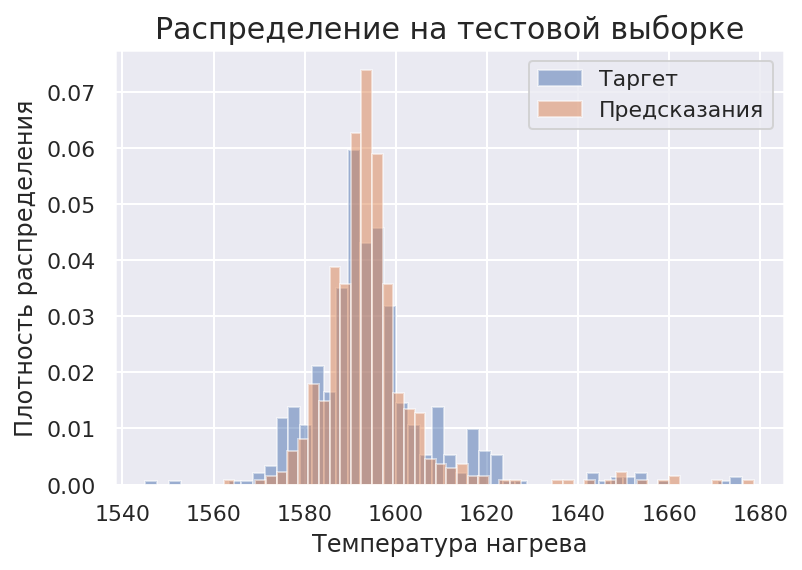

In [114]:
print('Средняя для тестового целевого признака:', round(target_test.mean(), 2))
print('Средняя для тестового пресказания:', round(predictions_cat_test.mean(), 2))
target_test.hist(bins = 50, alpha=0.5, density=True)
pd.Series(predictions_cat_test).hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

* Средние схожи, распределения так же. Однако предсказания получились немного идеальными и хуже определяет крайние случаи

In [115]:
#Сравнимc дамми
dummy_model = DummyRegressor(strategy='median').fit(features_train, target_train)
pred_dummy = dummy_model.predict(features_test)
mae_dummy = mean_absolute_error(target_test, pred_dummy)
print('MAE DummyRegressor:', round(mae_dummy, 2))
print('MAE CatBoostRegressor:', round(mae_cat_test, 2))

MAE DummyRegressor: 9.41
MAE CatBoostRegressor: 5.82


* Наша модель показывает себя гораздно лучше чем Дамми, в качестве стратегии которой выбраны медианные значения. 

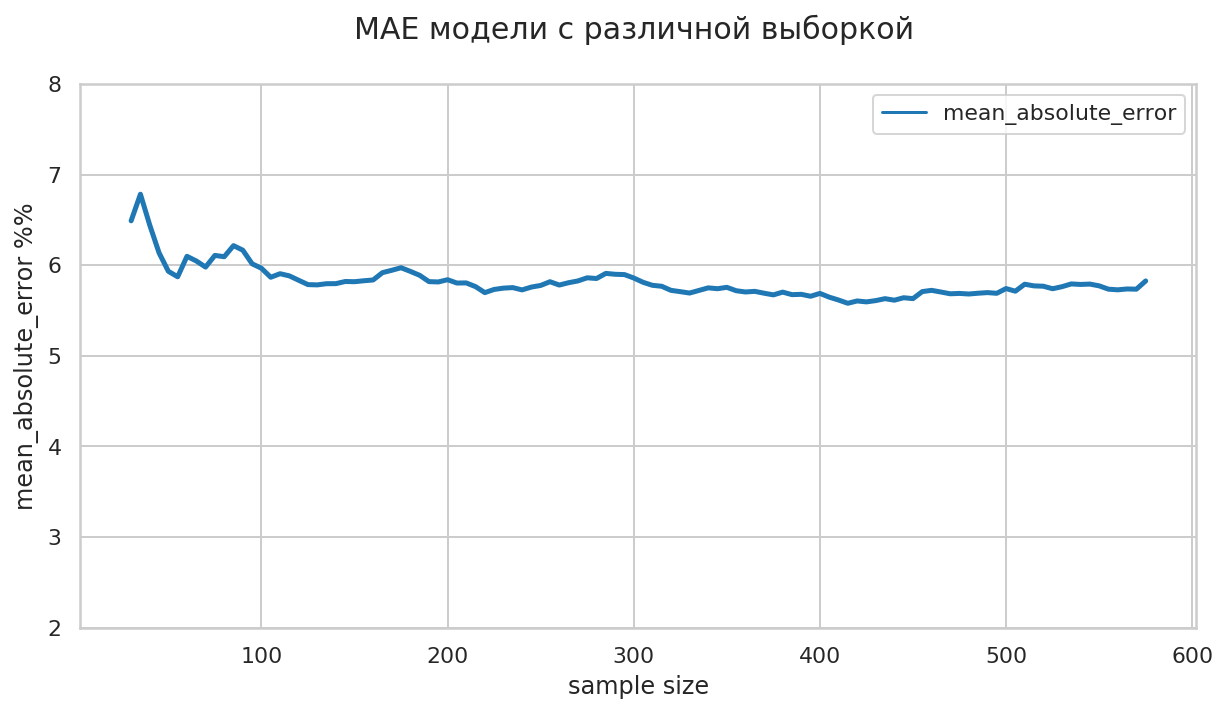

In [117]:
#**Зависимость от объема выборки**

#делаем базу. добавляем по 2 кейса увеличивая семпл
base_min = pd.DataFrame()
for i in range(30,len(target_test),5):
    base_min.loc[i,'mean_absolute_error'] = mean_absolute_error(target_test[0:i], model_cat.predict(features_test[0:i]))

#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.lineplot(data=base_min, palette="tab20", linewidth=2.5)
plt.title("MAE модели с различной выборкой \n", fontsize=15)
plt.ylabel("mean_absolute_error %%")
plt.xlabel("sample size")
plt.ylim((2, 8)) 
plt.show()

* Модель не очень стабильна на небольшой выборке, что ожидаемо. 
* В целом показатель точности не сильно колеблется и далее стабилизируется.

[К содержанию](#top)

# Вывод  
На основе исторических данных о клиентах, была построена модель для предсказания финальной температуру стали с целью оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» и уменьшить потребление электроэнергии на этапе обработки стали.

**Заказчику необходима модель с показателем MAE не более 6,8:**
* Полученная модель имеет на тестовой выборке МАЕ 5.82 

**По результатам первичного анализа в работу взяты:**
* Кейсы, содержащие минимум 2 замера температуры (первичный и окончательный).
* Кейсы с последним замером температуры после окончания нагревания дугой.

**Модель построена на основе данных о партиях на производстве*:**

* 'start_temp' - первичное измерение температуры
* 'full_time' - сколько прошло от начала первого нагревания дугой до окончания последнего
* 'sum_diff_heating_time' - суммарное время нагрева дугой
* 'mean_reactive_energy' - средняя реактивная мощность в процессе нагревания(в партии)
* 'mean_ratio_r_a_energy' - средняя соотношение активной и реактивной мощности в процессе нагревания (в партии)
* информация об объеме различных добавлений в процессе легиризации (
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6', 'bulk_1')
* информация об объеме газа использующегося в процессе ('gas')

**Целевой признак - Финальная температура(end_temp)**

**В качестве лучшей модели прогнозирования итоговой температуры стали выбрана модель градиентного бустинга CatBoost:**
* Подобраны оптимальные гиперпараметры, лучший результат дало именно такое сочетание значений гиперпараметров: ('depth': 5, 'iterations': 58, 'learning_rate': 0.25).